In [1]:
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import scanpy as sc
import anndata
import os
import sys
import tacco as tc
import seaborn as sns

In [2]:
import plotnine as pn
from plotnine import ggplot,aes,geom_point,geom_text, theme_bw,scale_y_discrete,scale_color_manual,scale_fill_manual,geom_vline,geom_hline

In [3]:
sys.path.insert(1, '/secure/projects/HTAPP_MBC/src/spatial')
from spatial_utils import *

In [4]:
matplotlib.rcParams['figure.dpi'] = low_dpi

In [5]:
combined_dir=out_dir_base+"/combined_all/"
os.makedirs(combined_dir, exist_ok=True)

In [6]:
#These identifiers are set as defaults in many functions. If names are changed, this has to be adapted when calling the functions.
ct_column='cell_type'
sm_methods=["slide_seq","merfish","merfish_bin","codex","exseq","exseq_bin"] #spatial mathod names are hard-coded for now because some methods need special treatments. Can be fixed by giving eatch method it's own variable.
sc_method="scRNAseq"
clean_method="merfish_clean"
all_methods=[sc_method,*sm_methods,clean_method]
all_methods

['scRNAseq',
 'slide_seq',
 'merfish',
 'merfish_bin',
 'codex',
 'exseq',
 'exseq_bin',
 'merfish_clean']

In [7]:
adatas_combined=pd.Series([[] for i in range(len(all_methods))],index=all_methods,dtype=object) 
obs_mal_combined=pd.Series([[] for i in range(len(all_methods))],index=all_methods,dtype=object) 
for method in sm_methods:
    adatas_combined[method]=sc.read(combined_dir+"/"+method+".h5ad",compression="gzip")
    obs_mal_combined[method]=pd.read_csv(combined_dir+"/"+method+"_mal_obs.tsv", sep="\t")

In [8]:
#add combined scRNAseq that was produced in the MERFISH analysis 
adatas_combined['scRNAseq']=sc.read_h5ad(out_dir_base+"/combined_merfish/scRNAseq.h5ad")
obs_mal_combined['scRNAseq']=pd.read_csv(combined_dir+"/scRNAseq_mal_obs.tsv", sep="\t")

In [9]:
#add combined merfish with clean annotation that was produced in the MERFISH analysis 
adatas_combined['merfish_clean']=sc.read_h5ad(out_dir_base+"/combined_merfish/merfish.h5ad")
obs_mal_combined['merfish_clean']=pd.read_csv(out_dir_base+"/combined_merfish/merfish_mal_obs.tsv", sep="\t")

In [10]:
adatas_combined['merfish_clean'].obs['cell_type'].value_counts()

cell_type
MBC                       42157
MBC_neuronal              17465
Fibroblast                11926
Smooth muscle_vascular     9872
Endothelial                7904
Macrophage                 7370
Hepatocyte                 4902
T                          3277
B                          1112
B_regulatory                102
Name: count, dtype: int64

In [11]:
#add bins per method
smc_methods=[*sm_methods,clean_method]
for method in smc_methods:
    tc.utils.bin(adatas_combined[method].obs,bin_size=100,bin_keys=["x_100","y_100"]);
    tc.utils.hash(adatas_combined[method].obs,keys=["x_100","y_100","sample"],hash_key="bin_100");

In [31]:
method="merfish"
cell_types=["MBC","MBC_stem-like","MBC_neuronal"]

In [32]:
adata_sub=adatas_combined[method][adatas_combined[method].obs['OT'].isin(cell_types)]

In [33]:
obs_mal=obs_mal_combined[method]

In [34]:
obs_mal.loc[obs_mal['sample'].isin(["HTAPP-880-SMP-7179","HTAPP-812-SMP-8239","HTAPP-982-SMP-7629","HTAPP-313-SMP-932"]),"EMT_phenotype"]='low'
obs_mal.loc[obs_mal['sample'].isin(["HTAPP-944-SMP-7479","HTAPP-917-SMP-4531","HTAPP-853-SMP-4381"]),"EMT_phenotype"]='patched'
obs_mal.loc[obs_mal['sample'].isin(["HTAPP-878-SMP-7149","HTAPP-514-SMP-6760"]),"EMT_phenotype"]='high'

In [35]:
obs_bin=obs_mal.groupby(["sample","x_100","y_100","bin_100","EMT_phenotype"])["EMT_fresh"].mean().to_frame().reset_index()
obs_bin.head()

sample  x_100  y_100  bin_100 EMT_phenotype  EMT_fresh
0  HTAPP-313-SMP-932      1    137     4423           low   0.155834
1  HTAPP-313-SMP-932      2    137     3347           low   0.034578
2  HTAPP-313-SMP-932      2    138     3350           low  -0.033148
3  HTAPP-313-SMP-932      2    140     3348           low   0.066004
4  HTAPP-313-SMP-932      2    141     3352           low   0.030199

In [36]:
#new_obs=adata_sub.obs.merge(obs_mal[["Unnamed: 0","sample_repl","EMT_fresh","EMT_phenotype"]],left_index=True,right_on="Unnamed: 0")
adata_sub.obs['index_copy']=adata_sub.obs.index
new_obs=adata_sub.obs.merge(obs_bin,on=["sample","x_100","y_100","bin_100"])

/secure/tmp/ipykernel_121327/821006310.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


In [37]:
new_obs.set_index("index_copy",inplace=True)

In [38]:
adata_sub=adata_sub[new_obs.index]
adata_sub.obs=new_obs

In [39]:
adata_sub.obs.head()

replicate          RCTD   
index_copy                                                                   
cell100195857902438619713598114815661636131-1-H...         1  MBC_neuronal  \
cell103506799912770594252722014697915107238-1-H...         1  MBC_neuronal   
cell113376657269555144033398478983330747582-1-H...         1  MBC_neuronal   
cell117214188758787755204930783458370105825-1-H...         1  MBC_neuronal   
cell121902373887701650420556602492395104638-1-H...         1  MBC_neuronal   

                                                              OT   
index_copy                                                         
cell100195857902438619713598114815661636131-1-H...  MBC_neuronal  \
cell103506799912770594252722014697915107238-1-H...  MBC_neuronal   
cell113376657269555144033398478983330747582-1-H...  MBC_neuronal   
cell117214188758787755204930783458370105825-1-H...  MBC_neuronal   
cell121902373887701650420556602492395104638-1-H...  MBC_neuronal   

                                                          OT_max           x   
index_copy                                                                     
cell100195857902438619713598114815661636131-1-H...  MBC_neuronal  724.827404  \
cell103506799912770594252722014697915107238-1-H...  MBC_neuronal  785.163193   
cell113376657269555144033398478983330747582-1-H...  MBC_neuronal  736.343494   
cell117214188758787755204930783458370105825-1-H...  MBC_neuronal  732.636111   
cell121902373887701650420556602492395104638-1-H...  MBC_neuronal  714.434248   

                                                              y   
index_copy                                                        
cell100195857902438619713598114815661636131-1-H...  1494.170486  \
cell103506799912770594252722014697915107238-1-H...  1590.443527   
cell113376657269555144033398478983330747582-1-H...  1578.174101   
cell117214188758787755204930783458370105825-1-H...  1587.829036   
cell121902373887701650420556602492395104638-1-H...  1501.507427   

                                                                sample   
index_copy                                                               
cell100195857902438619713598114815661636131-1-H...  HTAPP-944-SMP-7479  \
cell103506799912770594252722014697915107238-1-H...  HTAPP-944-SMP-7479   
cell113376657269555144033398478983330747582-1-H...  HTAPP-944-SMP-7479   
cell117214188758787755204930783458370105825-1-H...  HTAPP-944-SMP-7479   
cell121902373887701650420556602492395104638-1-H...  HTAPP-944-SMP-7479   

                                                    n_genes_by_counts   
index_copy                                                              
cell100195857902438619713598114815661636131-1-H...                 33  \
cell103506799912770594252722014697915107238-1-H...                 29   
cell113376657269555144033398478983330747582-1-H...                 18   
cell117214188758787755204930783458370105825-1-H...                 41   
cell121902373887701650420556602492395104638-1-H...                 28   

                                                    total_counts   
index_copy                                                         
cell100195857902438619713598114815661636131-1-H...          57.0  \
cell103506799912770594252722014697915107238-1-H...          45.0   
cell113376657269555144033398478983330747582-1-H...          25.0   
cell117214188758787755204930783458370105825-1-H...          78.0   
cell121902373887701650420556602492395104638-1-H...          50.0   

                                                    total_counts_mt   
index_copy                                                            
cell100195857902438619713598114815661636131-1-H...              0.0  \
cell103506799912770594252722014697915107238-1-H...              0.0   
cell113376657269555144033398478983330747582-1-H...              0.0   
cell117214188758787755204930783458370105825-1-H...              0.0   
cell121902373887701650420556602492395104638-1-H...            

### Find genes associated with EMT high/low

In [19]:
adata_sub.obs["EMT_low"]=adata_sub.obs["EMT_fresh"]<0
adata_sub.obs['EMT_low'] = adata_sub.obs['EMT_low'].astype("str")

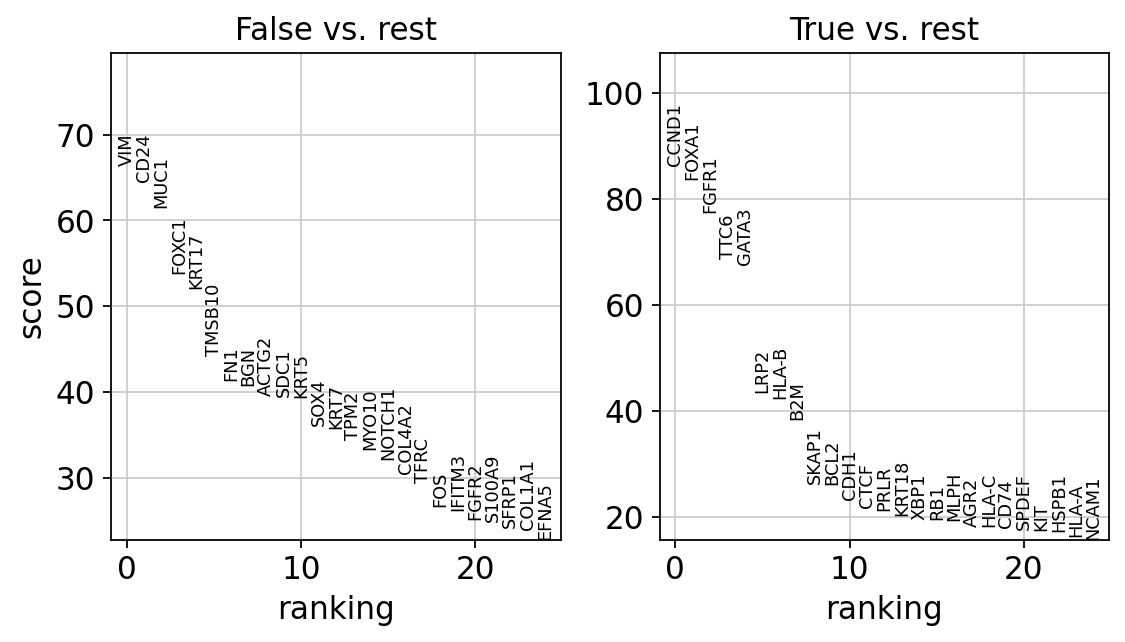

In [20]:
sc.tl.rank_genes_groups(adata_sub, 'EMT_low', method='wilcoxon')
sc.pl.rank_genes_groups(adata_sub, n_genes=25, sharey=False)

lo=sc.get.rank_genes_groups_df(adata_sub,group=['True'],pval_cutoff=0.1,log2fc_min=0)
lo['direction']="EMT_low"
hi=sc.get.rank_genes_groups_df(adata_sub,group=['False'],log2fc_min=0,pval_cutoff=0.1)
hi['direction']="EMT_high"

de_genes_mal_emt=pd.concat([lo,hi])
#de_genes_mal_emt.to_csv(combined_dir+"/de_genes_mal_emt.tsv", sep="\t")

In [21]:
de_genes_mal_emt.head()

names     scores  logfoldchanges  pvals  pvals_adj direction
0  CCND1  86.291847        3.747332    0.0        0.0   EMT_low
1  FOXA1  83.599640        3.727623    0.0        0.0   EMT_low
2  FGFR1  77.330849        3.891577    0.0        0.0   EMT_low
3   TTC6  68.702698        3.483205    0.0        0.0   EMT_low
4  GATA3  67.529358        3.037079    0.0        0.0   EMT_low

In [22]:
de_genes_mal_emt.loc[de_genes_mal_emt.direction=='EMT_high','logfoldchanges']=-de_genes_mal_emt[de_genes_mal_emt.direction=='EMT_high'].logfoldchanges

In [23]:
de_genes_mal_emt['nlog_pvals_adj']=-np.log10(de_genes_mal_emt.pvals_adj+(1E-300))

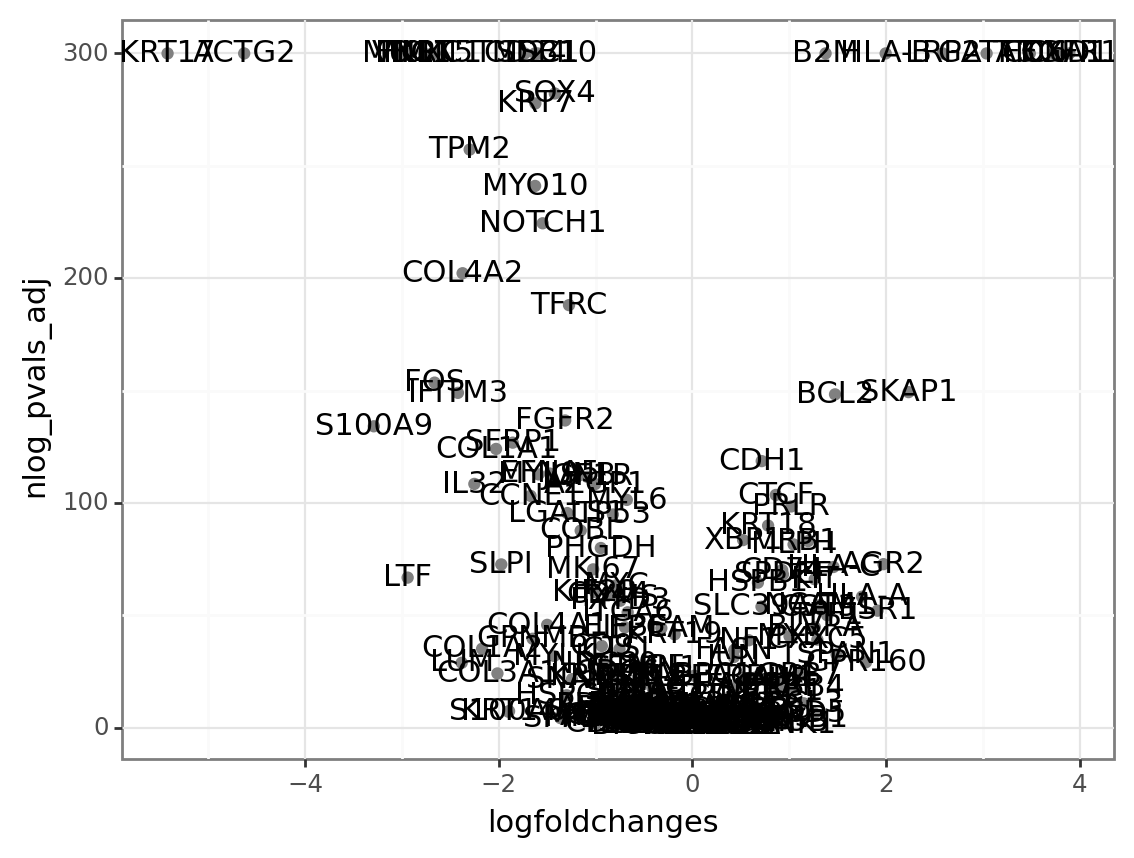

<ggplot: (2978818373012)>

In [24]:
pl=(ggplot(de_genes_mal_emt,aes(x="logfoldchanges",y='nlog_pvals_adj'))+geom_point(color="grey")+geom_text(aes(label='names'))+theme_bw())
pl

### Consider sample structure (pseudobulk per sample)

#### Find genes associated with EMT phenotypes (high-patched-low)

In [40]:
adata_sub.obs["EMT_phenotype"]=adata_sub.obs["EMT_phenotype"].astype('category')

In [41]:
adata_copy=tc.get.counts(adata_sub,counts_location=("obsm","counts"),annotation=True)

In [42]:
adata_copy.obs["sample"]=adata_copy.obs["sample"].astype("category")

In [48]:
overview=adata_sub.obs.groupby("EMT_phenotype")['sample'].value_counts()
overview[overview!=0]

EMT_phenotype  sample            
high           HTAPP-514-SMP-6760     9349
               HTAPP-878-SMP-7149     2631
low            HTAPP-982-SMP-7629     8442
               HTAPP-313-SMP-932      6539
               HTAPP-880-SMP-7179     3463
               HTAPP-812-SMP-8239     1806
patched        HTAPP-944-SMP-7479    16336
               HTAPP-917-SMP-4531    10630
               HTAPP-853-SMP-4381     2026
Name: count, dtype: int64

##### high vs. patched

In [29]:
enr = tc.tl.enrichments(adata_copy, value_key=None, group_key='EMT_phenotype',restrict_groups=['high','patched'] ,sample_key='sample', value_location='X', p_corr='fdr_bh', position_key=['x','y'], position_split=(1,2), method='welch' ,direction='both', reduction='mean', normalization='clr', assume_counts=True)

In [30]:
enr["-log10_p_welch_fdr_bh"]=-np.log10(enr['p_welch_fdr_bh'])

In [31]:
enr[(enr['p_welch_fdr_bh']<0.05)&(enr['EMT_phenotype']=='high')].sort_values("enrichment")

value EMT_phenotype enrichment       p_welch  p_welch_fdr_bh   
256   CDC20          high   enriched  5.075266e-05        0.005908  \
368    CTSL          high   enriched  2.331494e-05        0.004523   
137   CCND1          high   purified  1.754131e-07        0.000102   
193    CD3G          high   purified  3.231745e-04        0.031348   
945     RB1          high   purified  8.793290e-06        0.002559   
1157   ZEB1          high   purified  4.098979e-05        0.005908   

      -log10_p_welch_fdr_bh  
256                2.228588  
368                2.344564  
137                3.991015  
193                1.503791  
945                2.591956  
1157               2.228588

In [32]:
contrib=tc.tl.get_contributions(adata_copy, value_key=None, group_key='EMT_phenotype',restrict_groups=['high','patched'] , sample_key='sample', value_location='X', position_key=['x','y'], position_split=(1,2), reduction='mean', normalization='sum', assume_counts=True)

In [33]:
contrib=contrib.groupby("EMT_phenotype").mean().T
contrib['log2FC']=np.log2(contrib['high']/contrib['patched'])
contrib.head()

EMT_phenotype      high   patched    log2FC
value                                      
ACTA2          0.000731  0.000384  0.930383
ACTG2          0.006095  0.000283  4.429088
ACTR3B         0.001064  0.002423 -1.187274
ADGRL4         0.000185  0.000138  0.422361
AGR2           0.000413  0.000660 -0.677298

In [34]:
enr_fc=enr.merge(contrib,on="value")
#filter out duplicate entries (enriched/purified)
enr_fc=enr_fc.loc[enr_fc.groupby('value').p_welch.idxmin()]
enr_fc['signif']=enr_fc['p_welch_fdr_bh']<0.05
enr_fc['annot']=np.nan
enr_fc.loc[enr_fc['p_welch_fdr_bh']<0.1,'annot']=enr_fc['value']
enr_fc.head()

value EMT_phenotype enrichment   p_welch  p_welch_fdr_bh   
0    ACTA2          high   enriched  0.141653        0.583294  \
4    ACTG2          high   enriched  0.104288        0.514281   
9   ACTR3B          high   purified  0.001574        0.076510   
13  ADGRL4          high   purified  0.317311        0.822782   
17    AGR2          high   purified  0.202881        0.698227   

    -log10_p_welch_fdr_bh      high   patched    log2FC  signif   annot  
0                0.234112  0.000731  0.000384  0.930383   False     NaN  
4                0.288800  0.006095  0.000283  4.429088   False     NaN  
9                1.116282  0.001064  0.002423 -1.187274   False  ACTR3B  
13               0.084715  0.000185  0.000138  0.422361   False     NaN  
17               0.156003  0.000413  0.000660 -0.677298   False     NaN

/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 272 rows containing missing values.


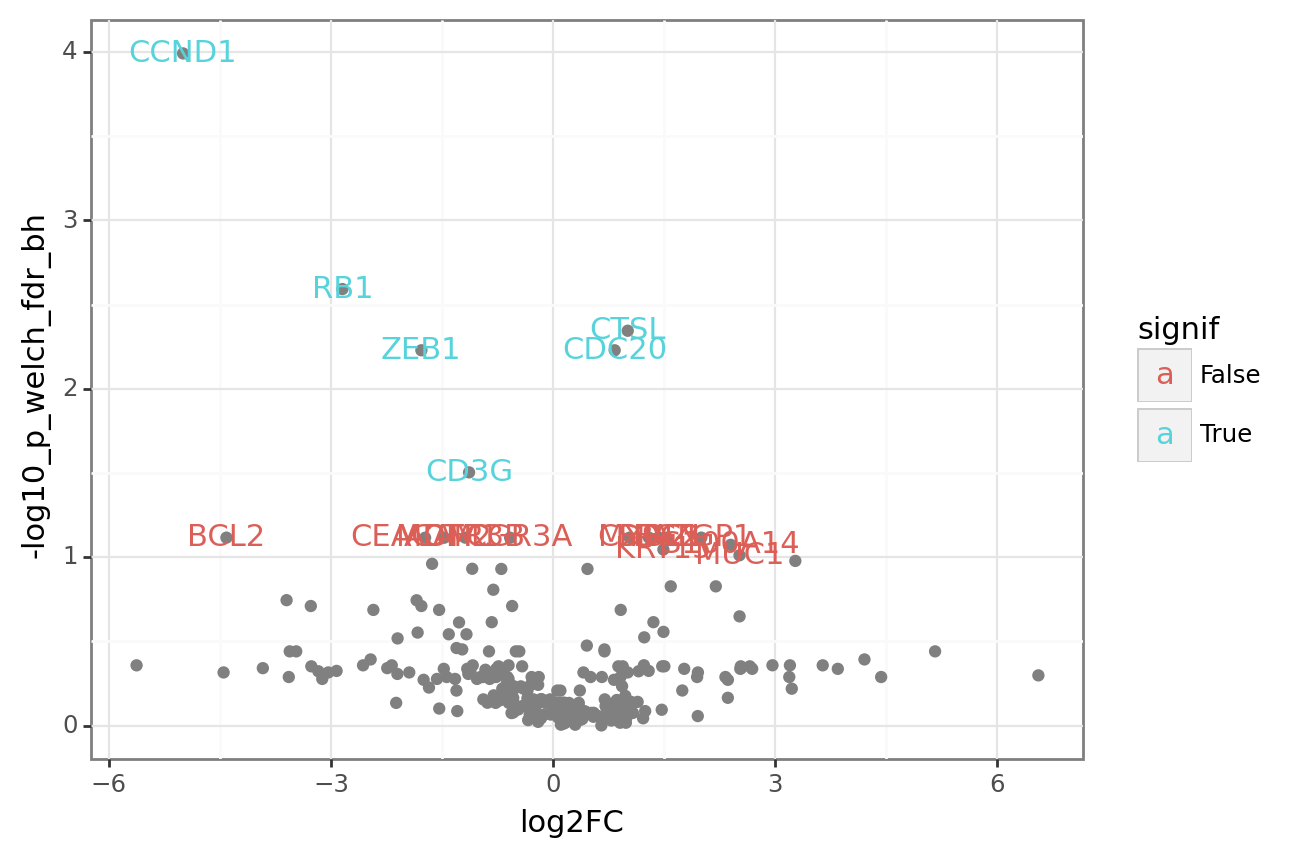

<ggplot: (2978821311732)>

In [35]:
pl=(ggplot(enr_fc,aes(x="log2FC",y='-log10_p_welch_fdr_bh'))+
    geom_point(color="grey")+geom_text(aes(label='annot',color='signif'))+theme_bw())
pl

##### all against all others

In [73]:
enr_all = tc.tl.enrichments(adata_copy, value_key=None, group_key='EMT_phenotype' ,sample_key='sample', value_location='X', p_corr='fdr_bh', position_key=['x','y'], position_split=(1,2), method='welch' ,direction='both', reduction='mean', normalization='clr', assume_counts=True)

In [74]:
enr_all["-log10_p_welch_fdr_bh"]=-np.log10(enr_all['p_welch_fdr_bh'])

In [75]:
enr_all=enr_all.loc[enr_all.groupby(['value','EMT_phenotype']).p_welch.idxmin()]

In [91]:
enr_all["signif"]=enr_all["p_welch_fdr_bh"]<0.05
enr_all["signif_enriched"]=(enr_all["p_welch_fdr_bh"]<0.05)&(enr_all["enrichment"]=="enriched")
enr_all["plot"]=enr_all["value"].map(enr_all.groupby('value')['signif_enriched'].any())

In [92]:
enr_all.head()

value EMT_phenotype enrichment   p_welch  p_welch_fdr_bh   
0  ACTA2          high   enriched  0.048961        0.449925  \
3  ACTA2           low   purified  0.265667        0.840316   
5  ACTA2       patched   purified  0.398567        0.944230   
6  ACTG2          high   enriched  0.097403        0.550377   
9  ACTG2           low   purified  0.065699        0.500919   

   -log10_p_welch_fdr_bh  signif   plot  signif_enriched  
0               0.346860   False  False            False  
3               0.075557   False  False            False  
5               0.024922   False  False            False  
6               0.259340   False  False            False  
9               0.300232   False  False            False

In [93]:
enr_plot=enr_all[(enr_all['signif']==True)&(enr_all['enrichment']=='enriched')]

In [100]:
enr_plot=enr_plot.sort_values(["EMT_phenotype","p_welch_fdr_bh"],ascending=False)

In [101]:
enr_plot

value EMT_phenotype enrichment       p_welch  p_welch_fdr_bh   
292    CD3G       patched   enriched  5.271027e-04        0.038148  \
1258    NF1       patched   enriched  4.216183e-04        0.033461   
208   CCND1       patched   enriched  2.911571e-04        0.027767   
1738   ZEB1       patched   enriched  1.057403e-04        0.016784   
1420    RB1       patched   enriched  6.873544e-07        0.000600   
1484  SIAH2           low   enriched  4.087807e-04        0.033461   
26     AGR2           low   enriched  2.229580e-04        0.024330   
120     BGN          high   enriched  6.760888e-04        0.045402   
1470   SDC1          high   enriched  3.021618e-04        0.027767   
552    CTSL          high   enriched  8.873387e-05        0.015493   
384   CDC20          high   enriched  5.178017e-05        0.011301   

      -log10_p_welch_fdr_bh  signif  plot  signif_enriched  
292                1.418524    True  True             True  
1258               1.475459    True  True             True  
208                1.556470    True  True             True  
1738               1.775108    True  True             True  
1420               3.221805    True  True             True  
1484               1.475459    True  True             True  
26                 1.613853    True  True             True  
120                1.342925    True  True             True  
1470               1.556470    True  True             True  
552                1.809866    True  True             True  
384                1.946882    True  True             True

In [102]:
enr_all['value']=enr_all['value'].astype(pd.CategoricalDtype(categories=enr_plot['value'].astype(str),ordered=True))

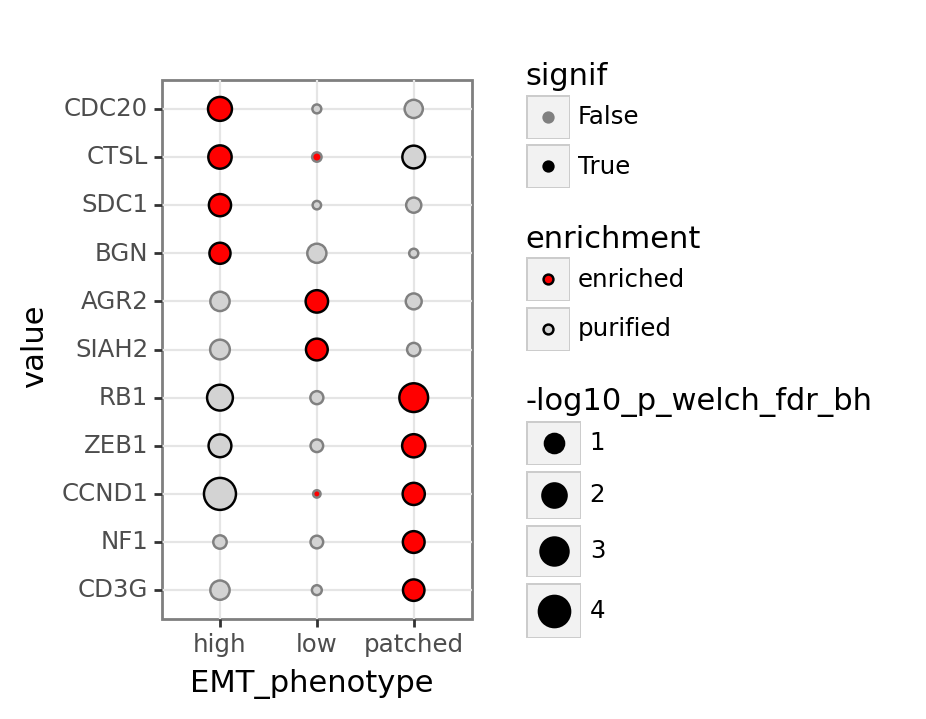

<ggplot: (2966956627167)>

In [119]:
pn.options.figure_size = (2, 3.5)
pl_all=(ggplot(enr_all[enr_all['plot']==True],aes(y="value",x="EMT_phenotype",color='signif',fill='enrichment',size='-log10_p_welch_fdr_bh'))+
    geom_point()+theme_bw()+scale_color_manual({False:'grey',True:'black'})+scale_fill_manual({'enriched':'red','purified':'lightgrey'}))
pl_all

#### Check hi/lo difference considering sample structure

In [36]:
enr_hi_lo = tc.tl.enrichments(adata_copy, value_key=None, group_key='EMT_low', sample_key='sample', value_location='X', p_corr='fdr_bh', position_key=['x','y'], position_split=(1,2), method='welch' ,direction='both', reduction='mean', normalization='sum', assume_counts=True)

In [37]:
enr_hi_lo[(enr_hi_lo['p_welch_fdr_bh']<0.05)&(enr_hi_lo['EMT_low']=="False")].sort_values("enrichment")

value EMT_low enrichment       p_welch  p_welch_fdr_bh
0     ACTA2   False   enriched  1.731899e-04        0.022187
80      BGN   False   enriched  5.353779e-06        0.001558
324  COL3A1   False   enriched  4.227340e-05        0.008201
328  COL4A1   False   enriched  1.165314e-07        0.000068
332  COL4A2   False   enriched  1.906093e-04        0.022187
380     DCN   False   enriched  6.627244e-04        0.048213
684    LDB2   False   enriched  6.455037e-04        0.048213
800    MYL9   False   enriched  5.741068e-04        0.048213

### As function to run across multiple cell types/methods

In [12]:
merfish_genes=adatas_combined['merfish'].var.index.tolist()
len(merfish_genes)

291

In [23]:
def EMT_diff(adatas_combined,obs_mal_combined,method,cell_types,merfish_genes=merfish_genes):

    if method == 'merfish_clean':
        adata_sub=adatas_combined[method][adatas_combined[method].obs['cell_type'].isin(cell_types)].copy()
        #create obs
        obs_mal=obs_mal_combined[method]
        obs_mal.loc[obs_mal['sample'].isin(["HTAPP-880-SMP-7179","HTAPP-812-SMP-8239","HTAPP-982-SMP-7629","HTAPP-313-SMP-932"]),"EMT_phenotype"]='low'
        obs_mal.loc[obs_mal['sample'].isin(["HTAPP-944-SMP-7479","HTAPP-917-SMP-4531","HTAPP-853-SMP-4381"]),"EMT_phenotype"]='patched'
        obs_mal.loc[obs_mal['sample'].isin(["HTAPP-878-SMP-7149","HTAPP-514-SMP-6760"]),"EMT_phenotype"]='high'
    
    if method == 'scRNAseq':
        adata_sub=adatas_combined[method][adatas_combined[method].obs['cell_type'].isin(cell_types)].copy()
        adata_sub.obs.loc[adata_sub.obs['sample'].isin(["HTAPP-880-SMP-7179","HTAPP-812-SMP-8239","HTAPP-982-SMP-7629","HTAPP-313-SMP-932"]),"EMT_phenotype"]='low'
        adata_sub.obs.loc[adata_sub.obs['sample'].isin(["HTAPP-944-SMP-7479","HTAPP-917-SMP-4531","HTAPP-853-SMP-4381"]),"EMT_phenotype"]='patched'
        adata_sub.obs.loc[adata_sub.obs['sample'].isin(["HTAPP-878-SMP-7149","HTAPP-514-SMP-6760"]),"EMT_phenotype"]='high'
    else:
        adata_sub=adatas_combined[method][adatas_combined[method].obs['OT'].isin(cell_types)].copy()
        #create obs
        obs_mal=obs_mal_combined[method]
        obs_mal.loc[obs_mal['sample'].isin(["HTAPP-880-SMP-7179","HTAPP-812-SMP-8239","HTAPP-982-SMP-7629","HTAPP-313-SMP-932"]),"EMT_phenotype"]='low'
        obs_mal.loc[obs_mal['sample'].isin(["HTAPP-944-SMP-7479","HTAPP-917-SMP-4531","HTAPP-853-SMP-4381"]),"EMT_phenotype"]='patched'
        obs_mal.loc[obs_mal['sample'].isin(["HTAPP-878-SMP-7149","HTAPP-514-SMP-6760"]),"EMT_phenotype"]='high'

        #new_obs=adata_sub.obs.merge(obs_mal[["Unnamed: 0","sample_repl","EMT_fresh","EMT_phenotype"]],left_index=True,right_on="Unnamed: 0")
        obs_bin=obs_mal.groupby(["sample","x_100","y_100","bin_100","EMT_phenotype"])["EMT_fresh"].mean().to_frame().reset_index()
        adata_sub.obs['index_copy']=adata_sub.obs.index
        new_obs=adata_sub.obs.merge(obs_bin,on=["sample","x_100","y_100","bin_100"])
    
        new_obs.set_index("index_copy",inplace=True)

        adata_sub=adata_sub[new_obs.index]
        adata_sub.obs=new_obs


        ### Find genes associated with EMT high/low

        adata_sub.obs["EMT_low"]=adata_sub.obs["EMT_fresh"]<0
        adata_sub.obs['EMT_low'] = adata_sub.obs['EMT_low'].astype("str")
    
        sc.tl.rank_genes_groups(adata_sub, 'EMT_low', method='wilcoxon')
        #sc.pl.rank_genes_groups(adata_sub, n_genes=25, sharey=False)

        lo=sc.get.rank_genes_groups_df(adata_sub,group=['True'],pval_cutoff=0.5,log2fc_min=0)
        lo['direction']="EMT_low"
        hi=sc.get.rank_genes_groups_df(adata_sub,group=['False'],pval_cutoff=0.5,log2fc_min=0)
        hi['direction']="EMT_high"
        de_genes_mal_emt=pd.concat([lo,hi])
        #de_genes_mal_emt.to_csv(combined_dir+"/de_genes_mal_emt.tsv", sep="\t")

        de_genes_mal_emt.loc[de_genes_mal_emt.direction=='EMT_high','logfoldchanges']=-de_genes_mal_emt[de_genes_mal_emt.direction=='EMT_high'].logfoldchanges

        de_genes_mal_emt['-log10_pvals_adj']=-np.log10(de_genes_mal_emt.pvals_adj+(1E-300))
        de_genes_mal_emt.rename(columns={"logfoldchanges":"log2FC(EMT_low/EMT_high)"},inplace=True)
    
        pn.options.figure_size = (4, 3.5)
        pl_hi_lo=(ggplot(de_genes_mal_emt,aes(x="log2FC(EMT_low/EMT_high)",y='-log10_pvals_adj'))+geom_point(color="grey")+
                  geom_text(aes(label='names'),size=7)+theme_bw())
        print(pl_hi_lo)


    ### Consider sample structure (pseudobulk per sample)
    #### Find genes associated with EMT phenotypes (high-patched-low)

    adata_sub.obs["EMT_phenotype"]=adata_sub.obs["EMT_phenotype"].astype('category')
    adata_sub.obs["sample"]=adata_sub.obs["sample"].astype('category')
    
    overview=adata_sub.obs.groupby("EMT_phenotype")['sample'].value_counts()
    print(overview[overview!=0])

    #set counts as X
    adata_copy=tc.get.counts(adata_sub,counts_location=("obsm","counts"),annotation=True)

    if adata_copy.var.shape[0]>10000:
        print("Filtering genes")
        sc.pp.calculate_qc_metrics(adata_copy,inplace=True)
        sc.pp.filter_genes(adata_copy,min_cells=adata_copy.obs.shape[0]*0.05)
    
    ##### high vs patched volcano
    #calculate significance
    if method=='scRNAseq':
        enr = tc.tl.enrichments(adata_copy, value_key=None, group_key='EMT_phenotype',restrict_groups=['high','patched'] ,sample_key='sample', value_location='X', p_corr='fdr_bh', method='welch' ,direction='both', reduction='mean', normalization='clr', assume_counts=True)
    else:
        enr = tc.tl.enrichments(adata_copy, value_key=None, group_key='EMT_phenotype',restrict_groups=['high','patched'] ,sample_key='sample', value_location='X', p_corr='fdr_bh', position_key=['x','y'], position_split=(1,2), method='welch' ,direction='both', reduction='mean', normalization='clr', assume_counts=True)
        
    enr["-log10_p_welch_fdr_bh"]=-np.log10(enr['p_welch_fdr_bh'])

    #calculate lfc
    if method=='scRNAseq':
        contrib=tc.tl.get_contributions(adata_copy, value_key=None, group_key='EMT_phenotype',restrict_groups=['high','patched'] , sample_key='sample', value_location='X', reduction='mean', normalization='sum', assume_counts=True)
    else:
        contrib=tc.tl.get_contributions(adata_copy, value_key=None, group_key='EMT_phenotype',restrict_groups=['high','patched'] , sample_key='sample', value_location='X', position_key=['x','y'], position_split=(1,2), reduction='mean', normalization='sum', assume_counts=True)
        
    contrib=contrib.groupby("EMT_phenotype").mean().T
    contrib['log2FC(high/patched)']=np.log2(contrib['high']/contrib['patched'])

    #combine lfc and signif
    enr_fc=enr.merge(contrib,on="value")
    #filter out duplicate entries (enriched/purified)
    enr_fc['value']=enr_fc['value'].astype(str)
    enr_fc=enr_fc.loc[enr_fc.groupby('value').p_welch.idxmin()]
    enr_fc['signif']=(enr_fc['p_welch_fdr_bh']<0.05)
    enr_fc['annot']=np.nan
    enr_fc.loc[(enr_fc['p_welch_fdr_bh']<0.1)&(np.abs(enr_fc["log2FC(high/patched)"])>1),'annot']=enr_fc['value']
    
    pn.options.figure_size = (4, 3.5)
    pl_emt_pheno=(ggplot(enr_fc,aes(x="log2FC(high/patched)",y='-log10_p_welch_fdr_bh'))+
    geom_point(color='grey',alpha=0.7)+geom_vline(xintercept=[-1,1],linetype='dashed')+
                  geom_hline(yintercept=1.3,linetype='dashed')+geom_text(aes(label='annot',color='signif'),size=7)+
                  scale_color_manual(["black","red"])+theme_bw())
    print(pl_emt_pheno)

    #prep for saving
    enr_fc_ret=enr_fc.loc[enr_fc['value'].isin(merfish_genes),:].copy()
    enr_fc_ret['method']=method
    enr_fc_ret['cell_type']=cell_types[0]
    
    ##### all against all others

    if method=="scRNAseq":
        enr_all = tc.tl.enrichments(adata_copy, value_key=None, group_key='EMT_phenotype' ,sample_key='sample', value_location='X', p_corr='fdr_bh', method='welch' ,direction='both', reduction='mean', normalization='clr', assume_counts=True)
    else:
        enr_all = tc.tl.enrichments(adata_copy, value_key=None, group_key='EMT_phenotype' ,sample_key='sample', value_location='X', p_corr='fdr_bh', position_key=['x','y'], position_split=(1,2), method='welch' ,direction='both', reduction='mean', normalization='clr', assume_counts=True)

    
    enr_all["-log10_p_welch_fdr_bh"]=-np.log10(enr_all['p_welch_fdr_bh'])
    enr_all=enr_all.loc[enr_all.groupby(['value','EMT_phenotype']).p_welch.idxmin()]
    
    enr_all["signif"]=enr_all["p_welch_fdr_bh"]<0.05
    enr_all["signif_enriched"]=(enr_all["p_welch_fdr_bh"]<0.05)&(enr_all["enrichment"]=="enriched")
    
    #prep for saving
    enr_ret=enr_all.loc[enr_all['value'].isin(merfish_genes),:].copy()
    enr_ret['method']=method
    enr_ret['cell_type']=cell_types[0]
    
    enr_all["plot"]=enr_all["value"].map(enr_all.groupby('value')['signif_enriched'].any())
    
    enr_plot=enr_all[(enr_all['signif']==True)&(enr_all['enrichment']=='enriched')]
    
    enr_plot=enr_plot.sort_values(["EMT_phenotype","p_welch_fdr_bh"],ascending=False)
    
    enr_all['value']=enr_all['value'].astype(pd.CategoricalDtype(categories=enr_plot['value'].astype(str),ordered=True))
    
    n_genes=enr_plot.shape[0]
    if n_genes==0:
        print("Could not run all against all others")
        pl_all=None
    else: 
        pn.options.figure_size = (2, 1+0.17*n_genes) #3.5
        pl_all=(ggplot(enr_all[enr_all['plot']==True],aes(y="value",x="EMT_phenotype",color='signif',fill='enrichment',size='-log10_p_welch_fdr_bh'))+
        geom_point()+theme_bw()+scale_color_manual({False:'grey',True:'black'})+scale_fill_manual({'enriched':'red','purified':'lightgrey'}))
        print(pl_all)
    
        
#### Check hi/lo difference considering sample structure

    #enr_hi_lo = tc.tl.enrichments(adata_copy, value_key=None, group_key='EMT_low', sample_key='sample', value_location='X', p_corr='fdr_bh', position_key=['x','y'], position_split=None, method='welch' ,direction='both', reduction='mean', normalization='sum', assume_counts=True)
    #enr_hi_lo[enr_hi_lo['p_welch_fdr_bh']<0.05].sort_values("EMT_low")
    if method=='scRNAseq':
        pl_emt_pheno.save(combined_dir+"EMT_de_pheno_volcano_"+method+"_"+cell_types[0]+".pdf",verbose = False)
        return None,pl_emt_pheno,None,enr_ret,enr_fc_ret
    else:
        pl_emt_pheno.save(combined_dir+"EMT_de_pheno_volcano_"+method+"_"+cell_types[0]+".pdf",verbose = False)
        if pl_all!=None:
            pl_all.save(combined_dir+"EMT_de_all_bubble_"+method+"_"+cell_types[0]+".pdf",verbose = False)
        return pl_hi_lo,pl_emt_pheno,pl_all,enr_ret,enr_fc_ret 


In [20]:
all_res=pd.DataFrame()
fc_res=pd.DataFrame()

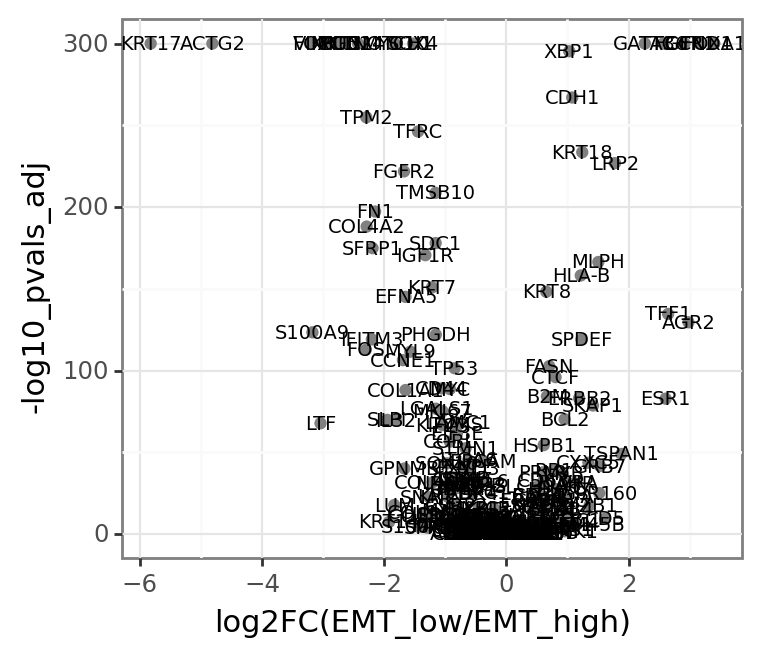


EMT_phenotype  sample            
high           HTAPP-514-SMP-6760     9296
               HTAPP-878-SMP-7149     2580
low            HTAPP-982-SMP-7629     8033
               HTAPP-313-SMP-932      6515
               HTAPP-880-SMP-7179     3463
               HTAPP-812-SMP-8239     1779
patched        HTAPP-944-SMP-7479    16334
               HTAPP-917-SMP-4531    10567
               HTAPP-853-SMP-4381     2023
Name: count, dtype: int64


/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 274 rows containing missing values.


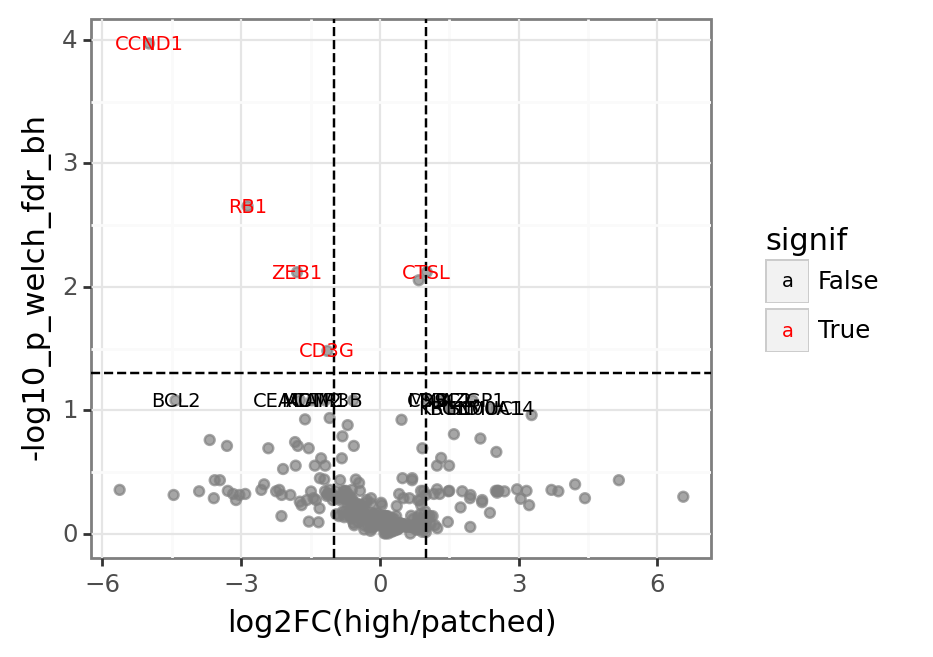

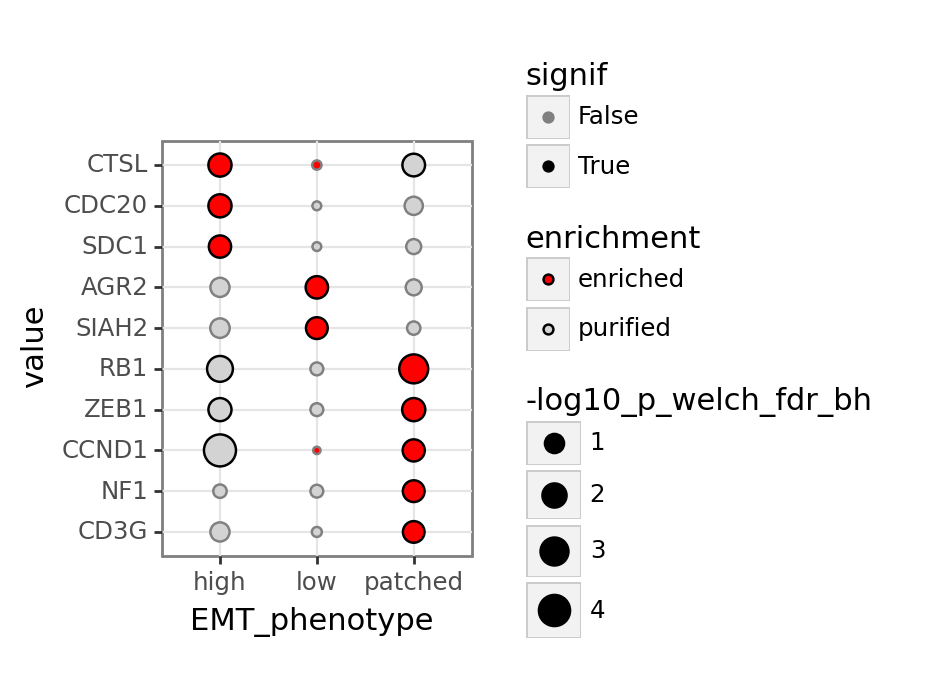

/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 274 rows containing missing values.


In [21]:
all_tmp=EMT_diff(adatas_combined,obs_mal_combined,"merfish_clean",["MBC","MBC_stem-like","MBC_neuronal"])
all_res=pd.concat([all_res,all_tmp[3]])
fc_res=pd.concat([fc_res,all_tmp[4]])

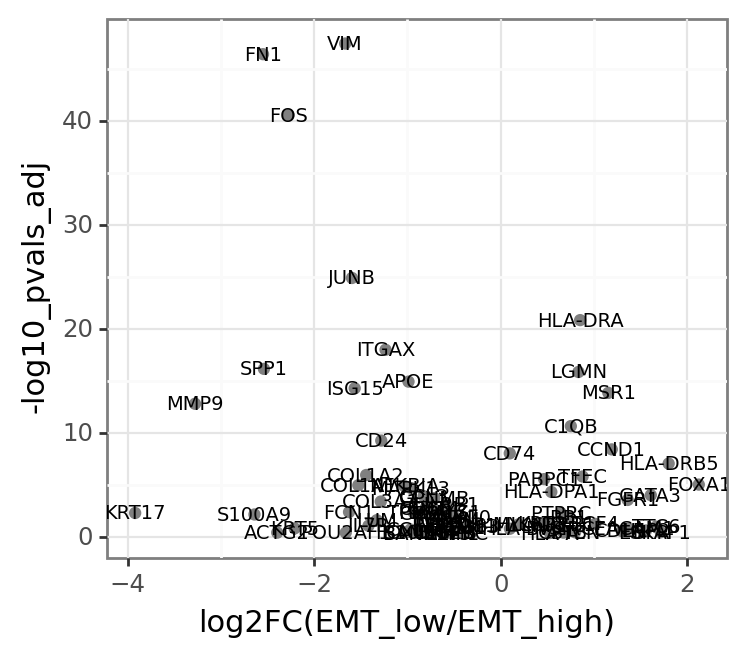


EMT_phenotype  sample            
high           HTAPP-514-SMP-6760    1652
               HTAPP-878-SMP-7149     586
low            HTAPP-313-SMP-932      701
               HTAPP-982-SMP-7629     461
               HTAPP-812-SMP-8239     190
               HTAPP-880-SMP-7179      72
patched        HTAPP-944-SMP-7479     964
               HTAPP-917-SMP-4531     400
               HTAPP-853-SMP-4381      43
Name: count, dtype: int64


/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 288 rows containing missing values.


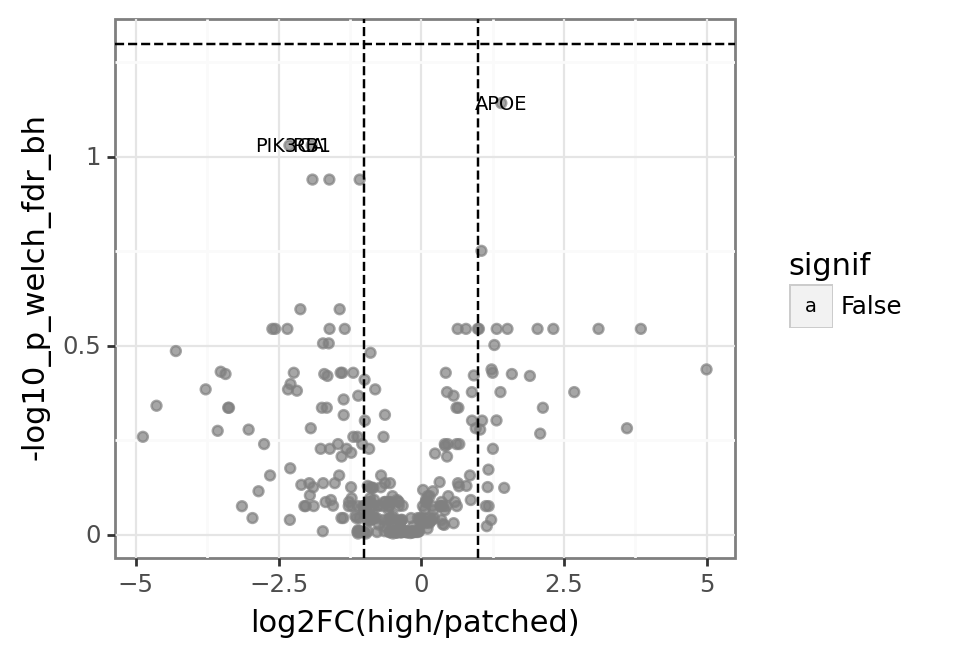


Could not run all against all others


/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 288 rows containing missing values.


In [24]:
all_tmp=EMT_diff(adatas_combined,obs_mal_combined,"merfish_clean",["Macrophage"])
all_res=pd.concat([all_res,all_tmp[3]])
fc_res=pd.concat([fc_res,all_tmp[4]])

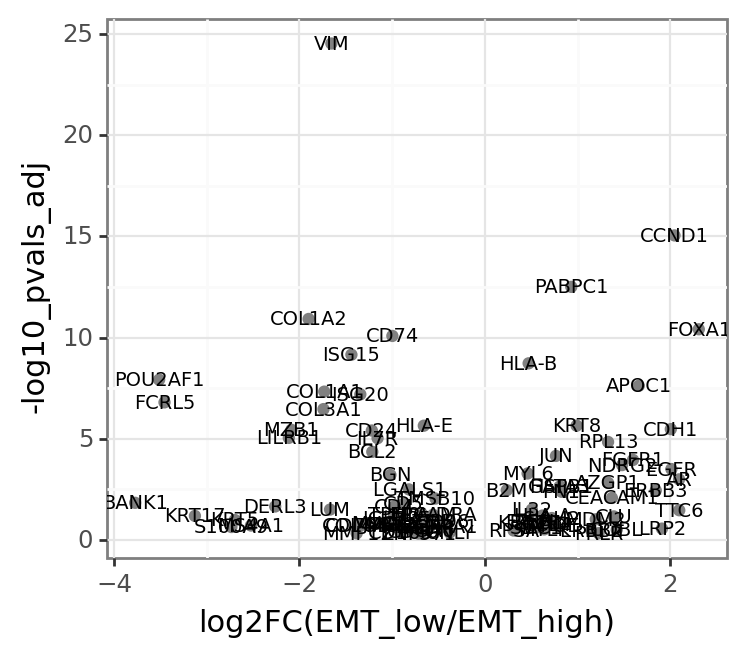


EMT_phenotype  sample            
high           HTAPP-514-SMP-6760    816
               HTAPP-878-SMP-7149    499
low            HTAPP-982-SMP-7629    511
               HTAPP-313-SMP-932     490
               HTAPP-812-SMP-8239    146
               HTAPP-880-SMP-7179     19
patched        HTAPP-944-SMP-7479    971
               HTAPP-853-SMP-4381     93
Name: count, dtype: int64


/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 286 rows containing missing values.


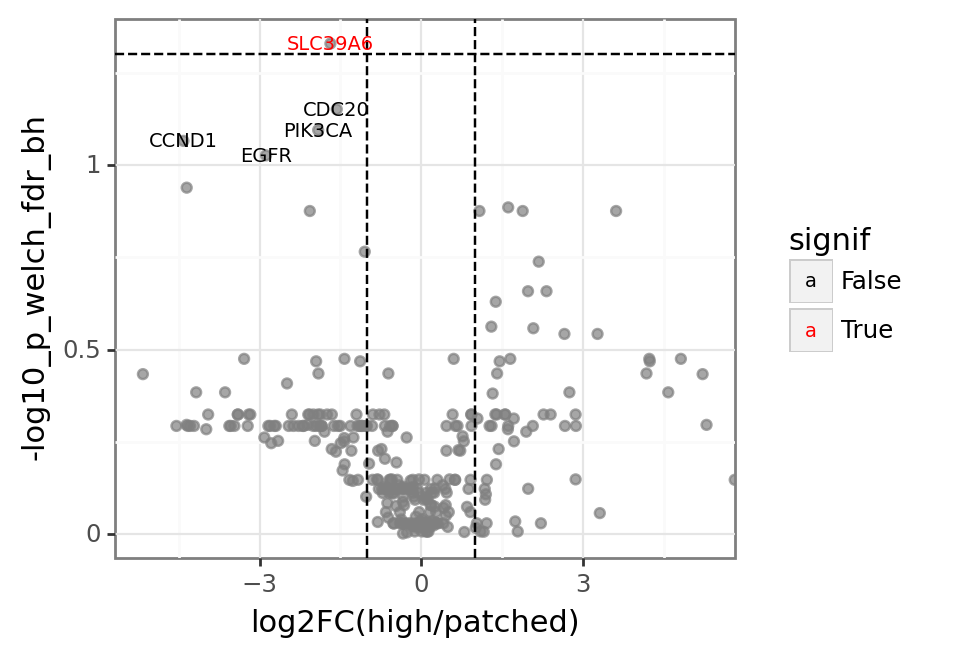

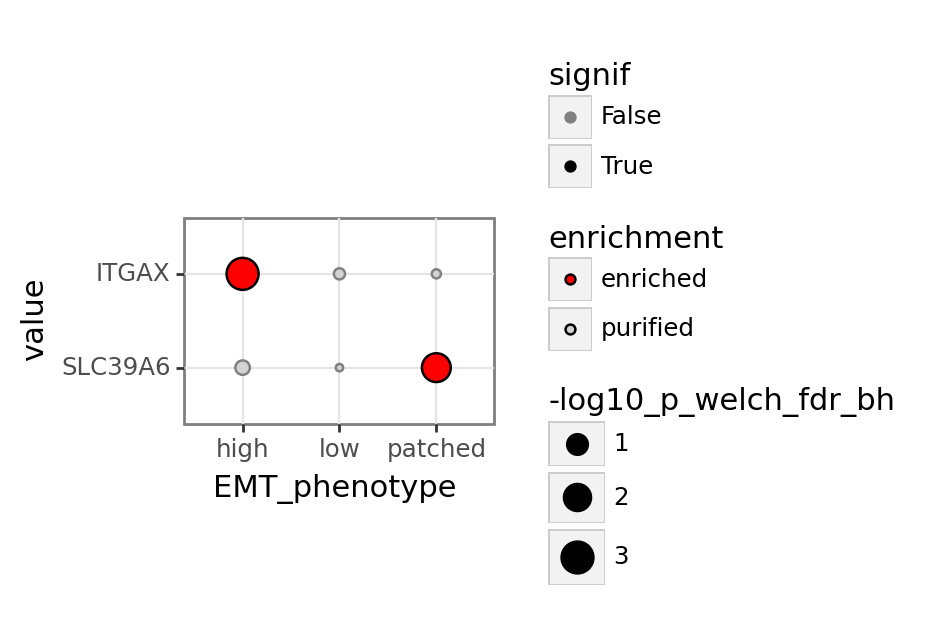

/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 286 rows containing missing values.


In [25]:
all_tmp=EMT_diff(adatas_combined,obs_mal_combined,"merfish_clean",["T","NK"])
all_res=pd.concat([all_res,all_tmp[3]])
fc_res=pd.concat([fc_res,all_tmp[4]])

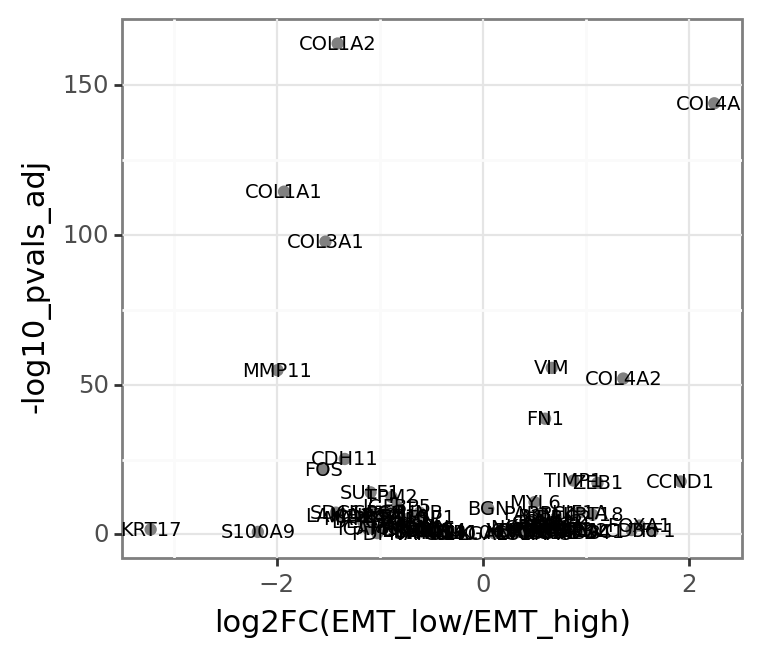


EMT_phenotype  sample            
high           HTAPP-878-SMP-7149    3639
               HTAPP-514-SMP-6760    2205
low            HTAPP-313-SMP-932      684
               HTAPP-982-SMP-7629     600
               HTAPP-812-SMP-8239     350
               HTAPP-880-SMP-7179     134
patched        HTAPP-944-SMP-7479     773
               HTAPP-917-SMP-4531     367
               HTAPP-853-SMP-4381     192
Name: count, dtype: int64


/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 281 rows containing missing values.


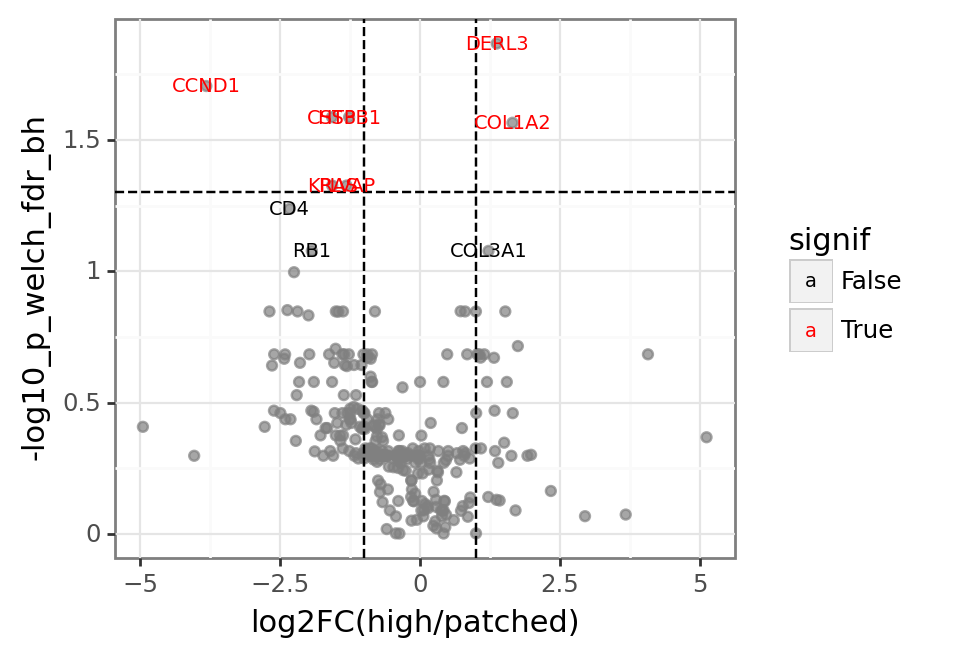

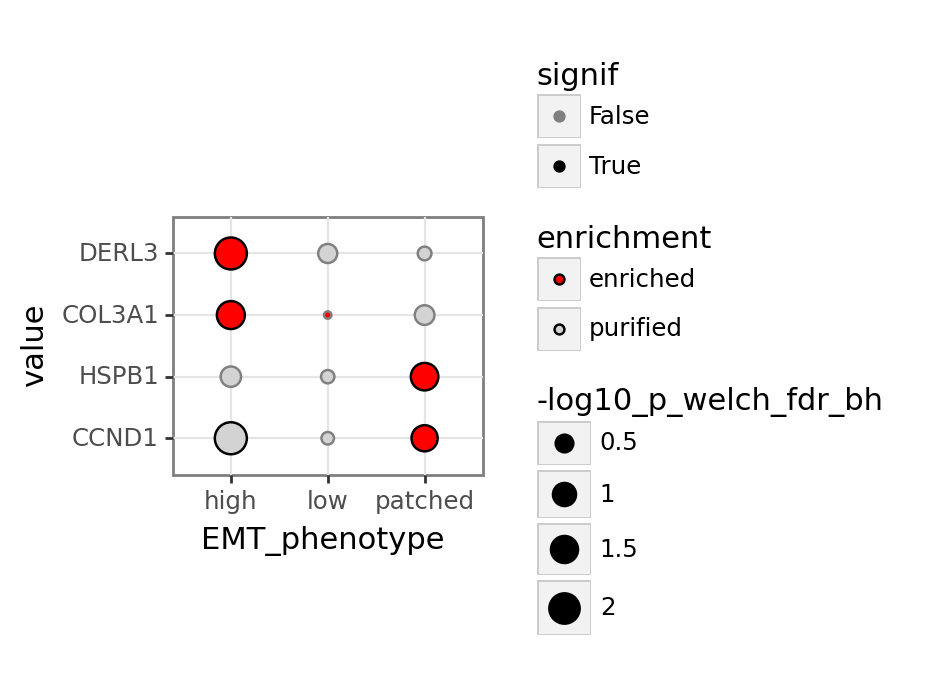

/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 281 rows containing missing values.


In [26]:
all_tmp=EMT_diff(adatas_combined,obs_mal_combined,"merfish_clean",["Fibroblast"])
all_res=pd.concat([all_res,all_tmp[3]])
fc_res=pd.concat([fc_res,all_tmp[4]])

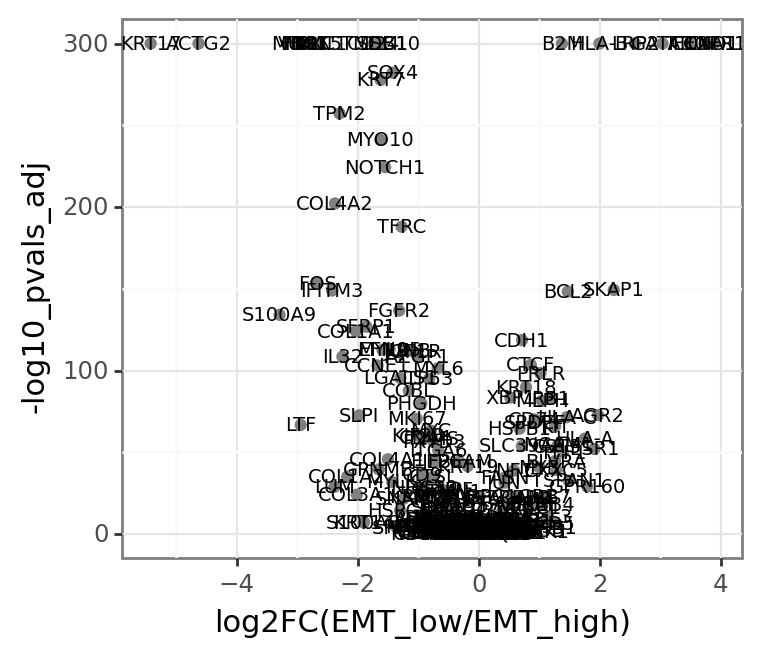


EMT_phenotype  sample            
high           HTAPP-514-SMP-6760     9349
               HTAPP-878-SMP-7149     2631
low            HTAPP-982-SMP-7629     8442
               HTAPP-313-SMP-932      6539
               HTAPP-880-SMP-7179     3463
               HTAPP-812-SMP-8239     1806
patched        HTAPP-944-SMP-7479    16336
               HTAPP-917-SMP-4531    10630
               HTAPP-853-SMP-4381     2026
Name: count, dtype: int64


/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 274 rows containing missing values.


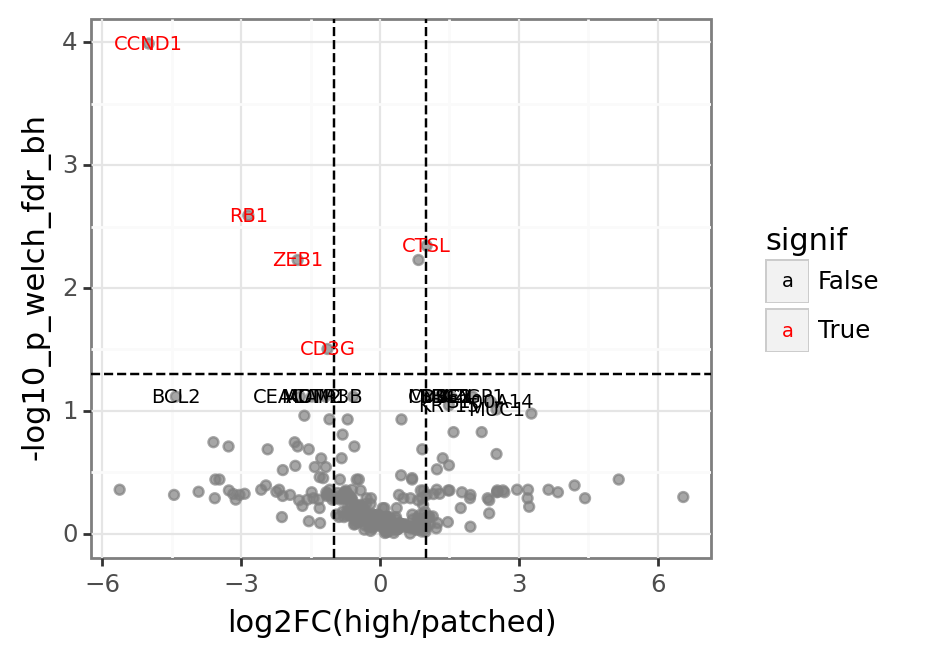

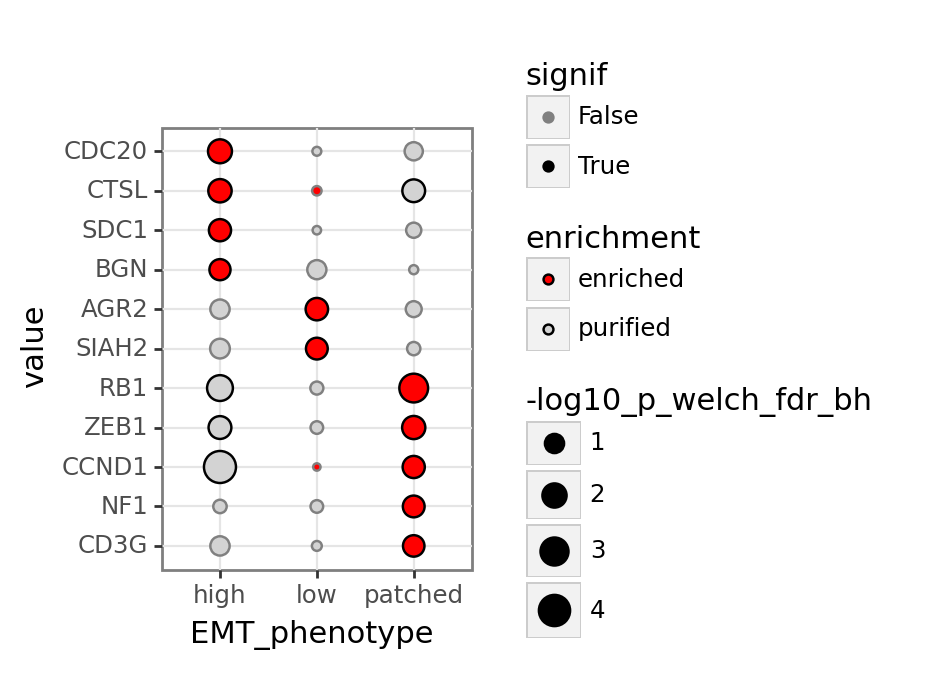

/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 274 rows containing missing values.


In [27]:
all_tmp=EMT_diff(adatas_combined,obs_mal_combined,"merfish",["MBC","MBC_stem-like","MBC_neuronal"])
all_res=pd.concat([all_res,all_tmp[3]])
fc_res=pd.concat([fc_res,all_tmp[4]])

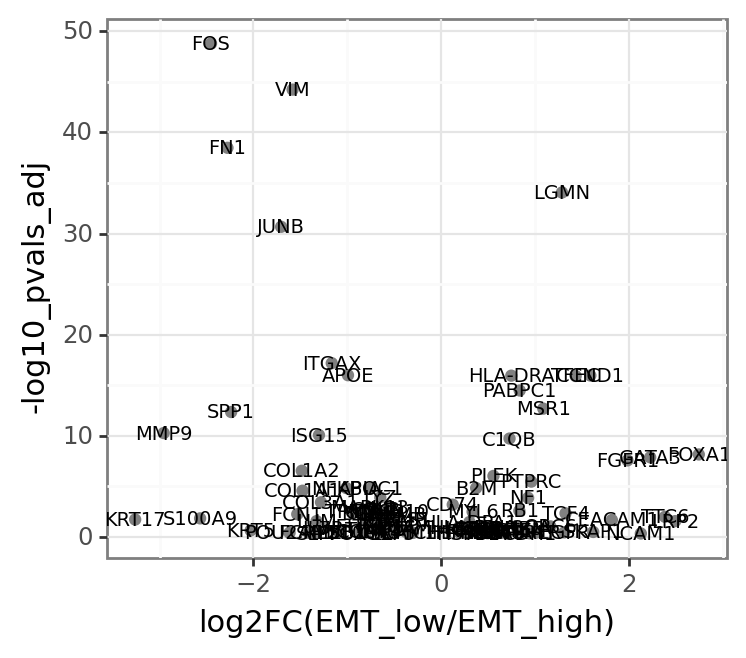


EMT_phenotype  sample            
high           HTAPP-514-SMP-6760    1664
               HTAPP-878-SMP-7149     627
low            HTAPP-313-SMP-932      724
               HTAPP-982-SMP-7629     667
               HTAPP-812-SMP-8239     198
               HTAPP-880-SMP-7179      72
patched        HTAPP-944-SMP-7479     965
               HTAPP-917-SMP-4531     457
               HTAPP-853-SMP-4381      43
Name: count, dtype: int64


/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 288 rows containing missing values.


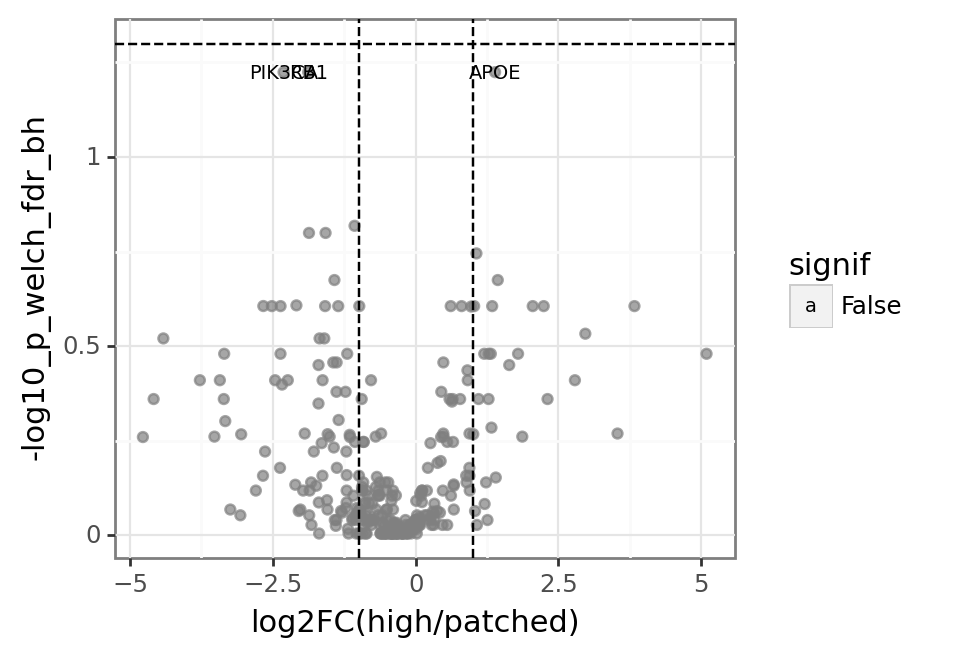


Could not run all against all others


/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 288 rows containing missing values.


In [28]:
all_tmp=EMT_diff(adatas_combined,obs_mal_combined,"merfish",["Macrophage"])
all_res=pd.concat([all_res,all_tmp[3]])
fc_res=pd.concat([fc_res,all_tmp[4]])

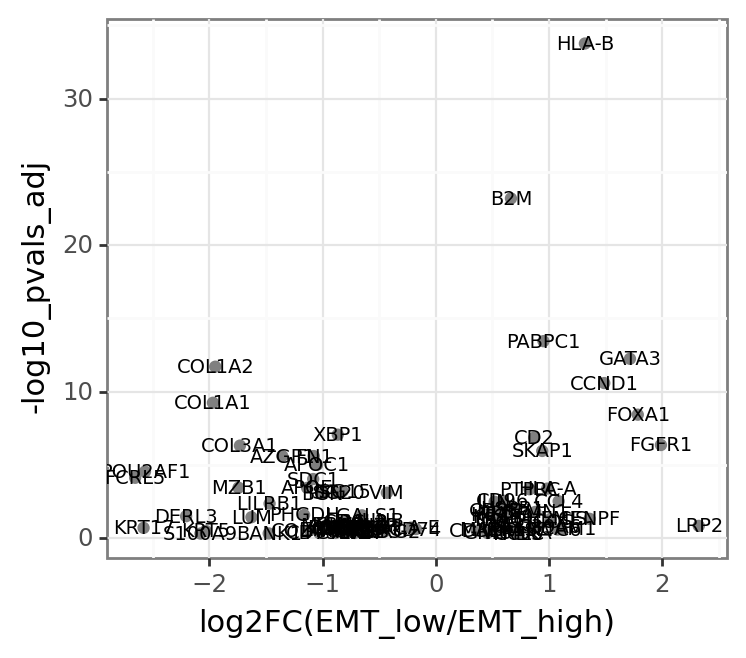


EMT_phenotype  sample            
high           HTAPP-514-SMP-6760    824
               HTAPP-878-SMP-7149    520
low            HTAPP-982-SMP-7629    842
               HTAPP-313-SMP-932     513
               HTAPP-812-SMP-8239    166
               HTAPP-880-SMP-7179     19
patched        HTAPP-944-SMP-7479    970
               HTAPP-853-SMP-4381     98
Name: count, dtype: int64


/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 291 rows containing missing values.


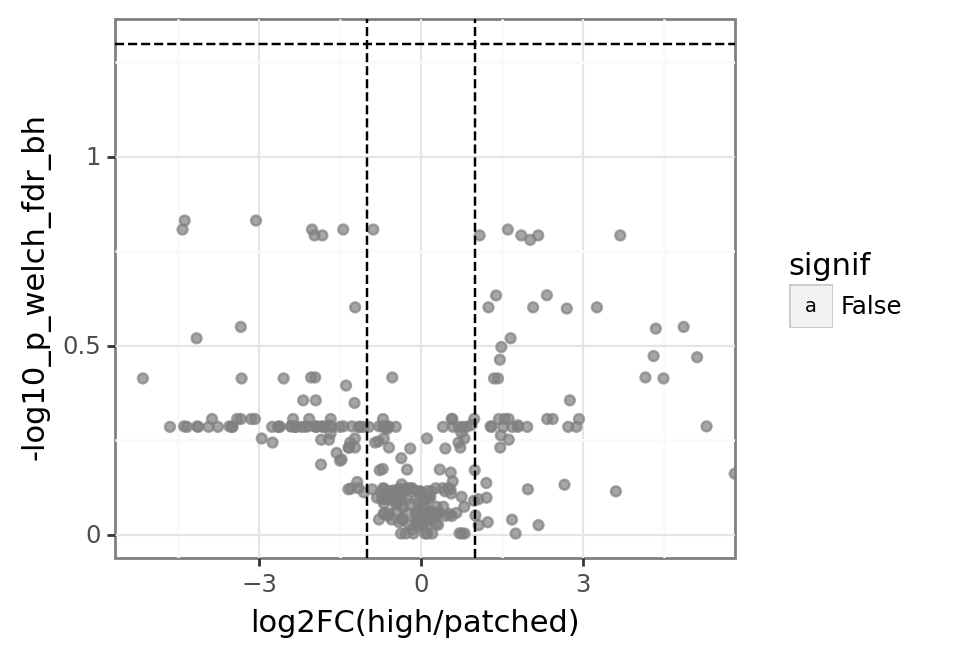

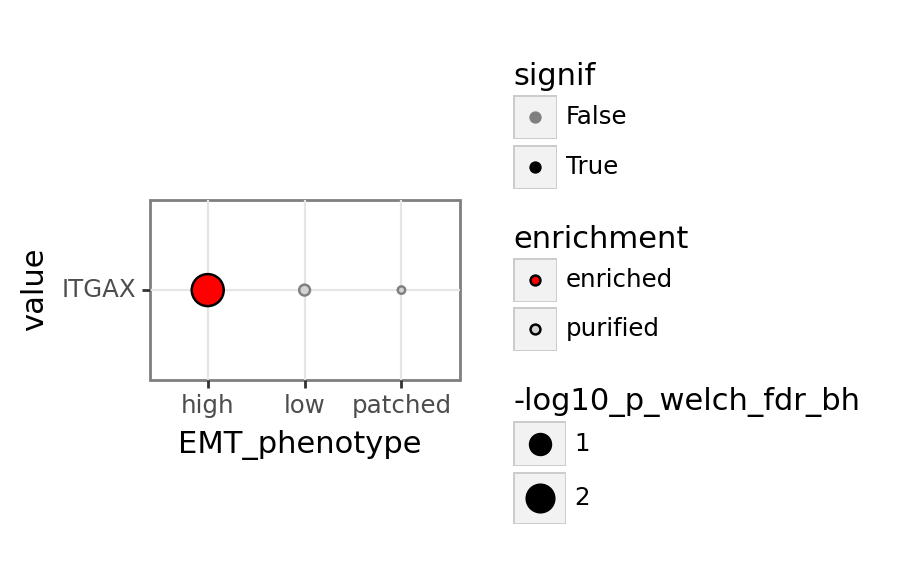

/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 291 rows containing missing values.


In [29]:
all_tmp=EMT_diff(adatas_combined,obs_mal_combined,"merfish",["T","NK"])
all_res=pd.concat([all_res,all_tmp[3]])
fc_res=pd.concat([fc_res,all_tmp[4]])

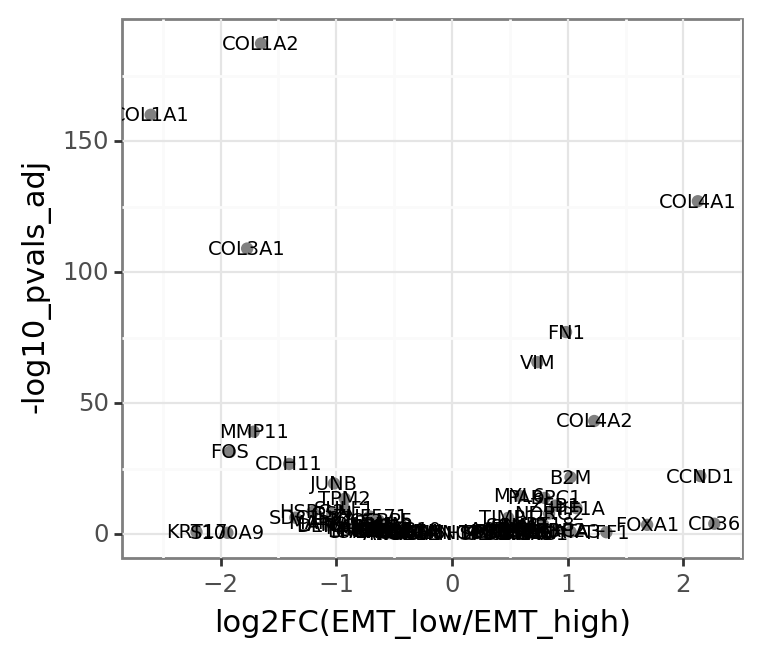


EMT_phenotype  sample            
high           HTAPP-878-SMP-7149    3787
               HTAPP-514-SMP-6760    2235
low            HTAPP-982-SMP-7629     734
               HTAPP-313-SMP-932      688
               HTAPP-812-SMP-8239     368
               HTAPP-880-SMP-7179     134
patched        HTAPP-944-SMP-7479     788
               HTAPP-917-SMP-4531     428
               HTAPP-853-SMP-4381     199
Name: count, dtype: int64


/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 281 rows containing missing values.


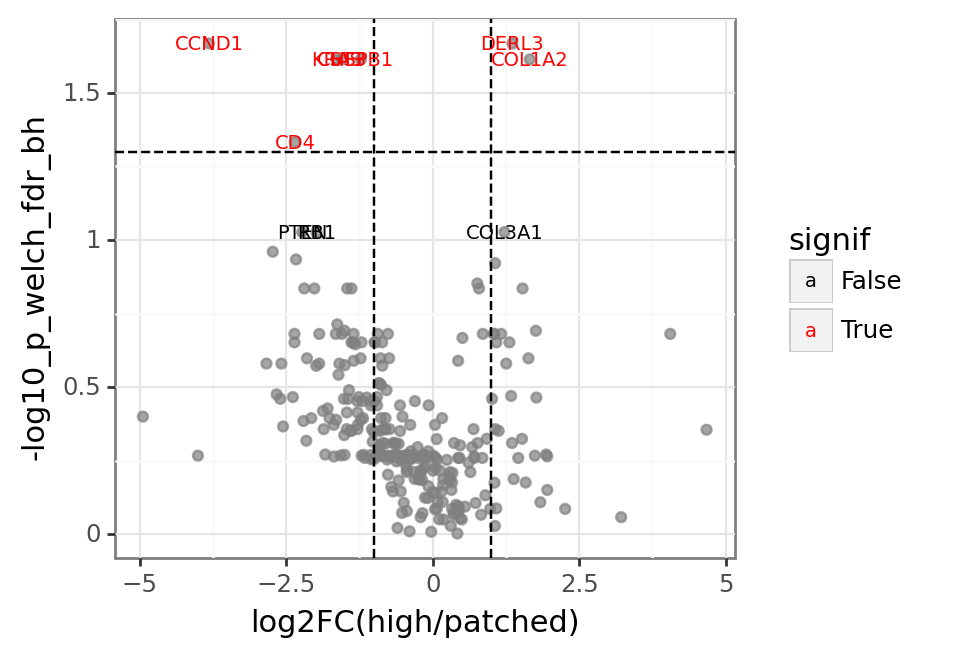

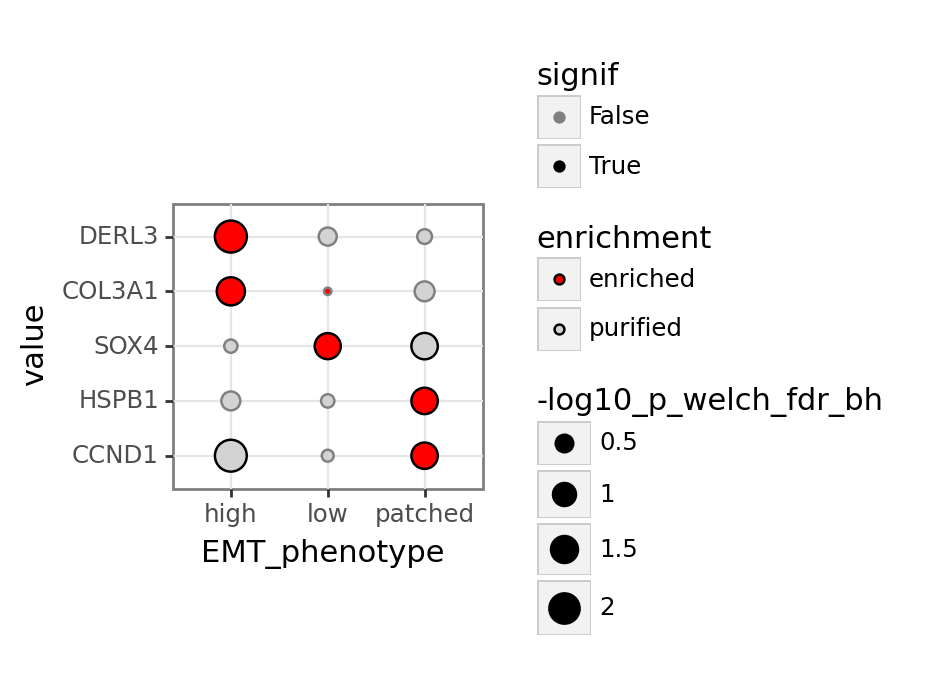

/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 281 rows containing missing values.


In [30]:
all_tmp=EMT_diff(adatas_combined,obs_mal_combined,"merfish",["Fibroblast"])
all_res=pd.concat([all_res,all_tmp[3]])
fc_res=pd.concat([fc_res,all_tmp[4]])

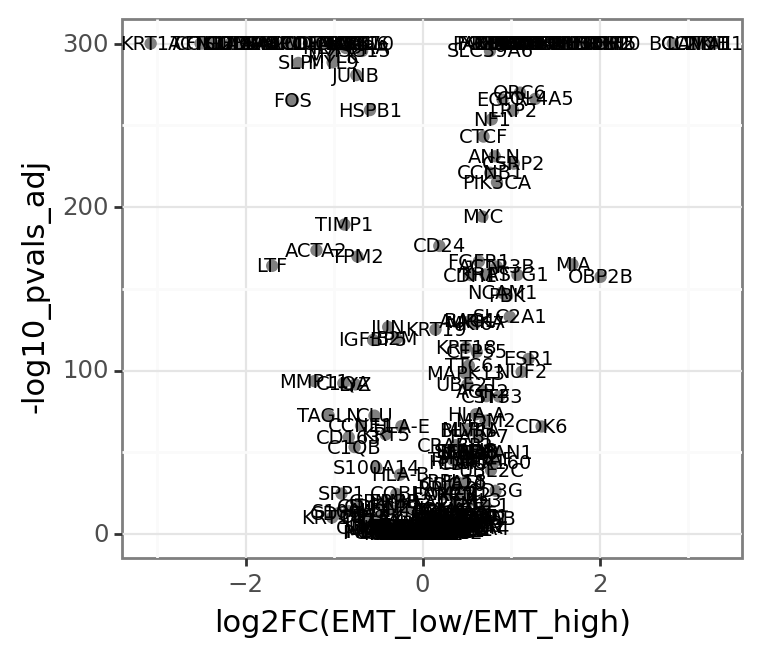


EMT_phenotype  sample            
high           HTAPP-514-SMP-6760    38634
               HTAPP-878-SMP-7149     9143
low            HTAPP-982-SMP-7629    31648
               HTAPP-313-SMP-932     28222
               HTAPP-880-SMP-7179    11101
               HTAPP-812-SMP-8239    10706
patched        HTAPP-917-SMP-4531    39929
               HTAPP-944-SMP-7479    37663
               HTAPP-853-SMP-4381     8939
Name: count, dtype: int64


/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 275 rows containing missing values.


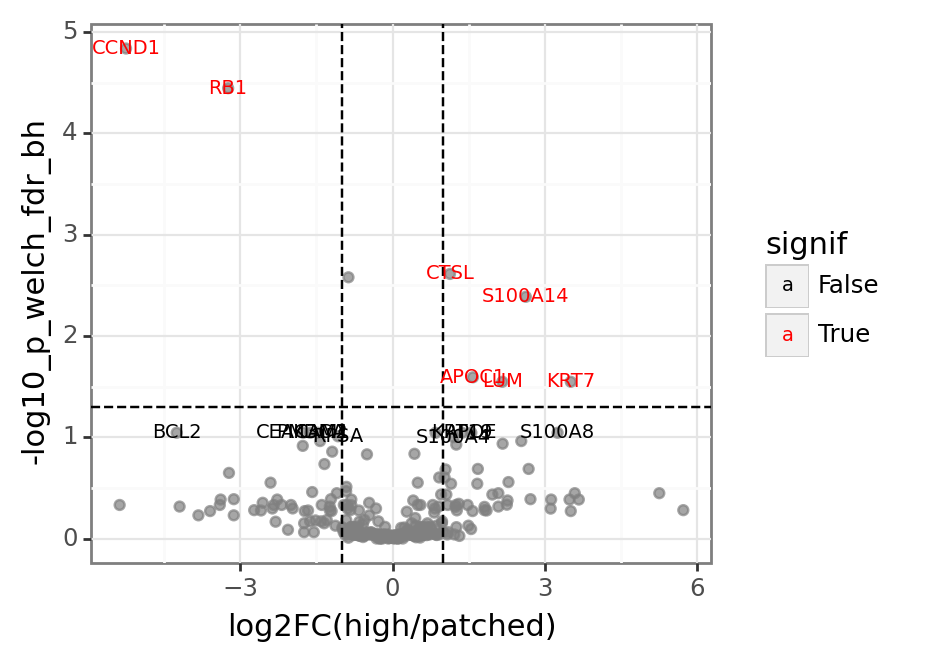

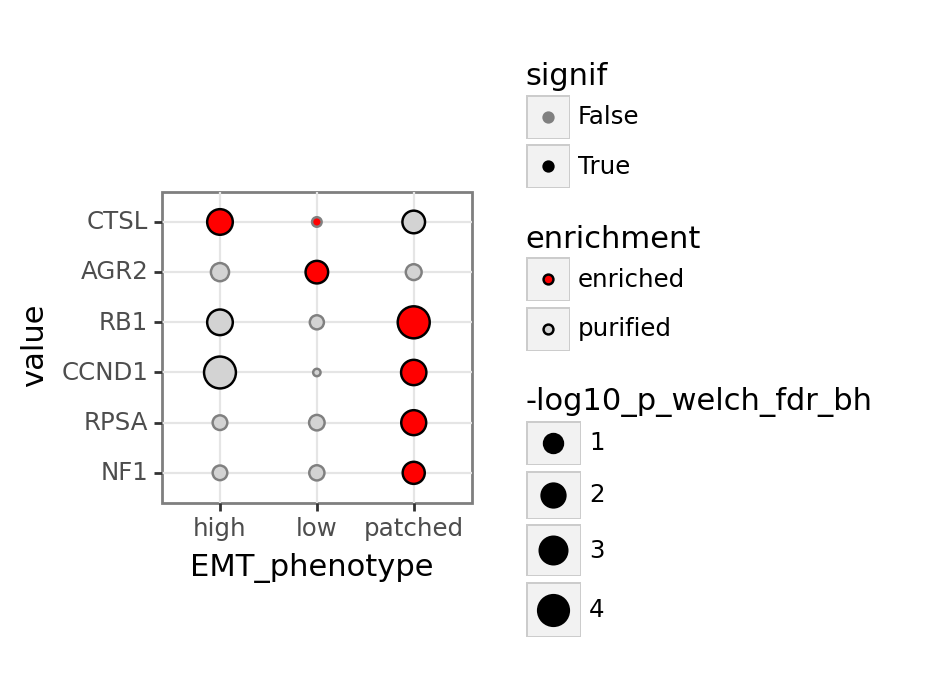

/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 275 rows containing missing values.


In [31]:
all_tmp=EMT_diff(adatas_combined,obs_mal_combined,"merfish_bin",["MBC","MBC_stem-like","MBC_neuronal"])
all_res=pd.concat([all_res,all_tmp[3]])
fc_res=pd.concat([fc_res,all_tmp[4]])

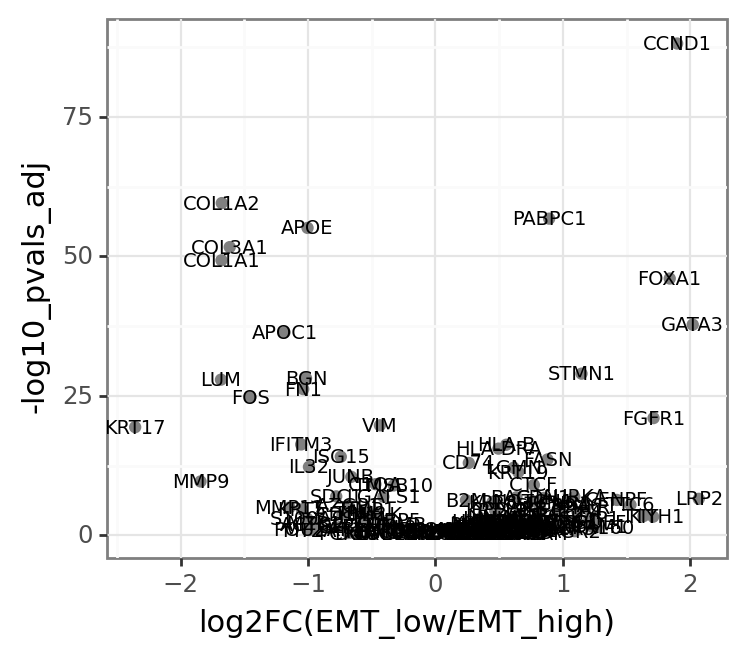


EMT_phenotype  sample            
high           HTAPP-514-SMP-6760    5627
               HTAPP-878-SMP-7149    1156
low            HTAPP-313-SMP-932     3312
               HTAPP-982-SMP-7629    2965
               HTAPP-812-SMP-8239    1077
               HTAPP-880-SMP-7179     121
patched        HTAPP-917-SMP-4531    1559
               HTAPP-944-SMP-7479    1446
               HTAPP-853-SMP-4381     315
Name: count, dtype: int64


/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 283 rows containing missing values.


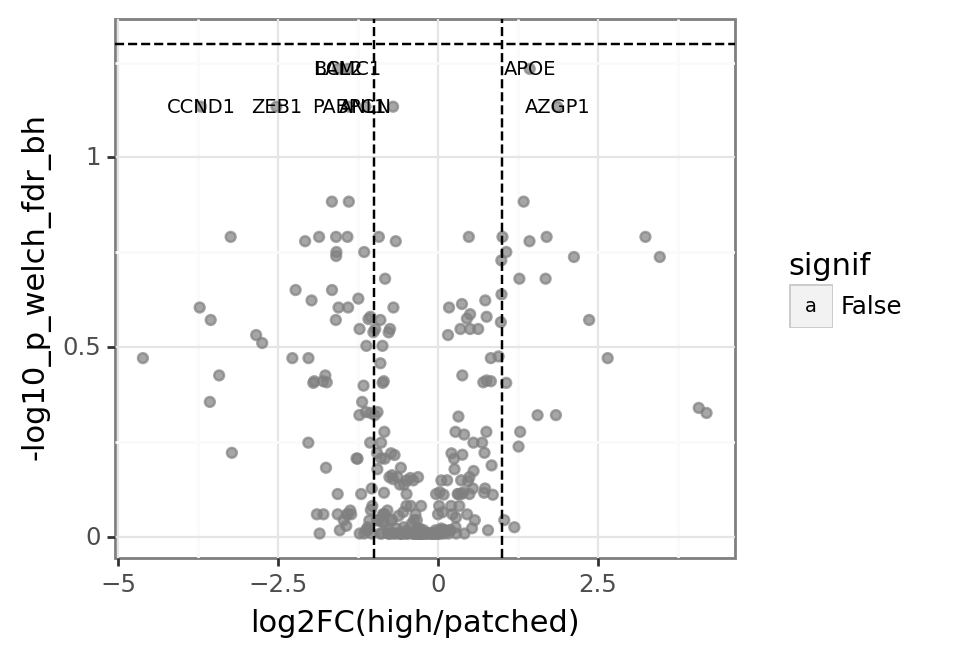

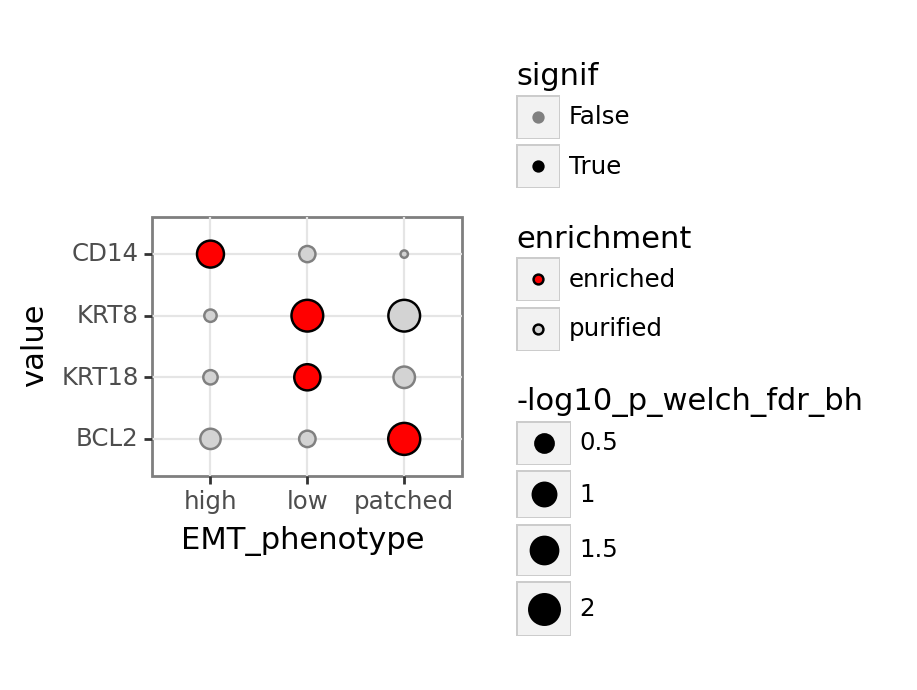

/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 283 rows containing missing values.


In [32]:
all_tmp=EMT_diff(adatas_combined,obs_mal_combined,"merfish_bin",["Macrophage"])
all_res=pd.concat([all_res,all_tmp[3]])
fc_res=pd.concat([fc_res,all_tmp[4]])

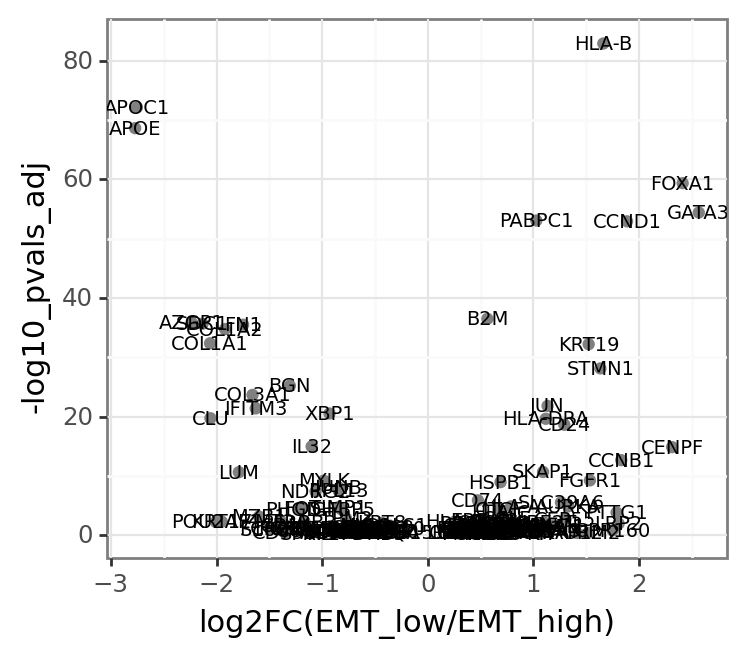


EMT_phenotype  sample            
high           HTAPP-514-SMP-6760    1574
               HTAPP-878-SMP-7149    1422
low            HTAPP-982-SMP-7629    2700
               HTAPP-313-SMP-932     1090
               HTAPP-812-SMP-8239     632
               HTAPP-880-SMP-7179      57
patched        HTAPP-944-SMP-7479    1831
               HTAPP-853-SMP-4381     259
Name: count, dtype: int64


/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 289 rows containing missing values.


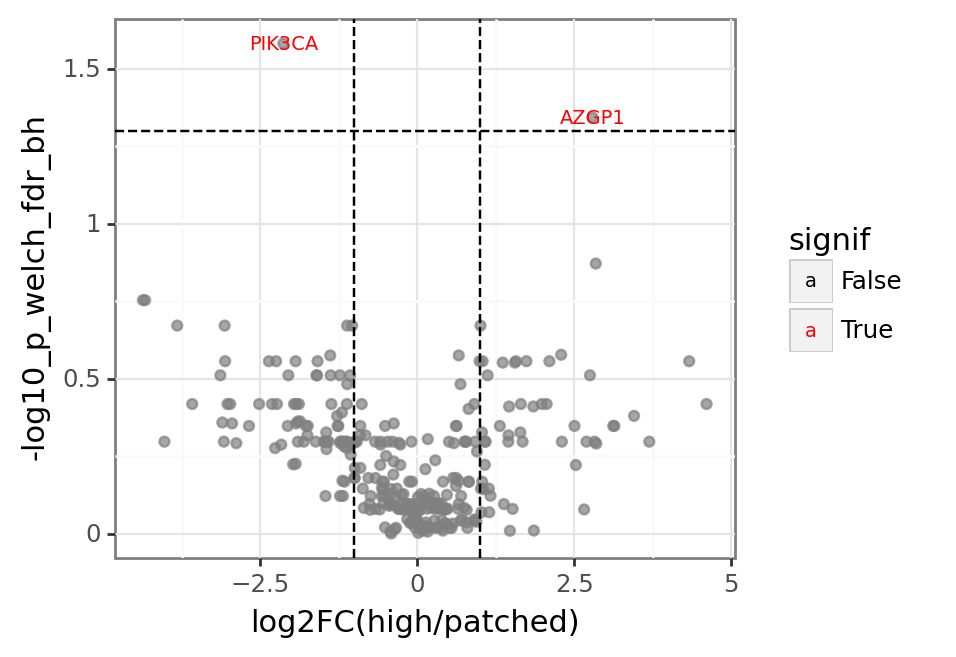

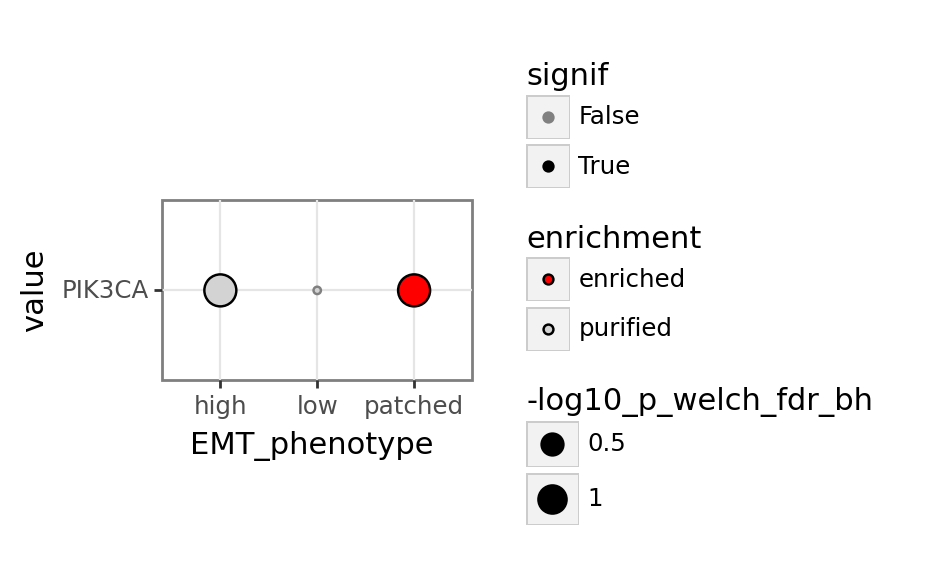

/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 289 rows containing missing values.


In [33]:
all_tmp=EMT_diff(adatas_combined,obs_mal_combined,"merfish_bin",["T","NK"])
all_res=pd.concat([all_res,all_tmp[3]])
fc_res=pd.concat([fc_res,all_tmp[4]])

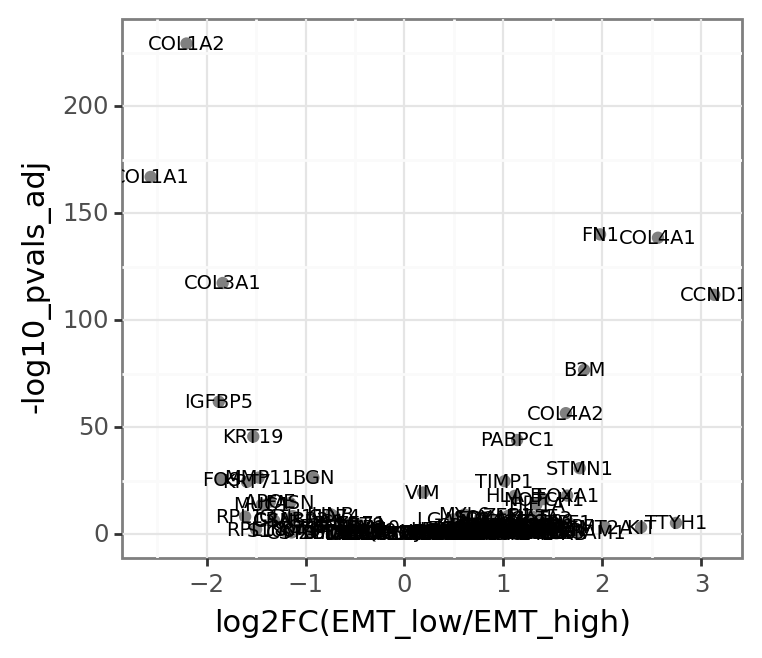


EMT_phenotype  sample            
high           HTAPP-878-SMP-7149    19244
               HTAPP-514-SMP-6760     8309
low            HTAPP-982-SMP-7629     2154
               HTAPP-313-SMP-932      1220
               HTAPP-812-SMP-8239     1089
               HTAPP-880-SMP-7179      235
patched        HTAPP-917-SMP-4531     1341
               HTAPP-944-SMP-7479     1153
               HTAPP-853-SMP-4381      468
Name: count, dtype: int64


/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 275 rows containing missing values.


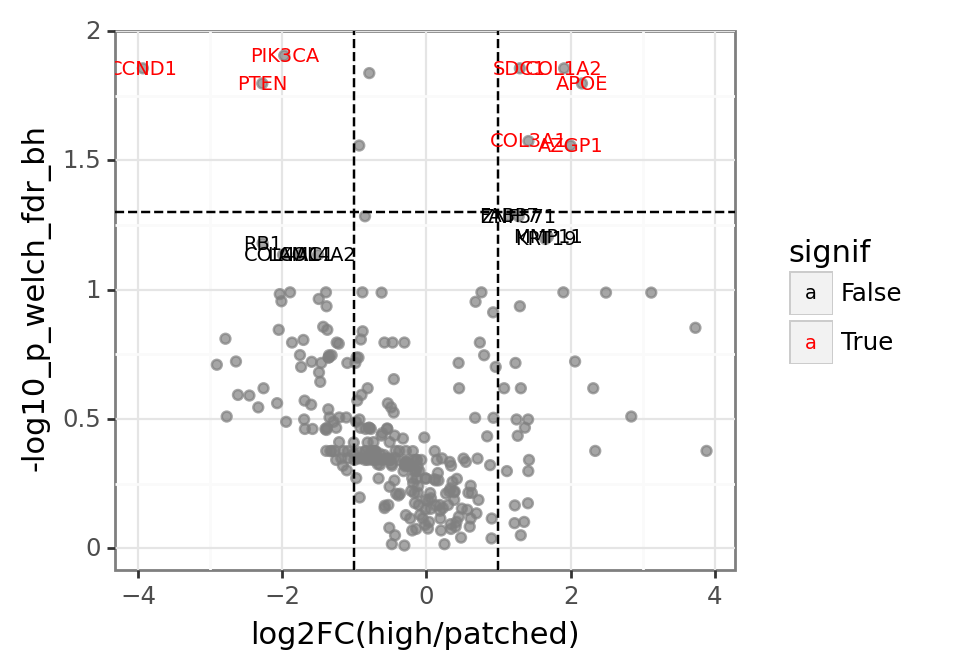

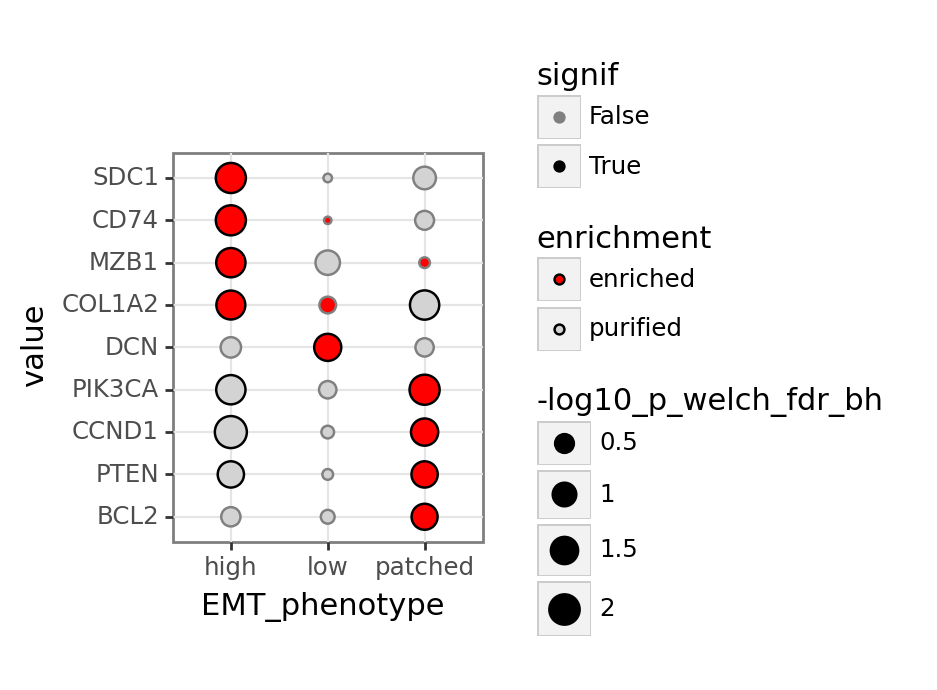

/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 275 rows containing missing values.


In [34]:
all_tmp=EMT_diff(adatas_combined,obs_mal_combined,"merfish_bin",["Fibroblast"])
all_res=pd.concat([all_res,all_tmp[3]])
fc_res=pd.concat([fc_res,all_tmp[4]])

EMT_phenotype  sample            
high           HTAPP-514-SMP-6760    12062
               HTAPP-878-SMP-7149     3254
low            HTAPP-880-SMP-7179    10221
               HTAPP-313-SMP-932      7301
               HTAPP-982-SMP-7629     6017
               HTAPP-812-SMP-8239     2372
patched        HTAPP-917-SMP-4531    10760
               HTAPP-944-SMP-7479     3833
               HTAPP-853-SMP-4381     2972
Name: count, dtype: int64
Filtering genes


/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 1 rows containing missing values.
/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 11993 rows containing missing values.


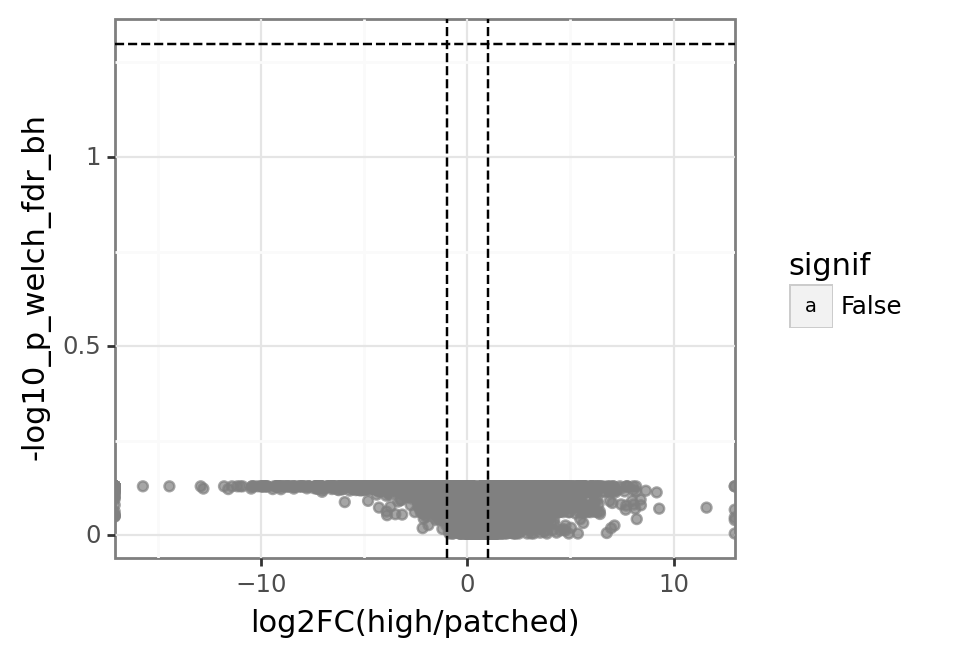

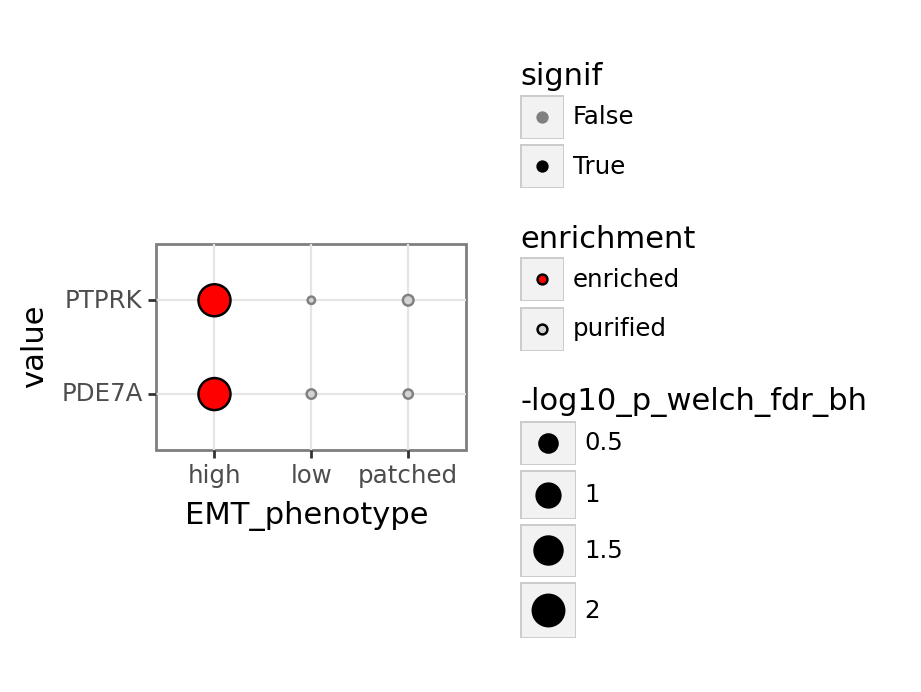

/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 1 rows containing missing values.
/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 11993 rows containing missing values.


In [35]:
all_tmp=EMT_diff(adatas_combined,obs_mal_combined,"scRNAseq",["MBC","MBC_stem-like","MBC_neuronal"])
all_res=pd.concat([all_res,all_tmp[3]])
fc_res=pd.concat([fc_res,all_tmp[4]])
#no signif

EMT_phenotype  sample            
high           HTAPP-514-SMP-6760    3009
               HTAPP-878-SMP-7149     784
low            HTAPP-313-SMP-932      979
               HTAPP-812-SMP-8239     614
               HTAPP-982-SMP-7629     440
               HTAPP-880-SMP-7179     177
patched        HTAPP-944-SMP-7479     409
               HTAPP-917-SMP-4531     221
               HTAPP-853-SMP-4381     116
Name: count, dtype: int64
Filtering genes


/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 5699 rows containing missing values.


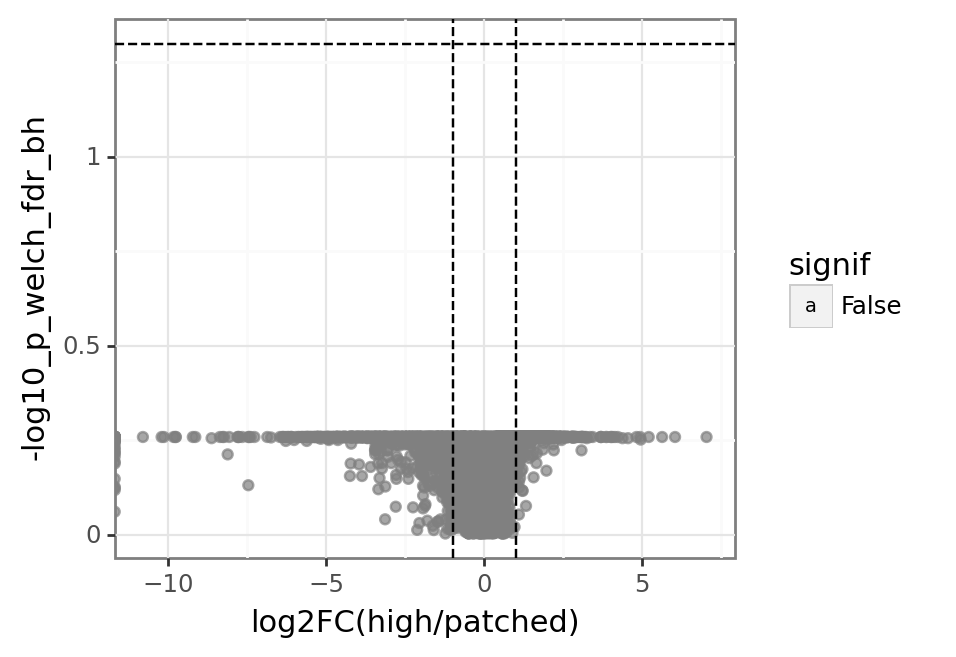


Could not run all against all others


/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 5699 rows containing missing values.


In [36]:
all_tmp=EMT_diff(adatas_combined,obs_mal_combined,"scRNAseq",["Macrophage"])
all_res=pd.concat([all_res,all_tmp[3]])
fc_res=pd.concat([fc_res,all_tmp[4]])
#no signif

EMT_phenotype  sample            
high           HTAPP-514-SMP-6760    1801
               HTAPP-878-SMP-7149    1070
low            HTAPP-313-SMP-932     2625
               HTAPP-812-SMP-8239    1472
               HTAPP-982-SMP-7629     483
               HTAPP-880-SMP-7179      99
patched        HTAPP-853-SMP-4381    1265
               HTAPP-944-SMP-7479     179
Name: count, dtype: int64
Filtering genes


/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 3850 rows containing missing values.


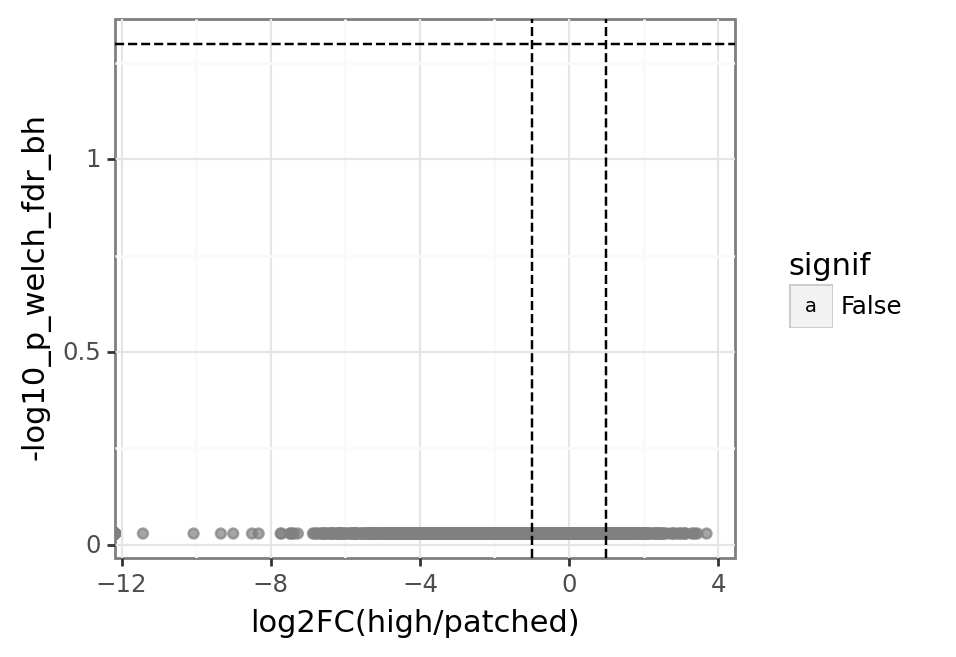


Could not run all against all others


/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 3850 rows containing missing values.


In [37]:
all_tmp=EMT_diff(adatas_combined,obs_mal_combined,"scRNAseq",["T","NK"])
all_res=pd.concat([all_res,all_tmp[3]])
fc_res=pd.concat([fc_res,all_tmp[4]])
#no signif

EMT_phenotype  sample            
high           HTAPP-878-SMP-7149    3250
               HTAPP-514-SMP-6760    2233
low            HTAPP-812-SMP-8239     418
               HTAPP-313-SMP-932      341
               HTAPP-880-SMP-7179     122
               HTAPP-982-SMP-7629     112
patched        HTAPP-917-SMP-4531      90
               HTAPP-853-SMP-4381      74
               HTAPP-944-SMP-7479       9
Name: count, dtype: int64
Filtering genes


/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 8225 rows containing missing values.


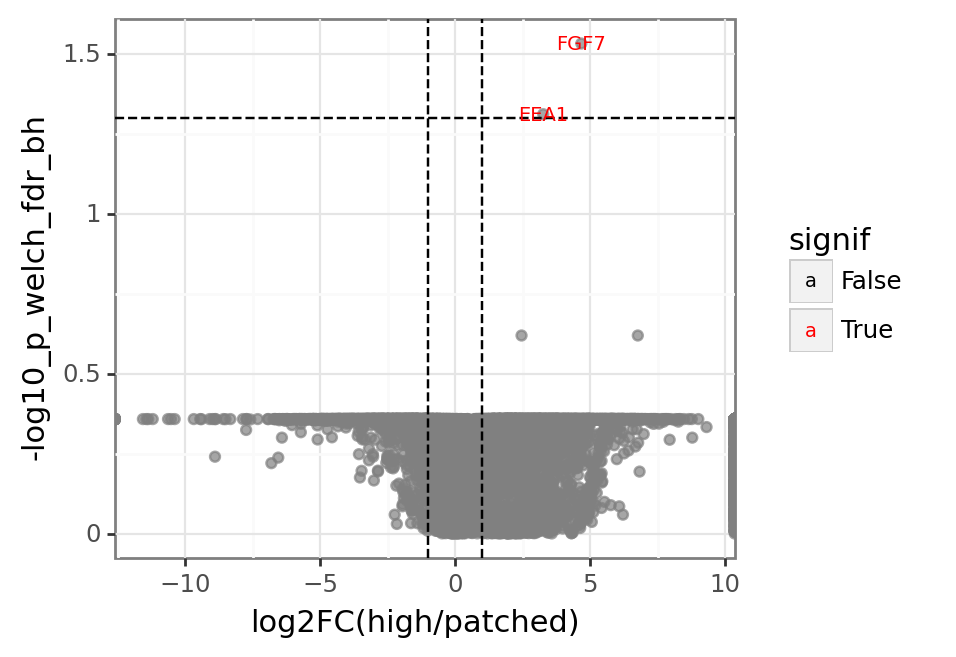

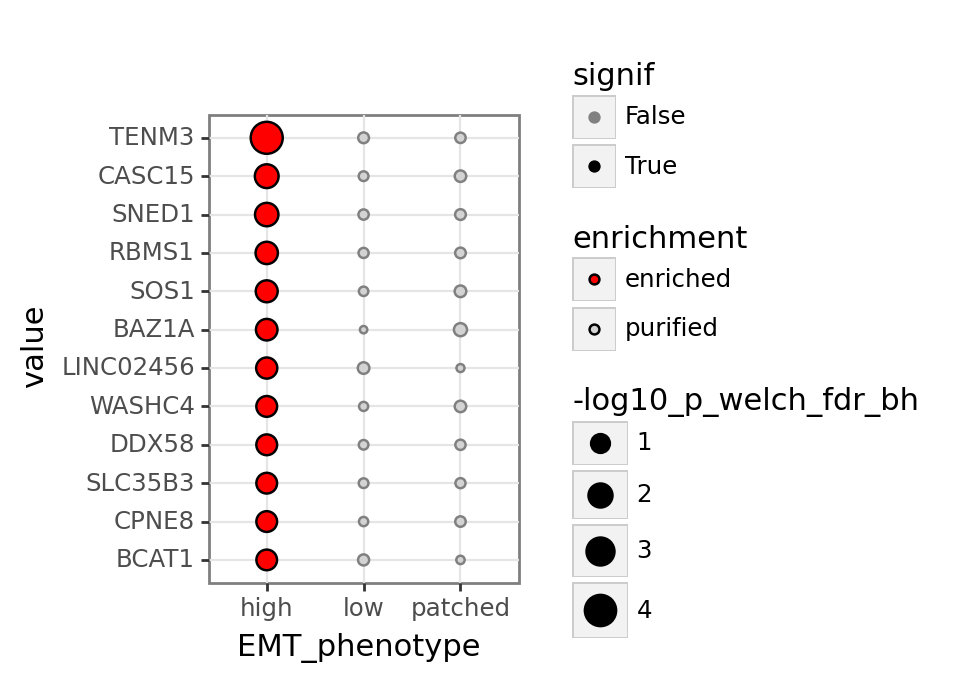

/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 8225 rows containing missing values.


In [38]:
all_tmp=EMT_diff(adatas_combined,obs_mal_combined,"scRNAseq",["Fibroblast"])
all_res=pd.concat([all_res,all_tmp[3]])
fc_res=pd.concat([fc_res,all_tmp[4]])
#no signif

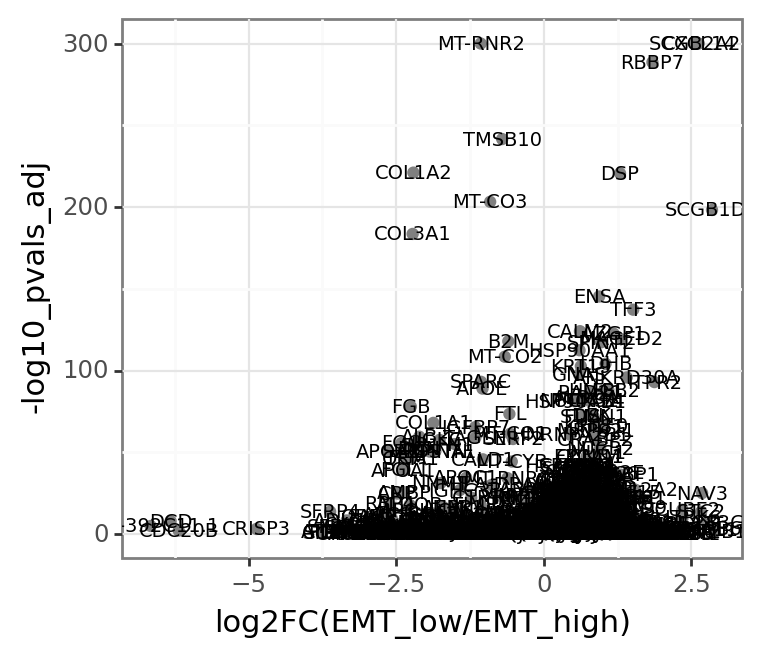


EMT_phenotype  sample            
high           HTAPP-514-SMP-6760    25978
               HTAPP-878-SMP-7149    10054
low            HTAPP-880-SMP-7179    20676
               HTAPP-313-SMP-932     10077
               HTAPP-812-SMP-8239     9130
               HTAPP-982-SMP-7629     7342
patched        HTAPP-853-SMP-4381     9580
               HTAPP-917-SMP-4531     8381
               HTAPP-944-SMP-7479     7797
Name: count, dtype: int64
Filtering genes


/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 865 rows containing missing values.


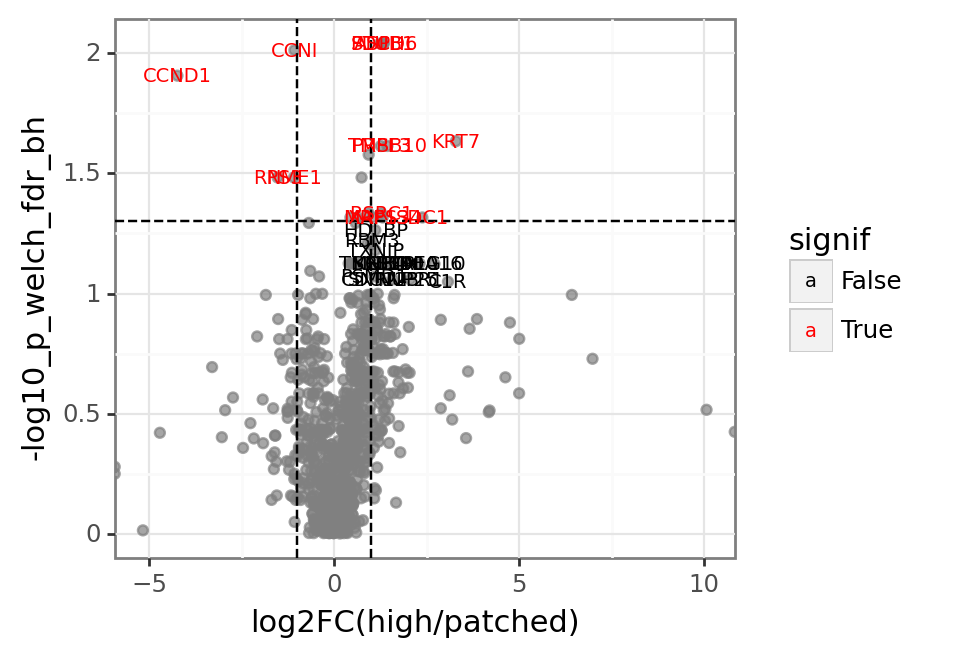

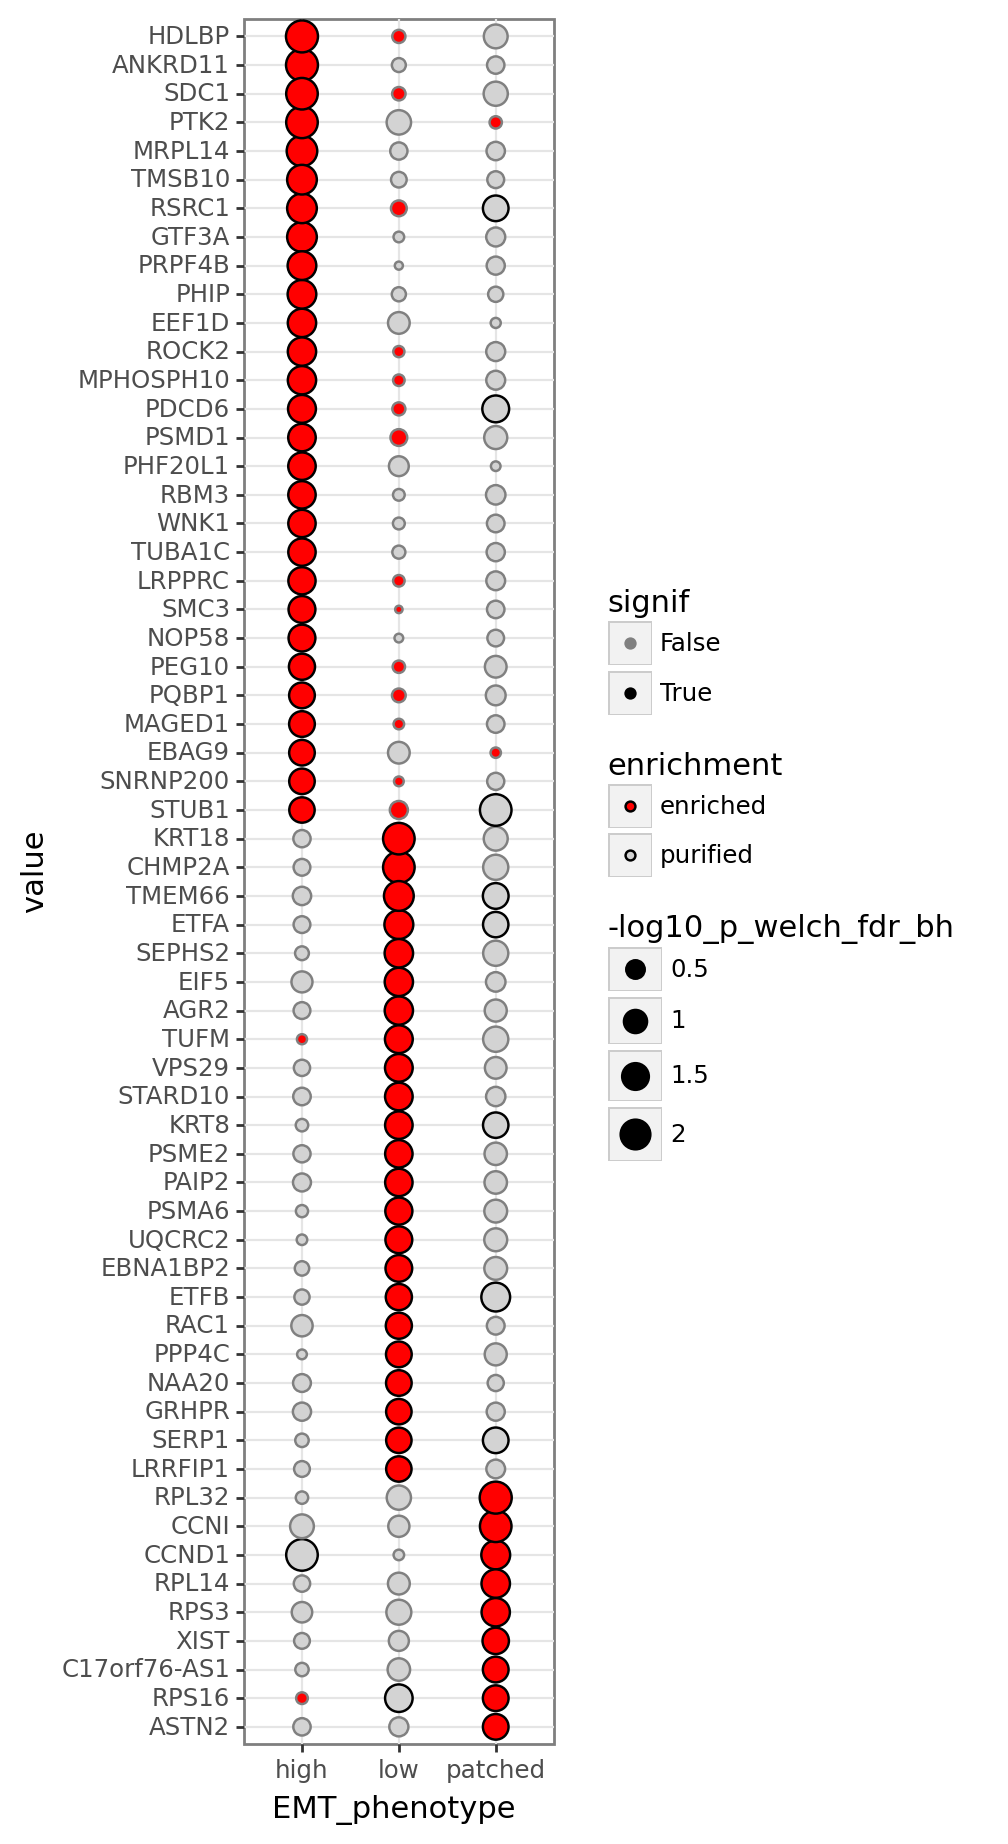

/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 865 rows containing missing values.


In [39]:
all_tmp=EMT_diff(adatas_combined,obs_mal_combined,"slide_seq",["MBC","MBC_stem-like","MBC_neuronal"])
all_res=pd.concat([all_res,all_tmp[3]])
fc_res=pd.concat([fc_res,all_tmp[4]])

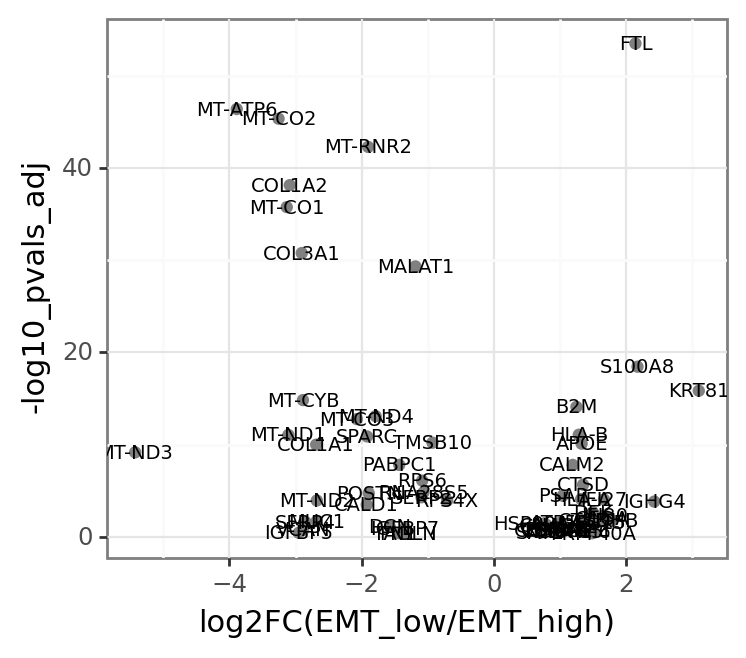


EMT_phenotype  sample            
high           HTAPP-878-SMP-7149    3645
               HTAPP-514-SMP-6760    1184
low            HTAPP-812-SMP-8239     773
               HTAPP-313-SMP-932      342
               HTAPP-880-SMP-7179     166
               HTAPP-982-SMP-7629     138
patched        HTAPP-853-SMP-4381     235
               HTAPP-917-SMP-4531      86
               HTAPP-944-SMP-7479      14
Name: count, dtype: int64
Filtering genes


/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 270 rows containing missing values.


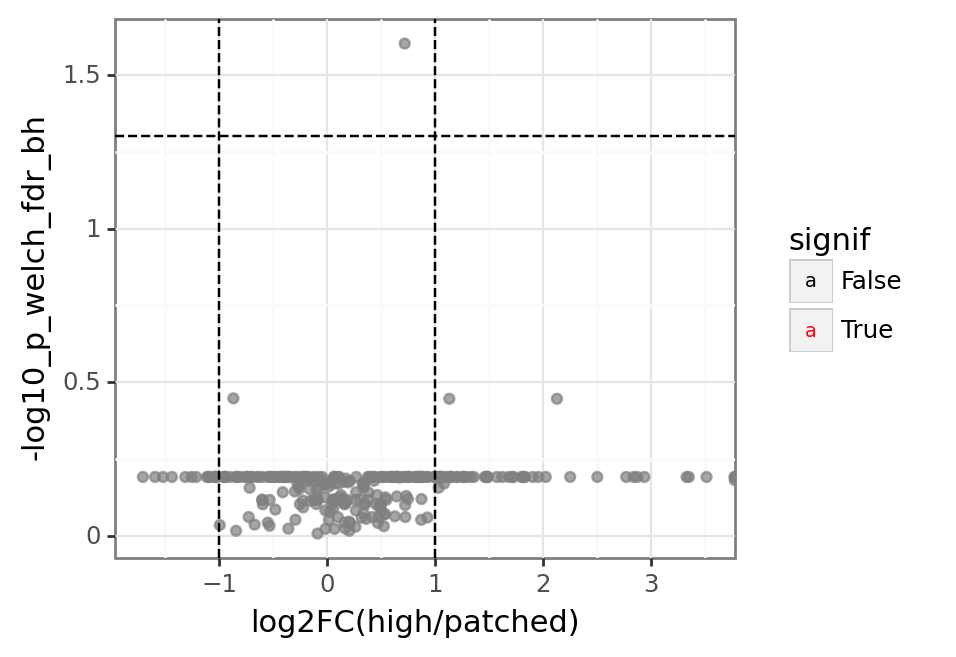

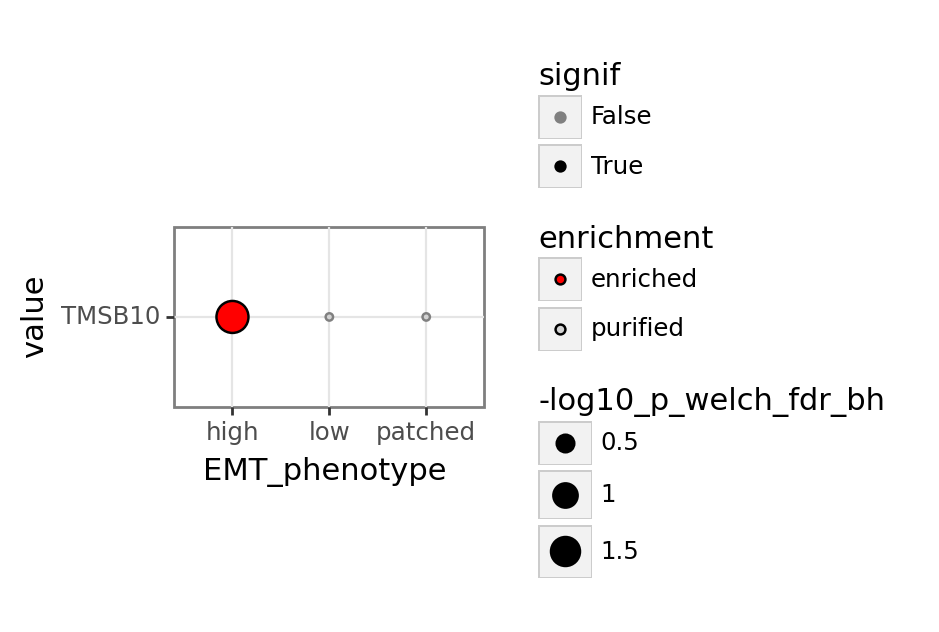

/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 270 rows containing missing values.


In [40]:
all_tmp=EMT_diff(adatas_combined,obs_mal_combined,"slide_seq",["Macrophage"])
all_res=pd.concat([all_res,all_tmp[3]])
fc_res=pd.concat([fc_res,all_tmp[4]])

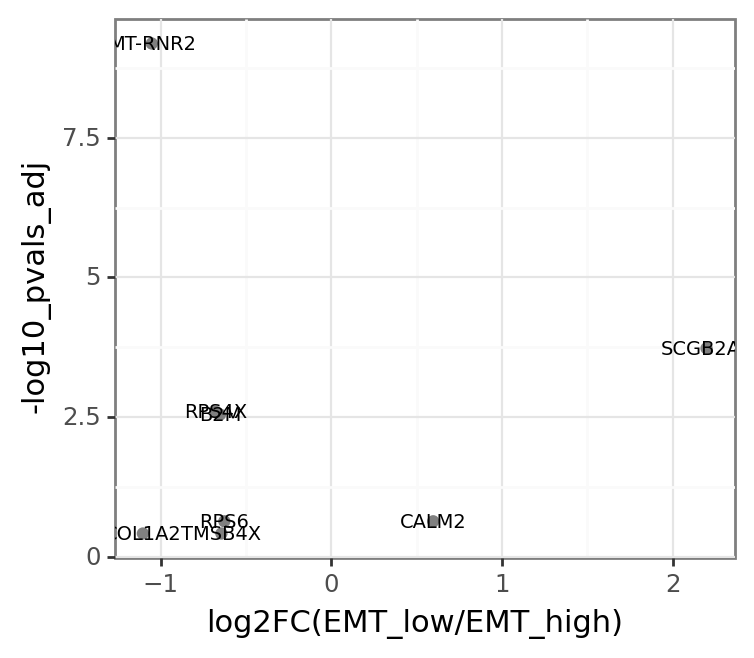


EMT_phenotype  sample            
high           HTAPP-514-SMP-6760    2586
               HTAPP-878-SMP-7149     594
low            HTAPP-880-SMP-7179     962
               HTAPP-812-SMP-8239     463
               HTAPP-313-SMP-932      336
               HTAPP-982-SMP-7629     305
patched        HTAPP-853-SMP-4381     931
               HTAPP-944-SMP-7479      16
Name: count, dtype: int64
Filtering genes


/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 205 rows containing missing values.


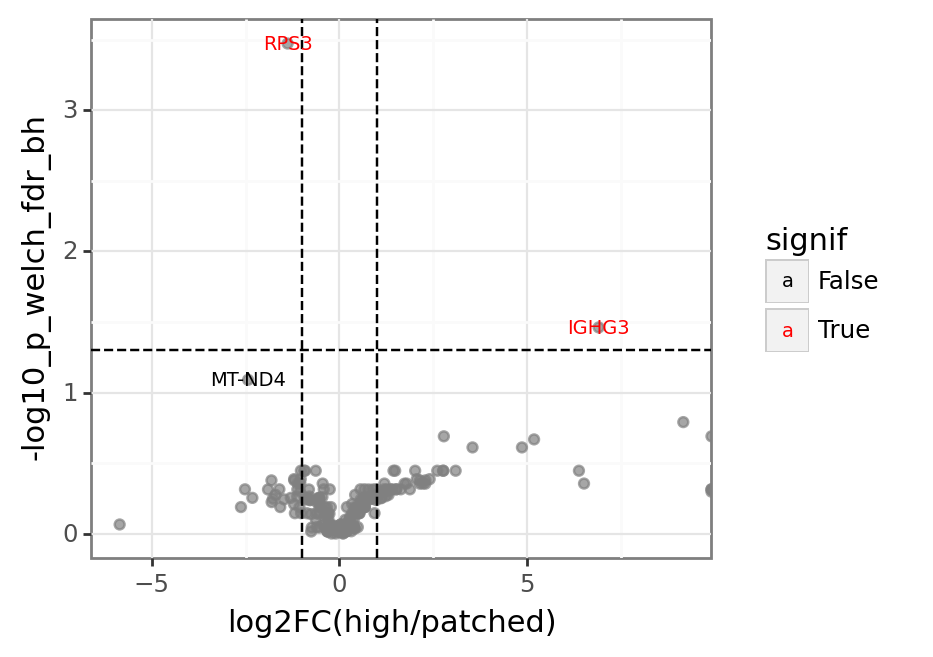

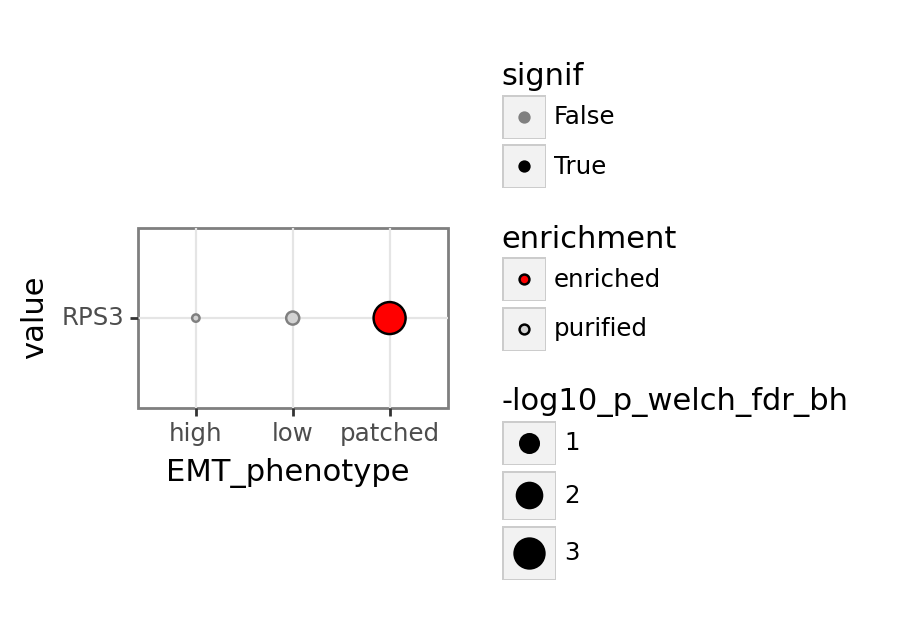

/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 205 rows containing missing values.


In [41]:
all_tmp=EMT_diff(adatas_combined,obs_mal_combined,"slide_seq",["T","NK"])
all_res=pd.concat([all_res,all_tmp[3]])
fc_res=pd.concat([fc_res,all_tmp[4]])

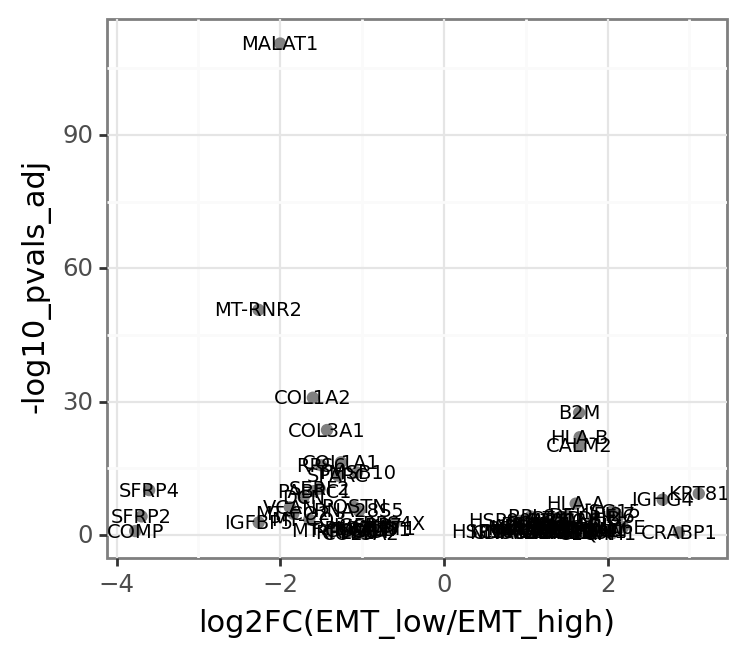


EMT_phenotype  sample            
high           HTAPP-878-SMP-7149    5000
               HTAPP-514-SMP-6760    1641
low            HTAPP-812-SMP-8239     227
               HTAPP-880-SMP-7179     198
               HTAPP-313-SMP-932      115
               HTAPP-982-SMP-7629      29
patched        HTAPP-944-SMP-7479     277
               HTAPP-917-SMP-4531     116
               HTAPP-853-SMP-4381      81
Name: count, dtype: int64
Filtering genes


/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 308 rows containing missing values.


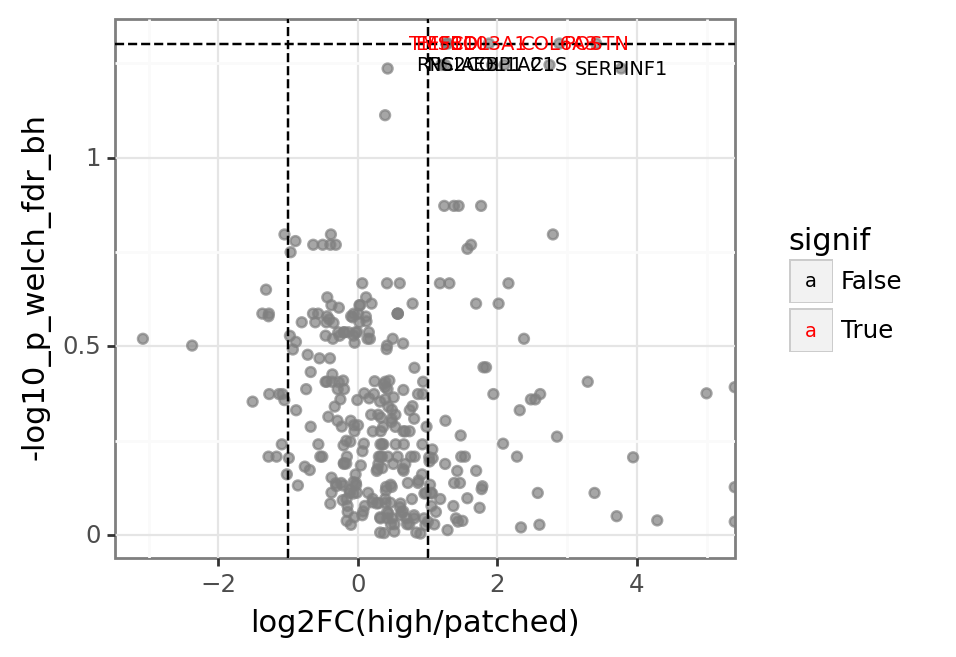

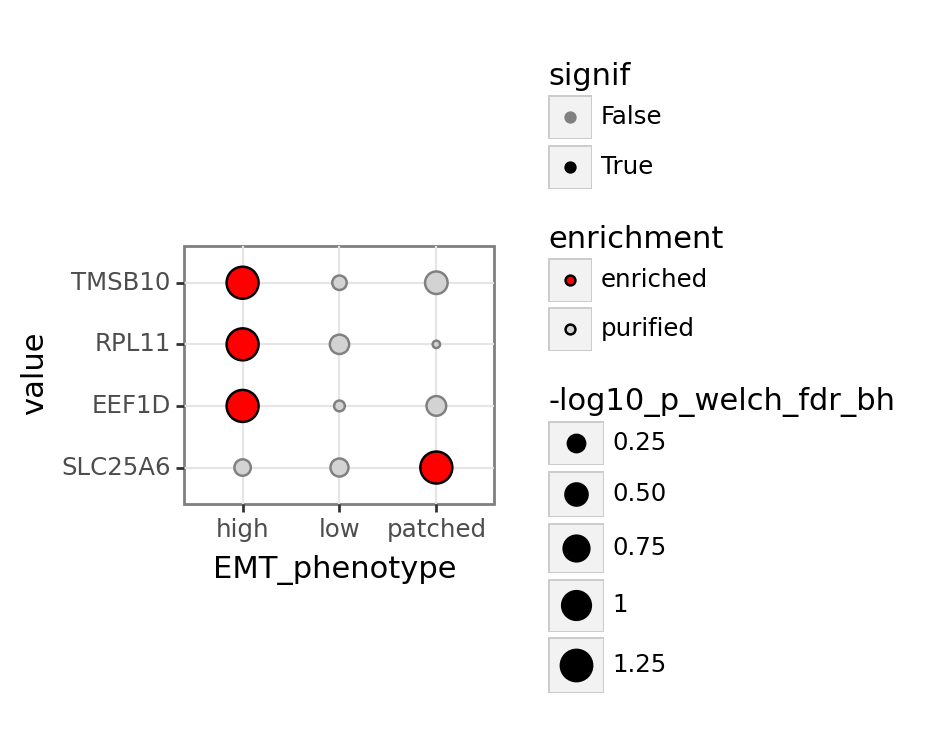

/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 308 rows containing missing values.


In [42]:
all_tmp=EMT_diff(adatas_combined,obs_mal_combined,"slide_seq",["Fibroblast"])
all_res=pd.concat([all_res,all_tmp[3]])
fc_res=pd.concat([fc_res,all_tmp[4]])

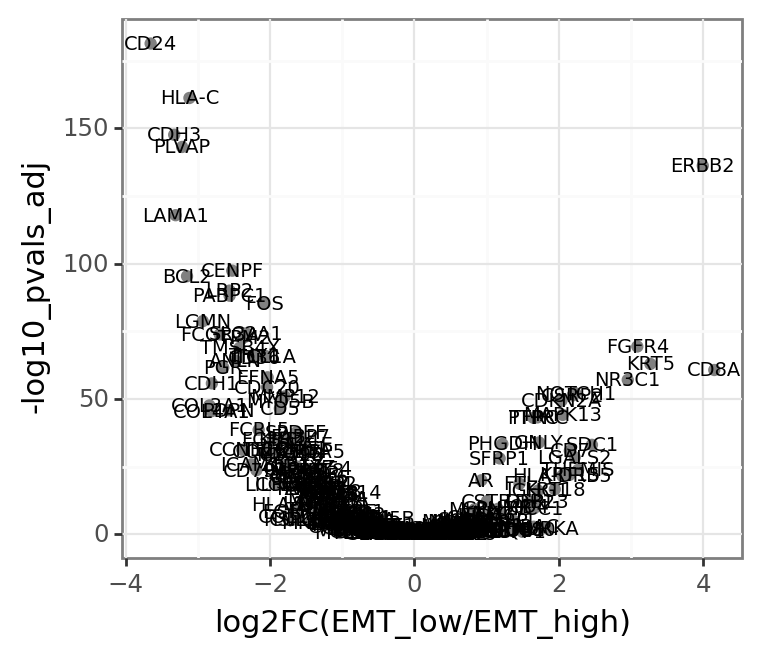


EMT_phenotype  sample            
high           HTAPP-514-SMP-6760     602
low            HTAPP-880-SMP-7179    2415
               HTAPP-313-SMP-932     1118
               HTAPP-982-SMP-7629    1011
patched        HTAPP-917-SMP-4531     850
Name: count, dtype: int64


/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 299 rows containing missing values.


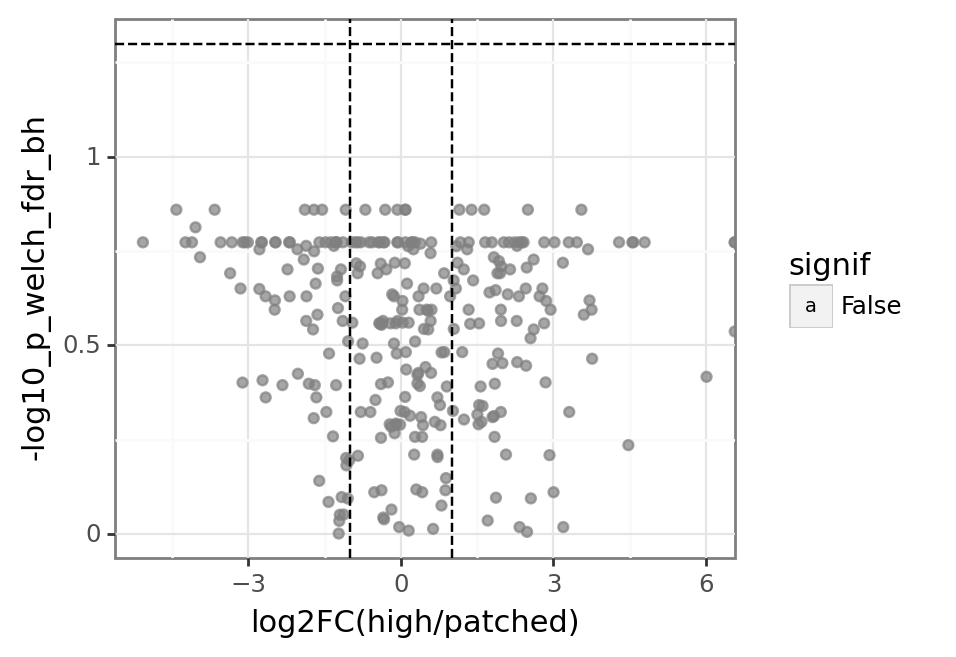

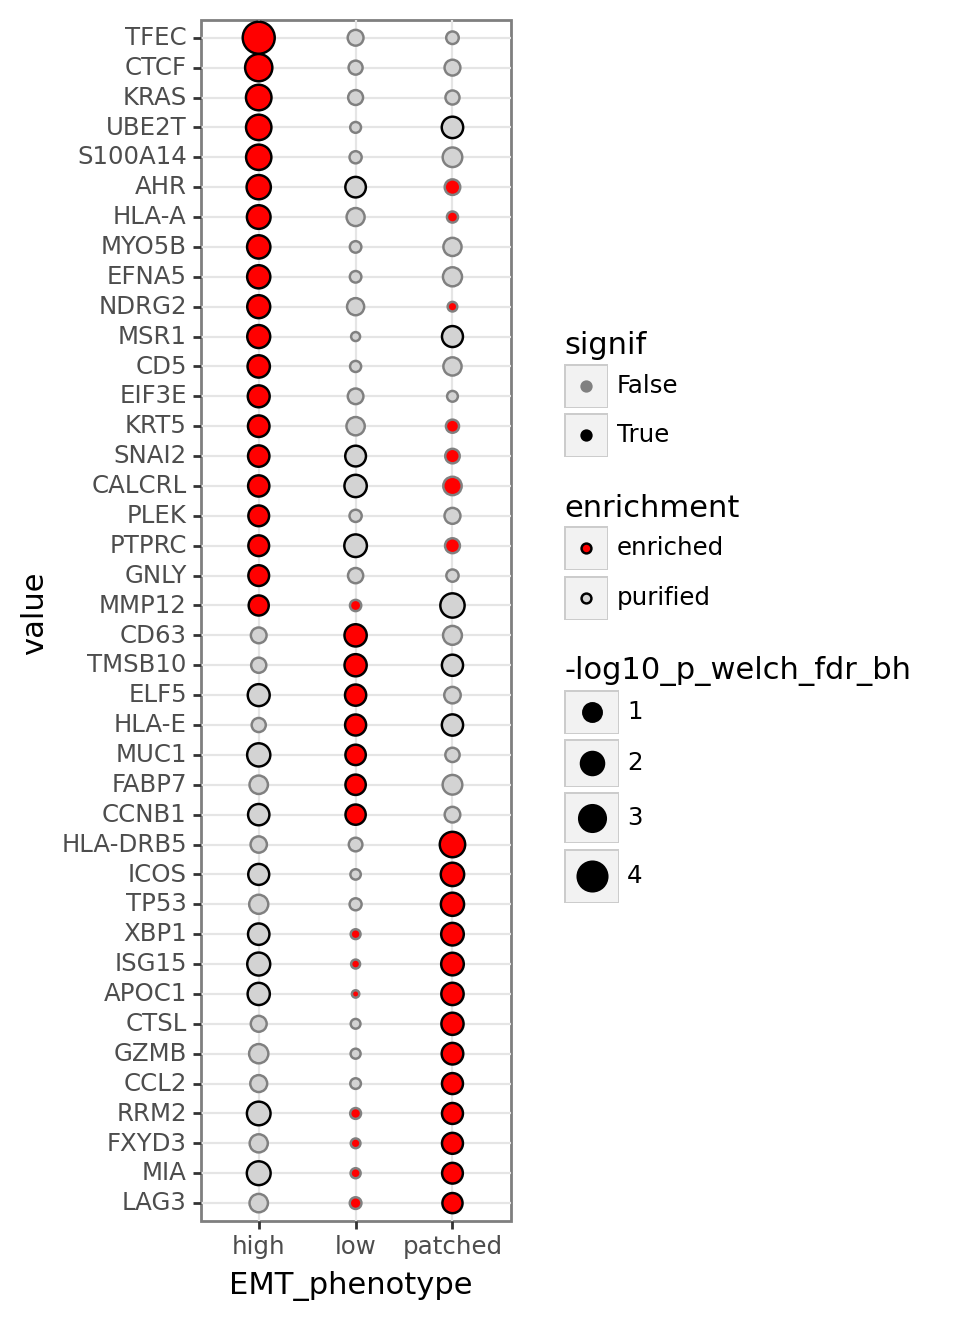

/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 299 rows containing missing values.


In [43]:
all_tmp=EMT_diff(adatas_combined,obs_mal_combined,"exseq",["MBC","MBC_stem-like","MBC_neuronal"])
all_res=pd.concat([all_res,all_tmp[3]])
fc_res=pd.concat([fc_res,all_tmp[4]])

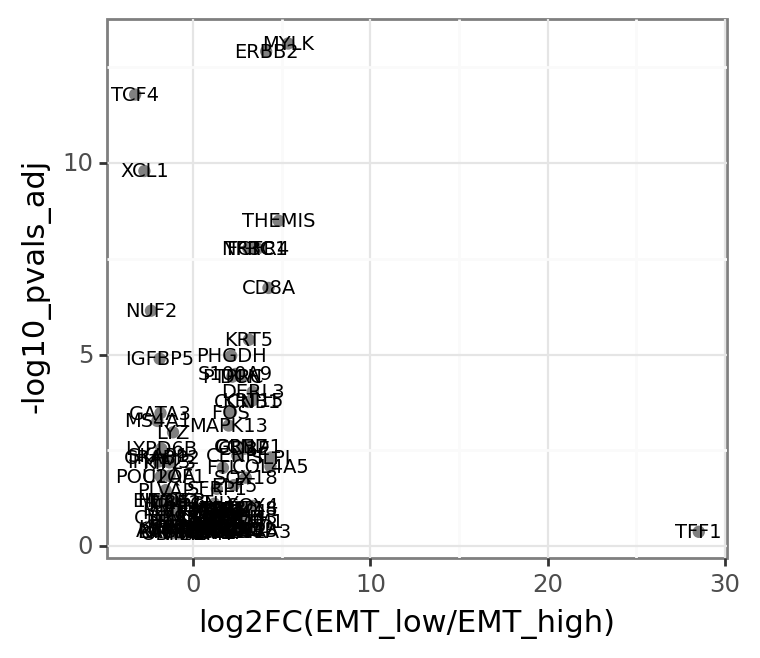


EMT_phenotype  sample            
high           HTAPP-514-SMP-6760     25
low            HTAPP-982-SMP-7629    316
               HTAPP-313-SMP-932     231
               HTAPP-880-SMP-7179      6
patched        HTAPP-917-SMP-4531    121
Name: count, dtype: int64


/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 7 rows containing missing values.
/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 299 rows containing missing values.


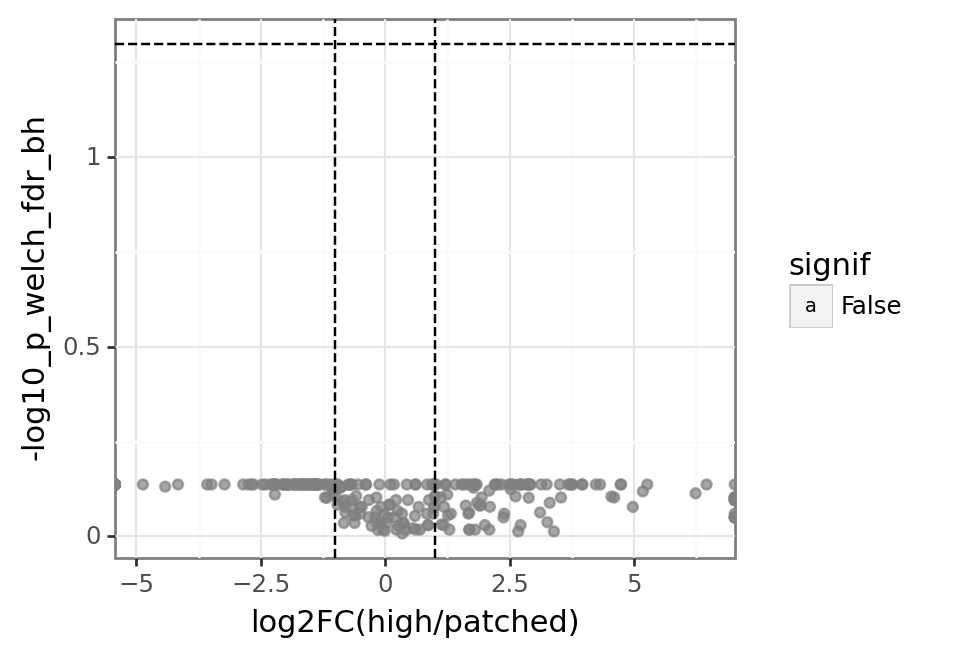

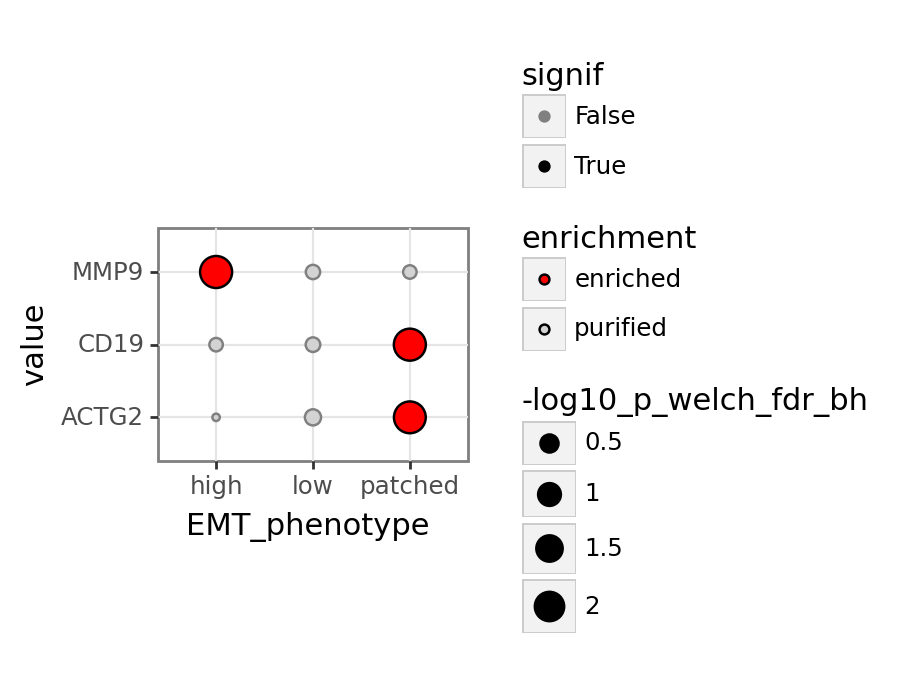

/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 7 rows containing missing values.
/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 299 rows containing missing values.


In [44]:
all_tmp=EMT_diff(adatas_combined,obs_mal_combined,"exseq",["Macrophage"])
all_res=pd.concat([all_res,all_tmp[3]])
fc_res=pd.concat([fc_res,all_tmp[4]])

In [108]:
#EMT_diff(adatas_combined,obs_mal_combined,"exseq",["T","NK"])
#no patched

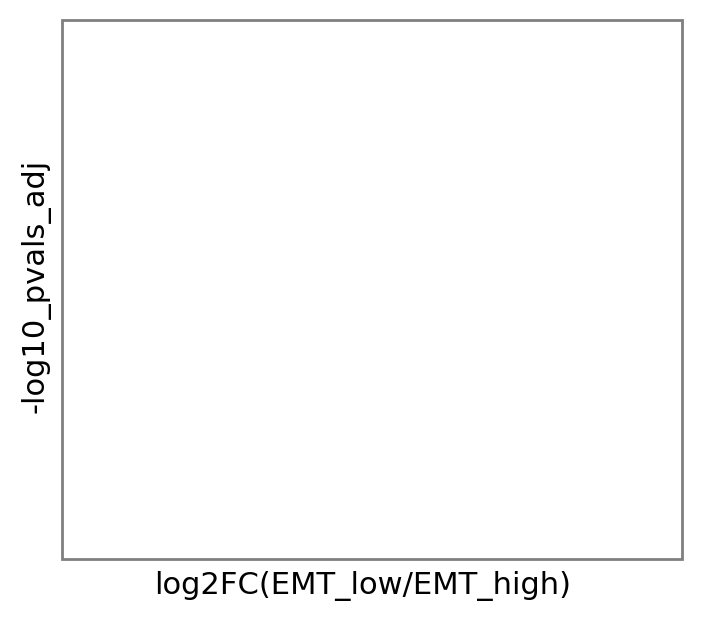


EMT_phenotype  sample            
high           HTAPP-514-SMP-6760    46
low            HTAPP-982-SMP-7629    53
               HTAPP-313-SMP-932     20
               HTAPP-880-SMP-7179     3
patched        HTAPP-917-SMP-4531    60
Name: count, dtype: int64


/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 4 rows containing missing values.
/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 293 rows containing missing values.


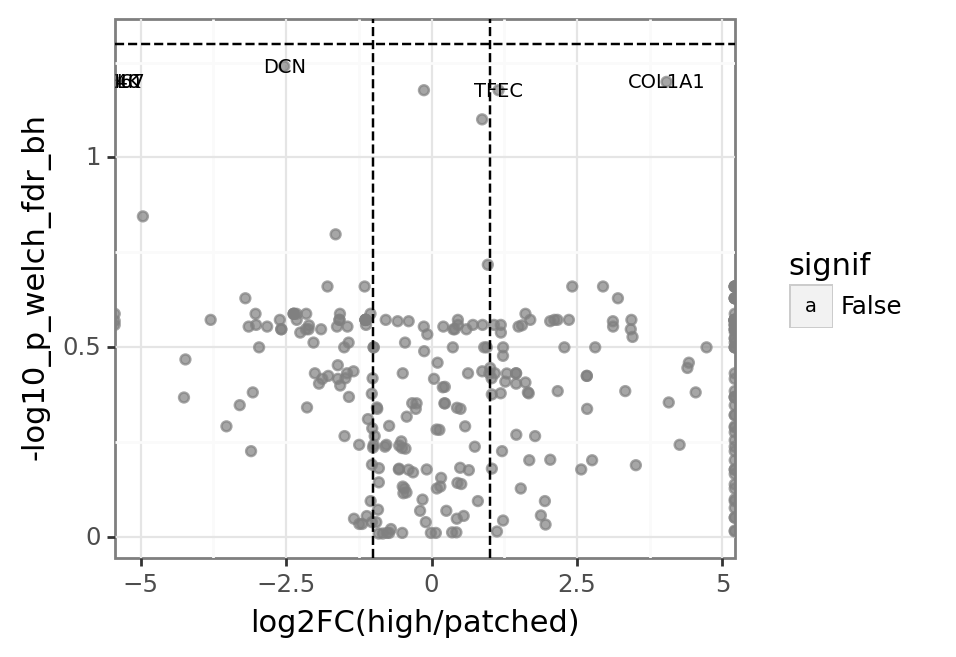

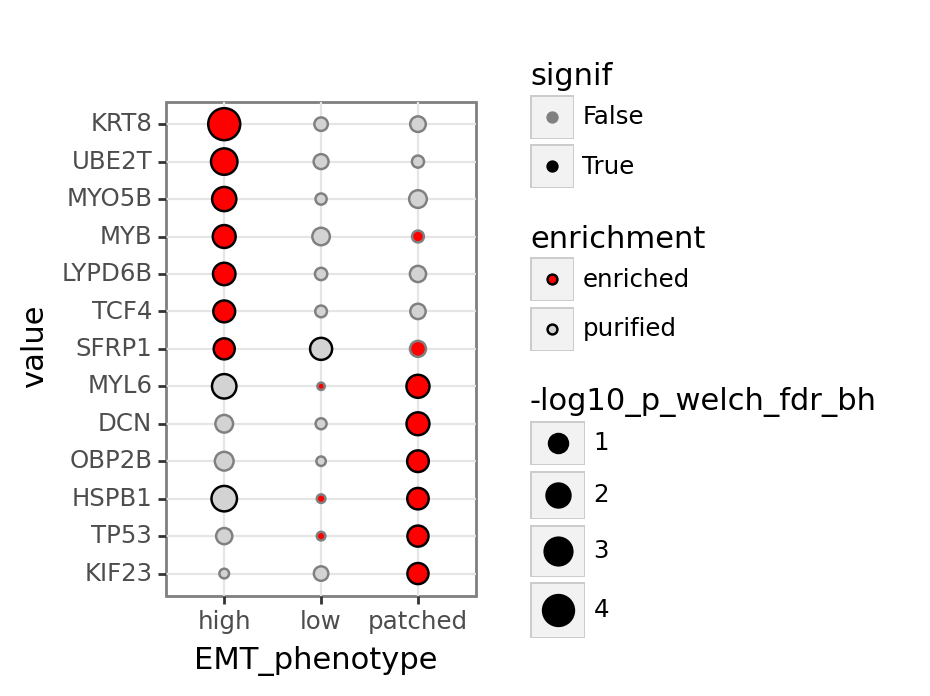

/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 4 rows containing missing values.
/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 293 rows containing missing values.


In [45]:
all_tmp=EMT_diff(adatas_combined,obs_mal_combined,"exseq",["Fibroblast"])
all_res=pd.concat([all_res,all_tmp[3]])
fc_res=pd.concat([fc_res,all_tmp[4]])

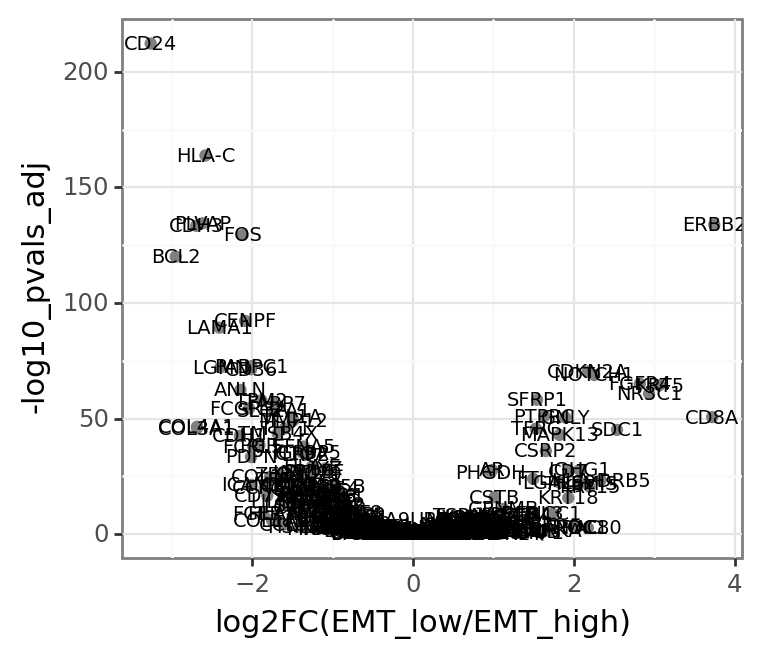


EMT_phenotype  sample            
high           HTAPP-514-SMP-6760    1574
low            HTAPP-880-SMP-7179    4123
               HTAPP-982-SMP-7629    1577
               HTAPP-313-SMP-932     1409
patched        HTAPP-917-SMP-4531    1022
Name: count, dtype: int64


/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 1 rows containing missing values.
/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 299 rows containing missing values.


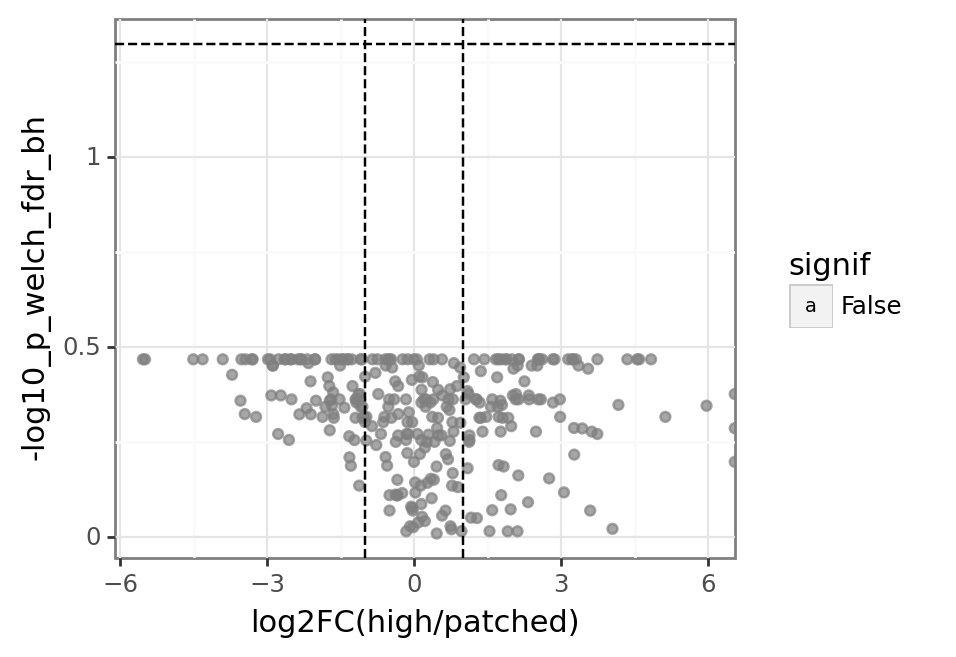

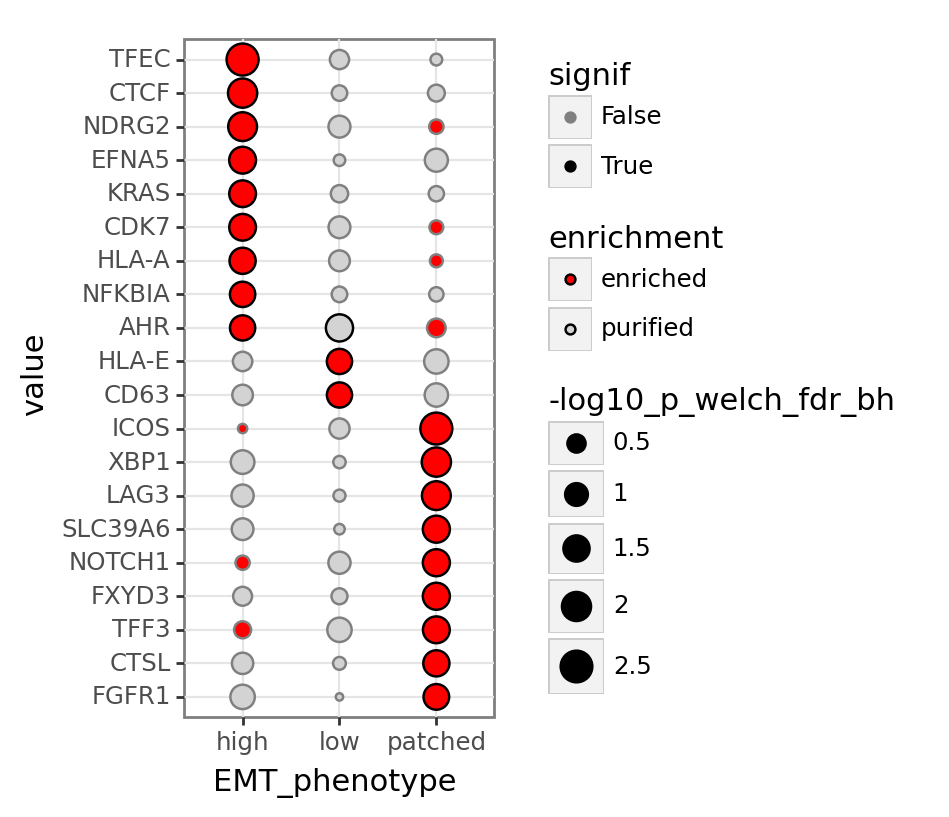

/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 1 rows containing missing values.
/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 299 rows containing missing values.


In [46]:
all_tmp=EMT_diff(adatas_combined,obs_mal_combined,"exseq_bin",["MBC","MBC_stem-like","MBC_neuronal"])
all_res=pd.concat([all_res,all_tmp[3]])
fc_res=pd.concat([fc_res,all_tmp[4]])

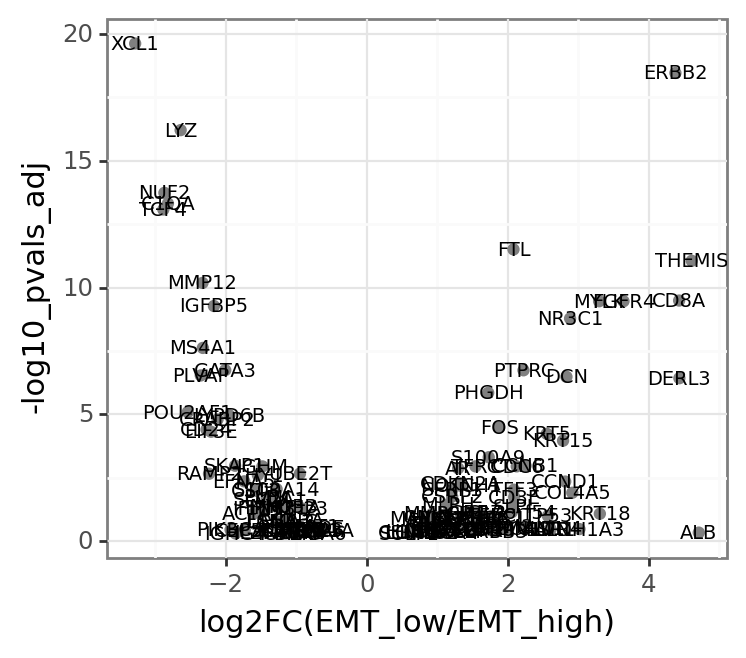


EMT_phenotype  sample            
high           HTAPP-514-SMP-6760    105
low            HTAPP-982-SMP-7629    440
               HTAPP-313-SMP-932     335
               HTAPP-880-SMP-7179     35
patched        HTAPP-917-SMP-4531    157
Name: count, dtype: int64


/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 3 rows containing missing values.
/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 299 rows containing missing values.


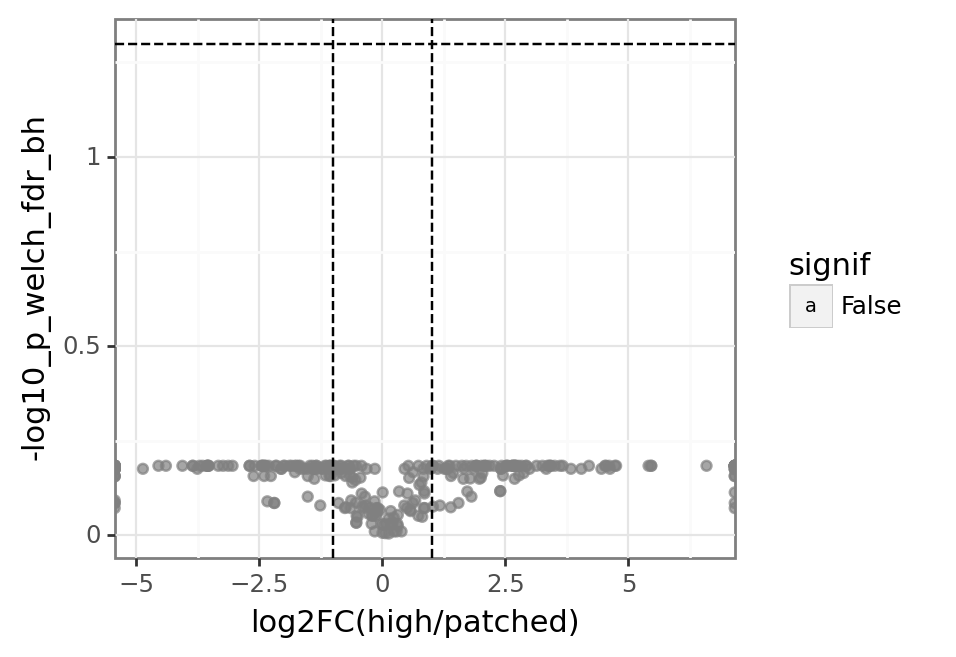

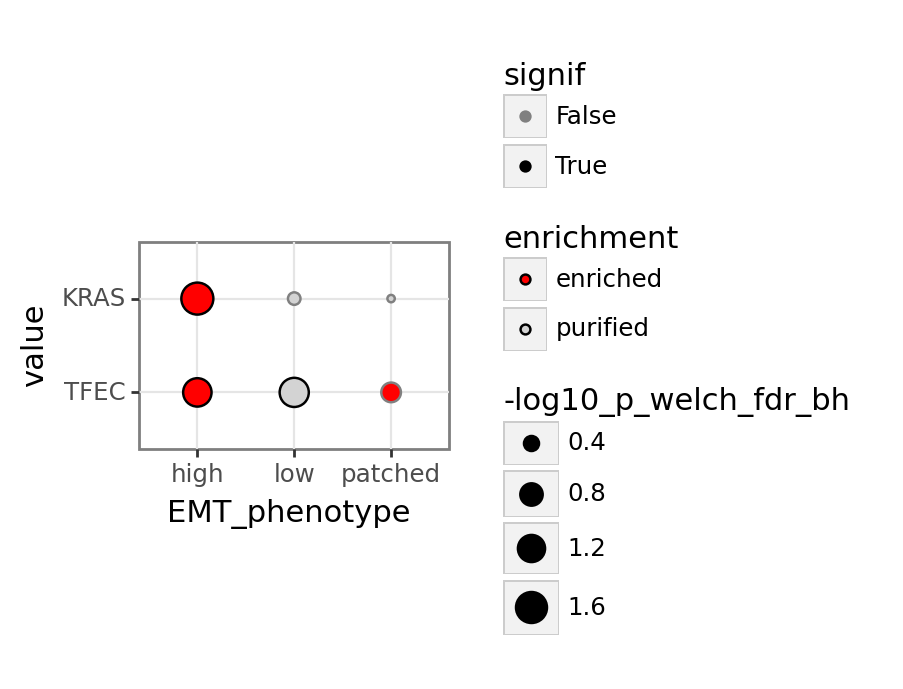

/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 3 rows containing missing values.
/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 299 rows containing missing values.


In [47]:
all_tmp=EMT_diff(adatas_combined,obs_mal_combined,"exseq_bin",["Macrophage"])
all_res=pd.concat([all_res,all_tmp[3]])
fc_res=pd.concat([fc_res,all_tmp[4]])

In [48]:
#EMT_diff(adatas_combined,obs_mal_combined,"exseq_bin",["T"])
#no patched

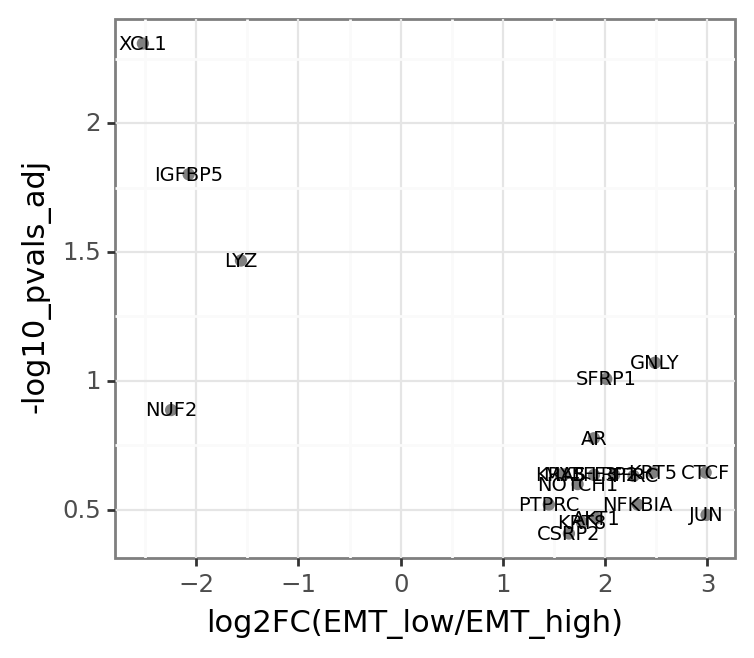


EMT_phenotype  sample            
high           HTAPP-514-SMP-6760    198
low            HTAPP-982-SMP-7629     96
               HTAPP-313-SMP-932      43
               HTAPP-880-SMP-7179     24
patched        HTAPP-917-SMP-4531     66
Name: count, dtype: int64


/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 1 rows containing missing values.
/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 299 rows containing missing values.


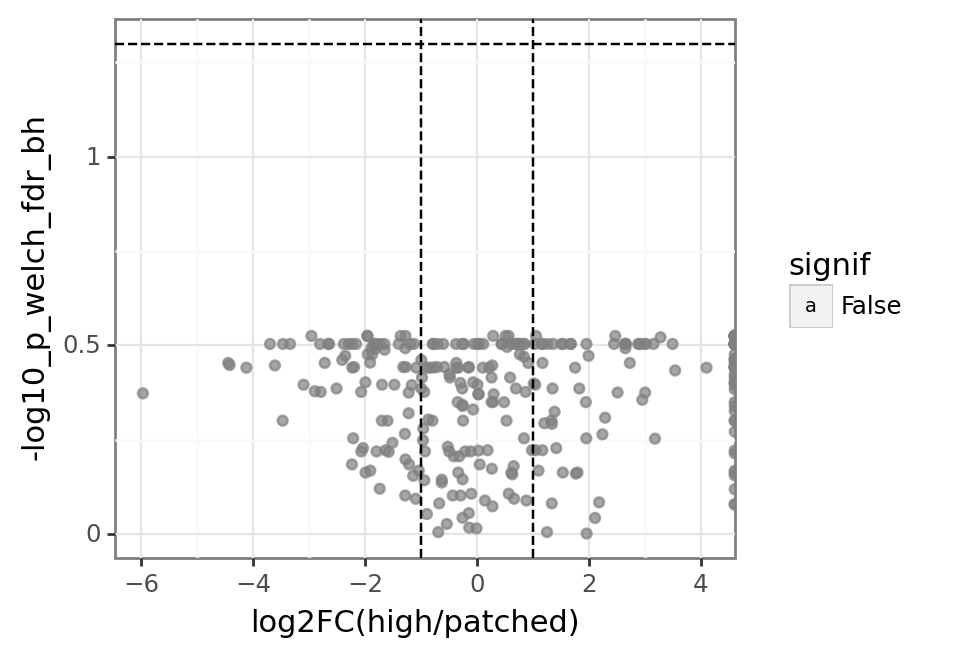

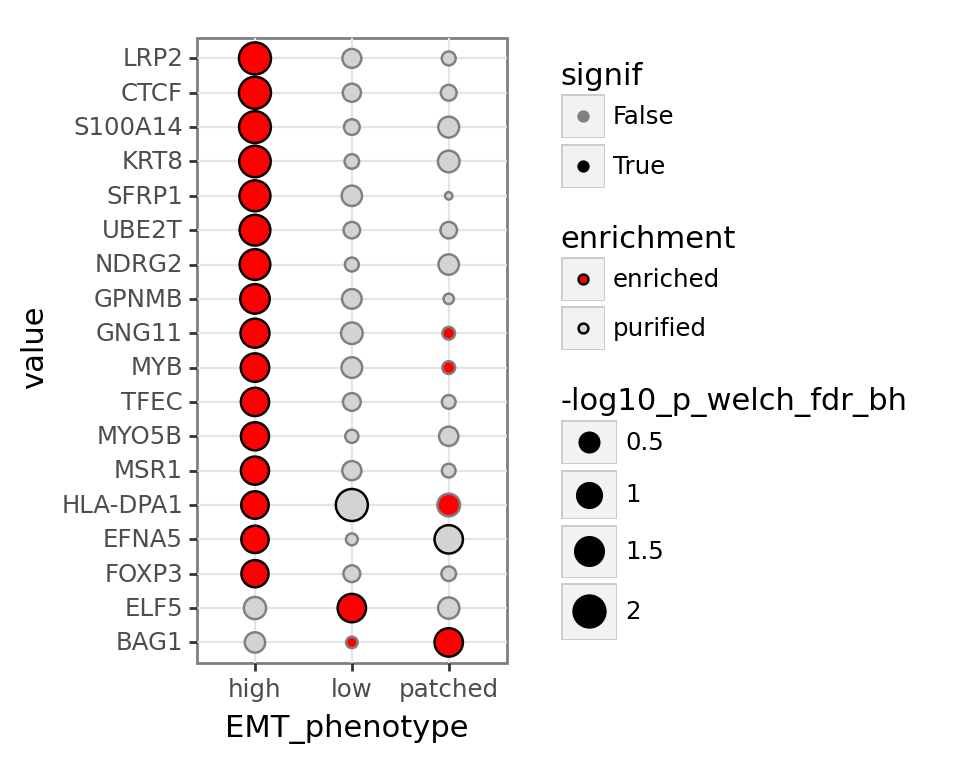

/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 1 rows containing missing values.
/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 299 rows containing missing values.


In [49]:
all_tmp=EMT_diff(adatas_combined,obs_mal_combined,"exseq_bin",["Fibroblast"])
all_res=pd.concat([all_res,all_tmp[3]])
fc_res=pd.concat([fc_res,all_tmp[4]])

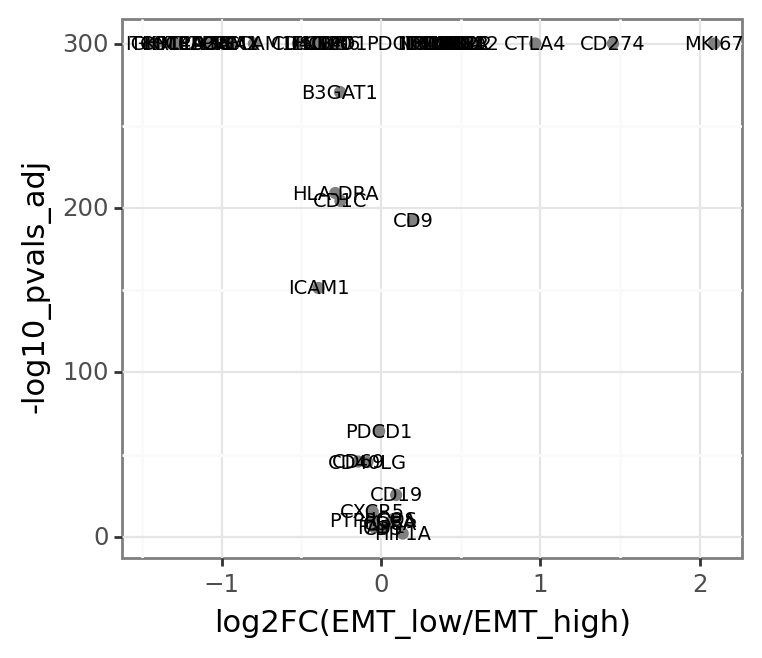


EMT_phenotype  sample            
high           HTAPP-514-SMP-6760    21970
               HTAPP-878-SMP-7149     7531
low            HTAPP-880-SMP-7179    18412
               HTAPP-313-SMP-932     16428
               HTAPP-982-SMP-7629    14337
               HTAPP-812-SMP-8239     6326
patched        HTAPP-917-SMP-4531    34800
               HTAPP-853-SMP-4381    10120
Name: count, dtype: int64


/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 33 rows containing missing values.


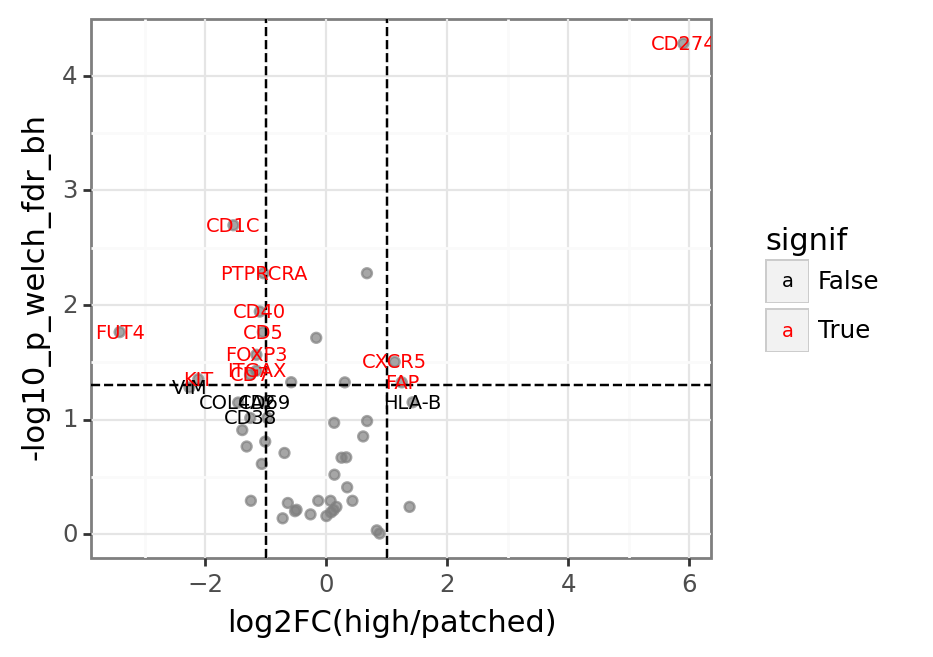

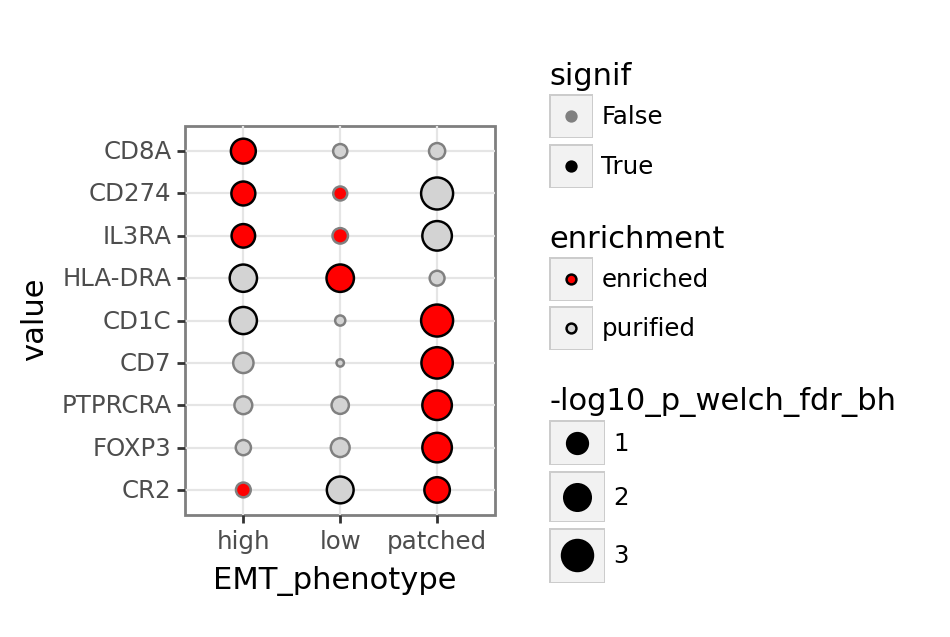

/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 33 rows containing missing values.


In [50]:
all_tmp=EMT_diff(adatas_combined,obs_mal_combined,"codex",["MBC","MBC_stem-like","MBC_neuronal"])
all_res=pd.concat([all_res,all_tmp[3]])
fc_res=pd.concat([fc_res,all_tmp[4]])

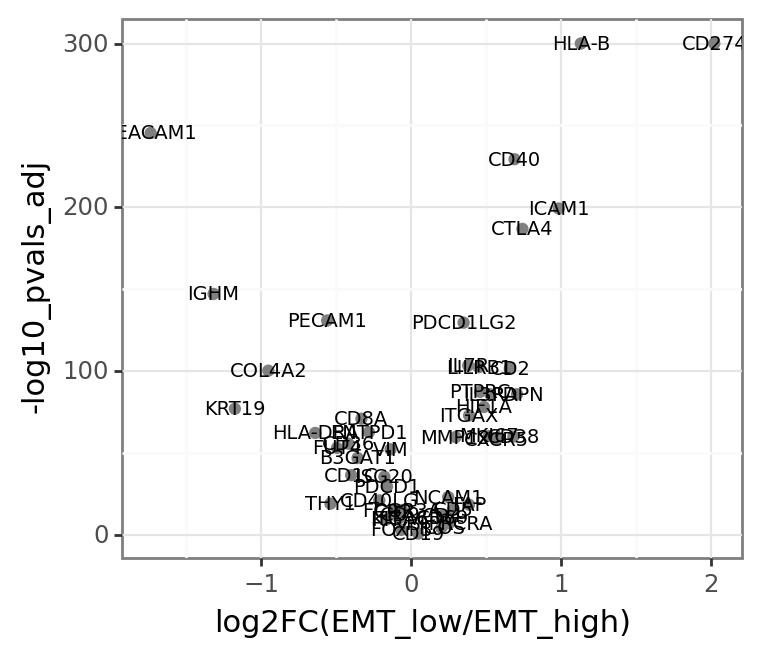


EMT_phenotype  sample            
high           HTAPP-514-SMP-6760    3060
               HTAPP-878-SMP-7149    2195
low            HTAPP-313-SMP-932     3782
               HTAPP-812-SMP-8239    1569
               HTAPP-982-SMP-7629    1151
               HTAPP-880-SMP-7179     164
patched        HTAPP-853-SMP-4381     980
               HTAPP-917-SMP-4531     353
Name: count, dtype: int64


/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 43 rows containing missing values.


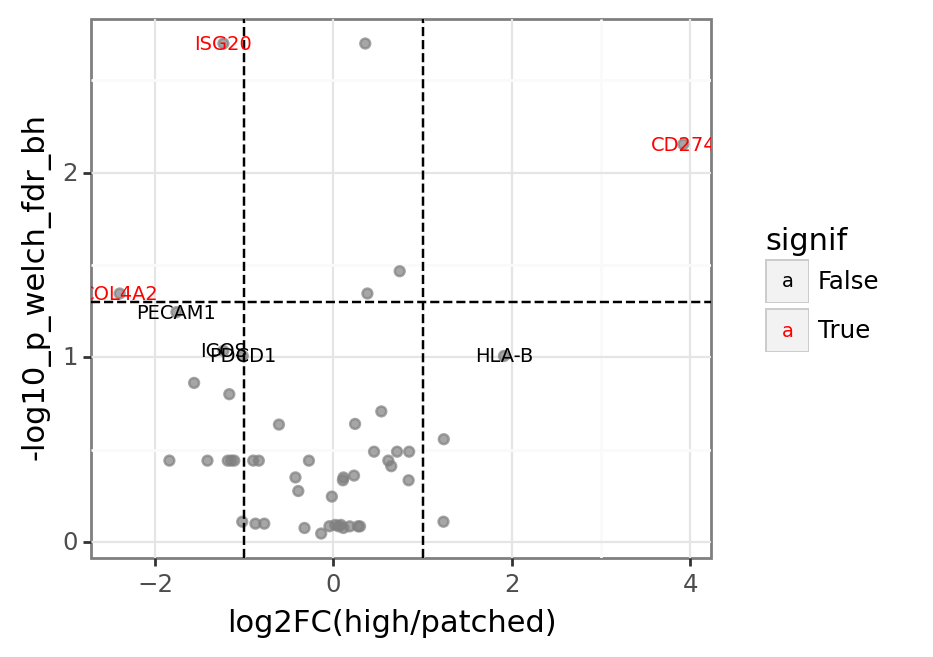

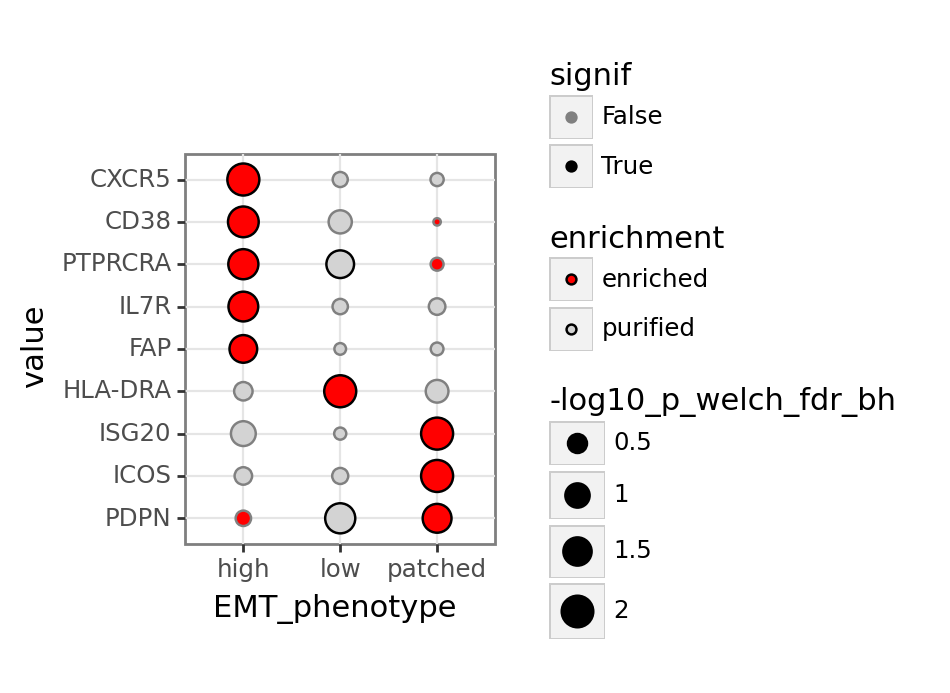

/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 43 rows containing missing values.


In [51]:
all_tmp=EMT_diff(adatas_combined,obs_mal_combined,"codex",["Macrophage"])
all_res=pd.concat([all_res,all_tmp[3]])
fc_res=pd.concat([fc_res,all_tmp[4]])

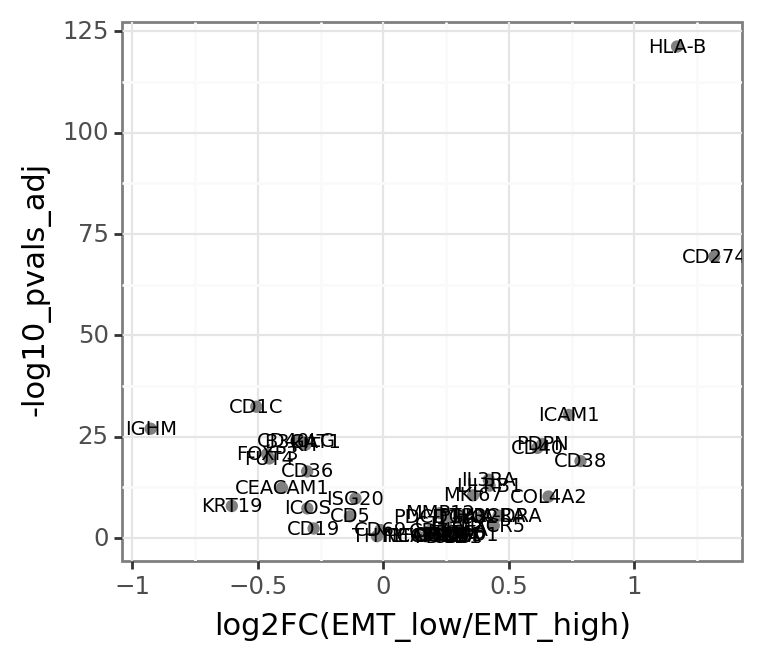


EMT_phenotype  sample            
high           HTAPP-878-SMP-7149    1143
               HTAPP-514-SMP-6760    1092
low            HTAPP-812-SMP-8239    1166
               HTAPP-313-SMP-932      782
               HTAPP-880-SMP-7179     158
               HTAPP-982-SMP-7629     125
patched        HTAPP-853-SMP-4381     611
Name: count, dtype: int64


/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 33 rows containing missing values.


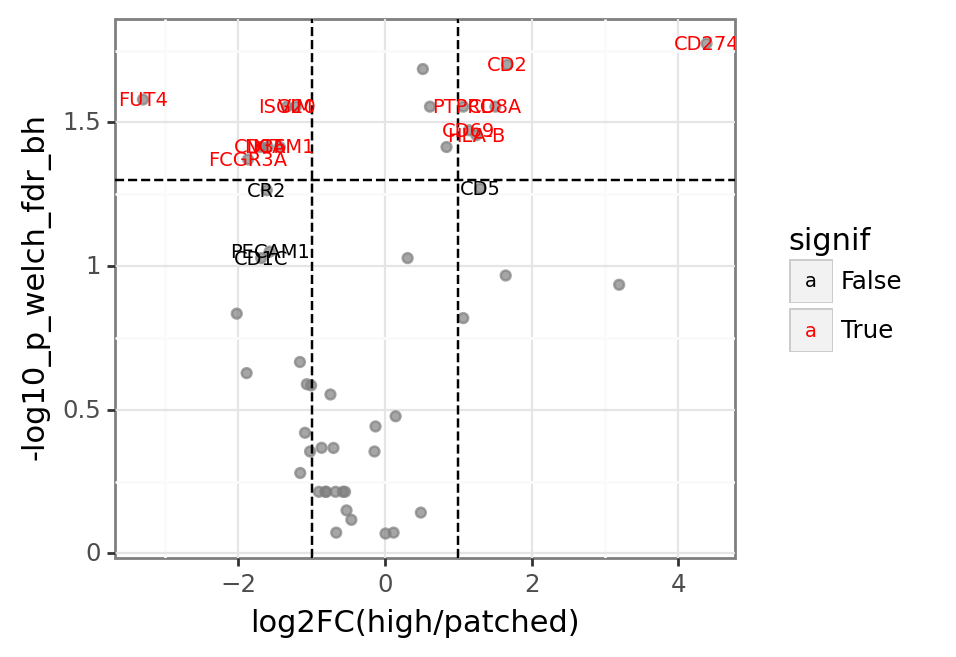

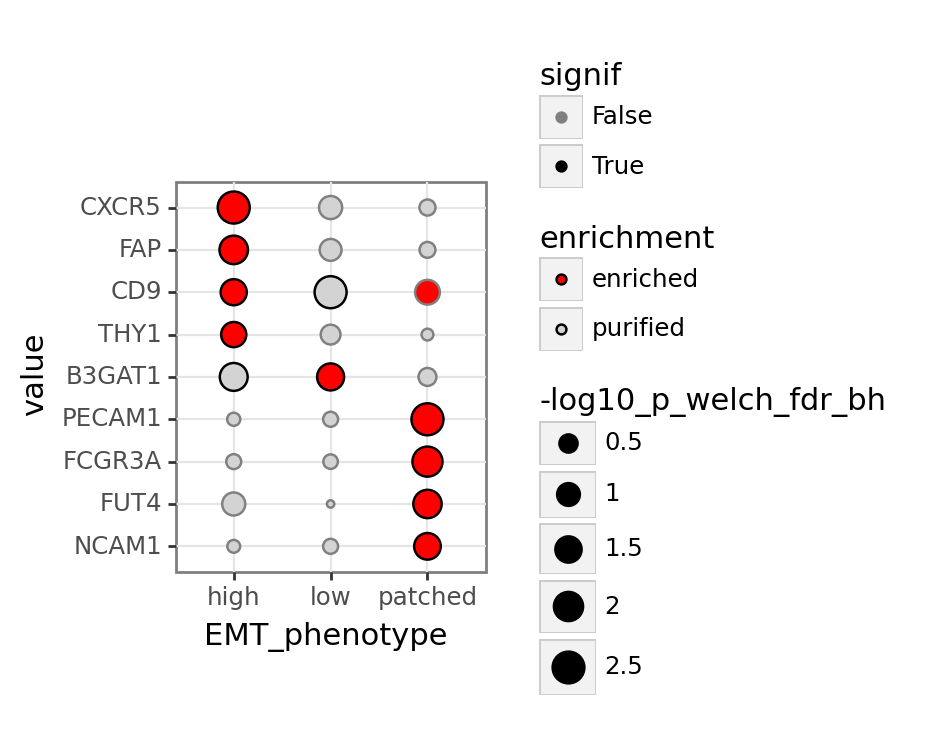

/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 33 rows containing missing values.


In [52]:
all_tmp=EMT_diff(adatas_combined,obs_mal_combined,"codex",["T","NK"])
all_res=pd.concat([all_res,all_tmp[3]])
fc_res=pd.concat([fc_res,all_tmp[4]])

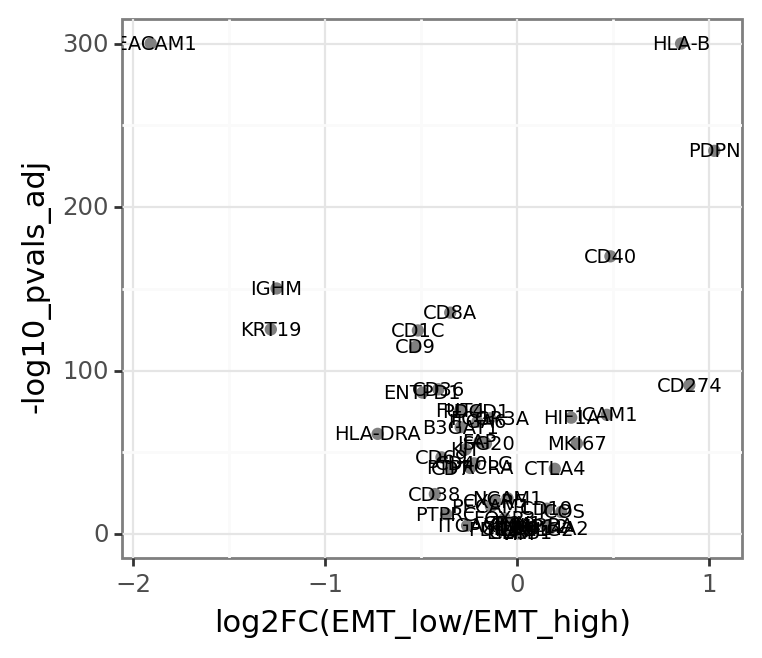


EMT_phenotype  sample            
high           HTAPP-878-SMP-7149    13099
               HTAPP-514-SMP-6760     2690
low            HTAPP-812-SMP-8239     1720
               HTAPP-313-SMP-932       372
               HTAPP-982-SMP-7629       69
               HTAPP-880-SMP-7179       50
patched        HTAPP-853-SMP-4381      702
               HTAPP-917-SMP-4531      586
Name: count, dtype: int64


/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 43 rows containing missing values.


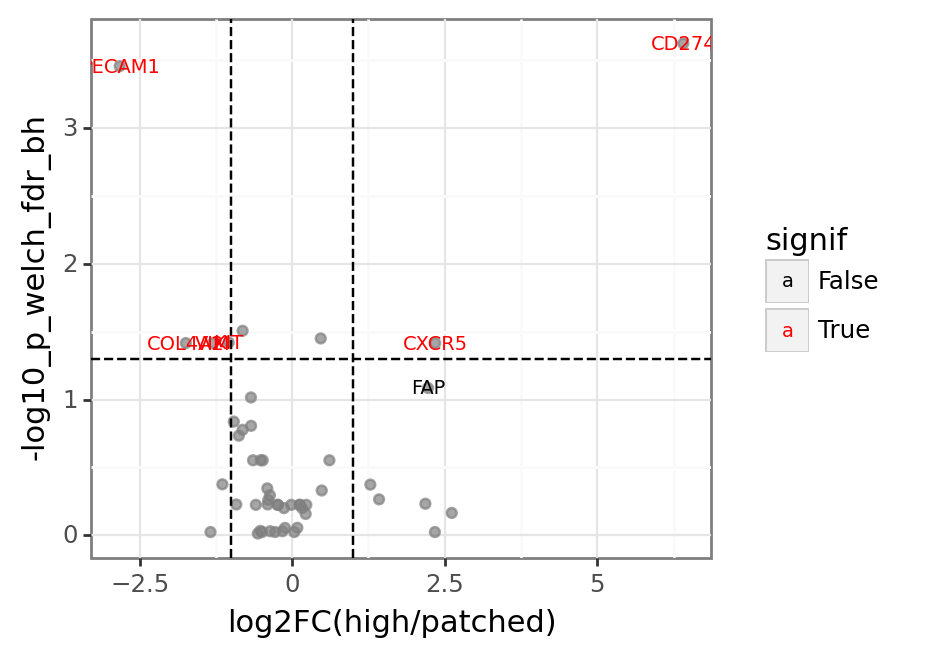

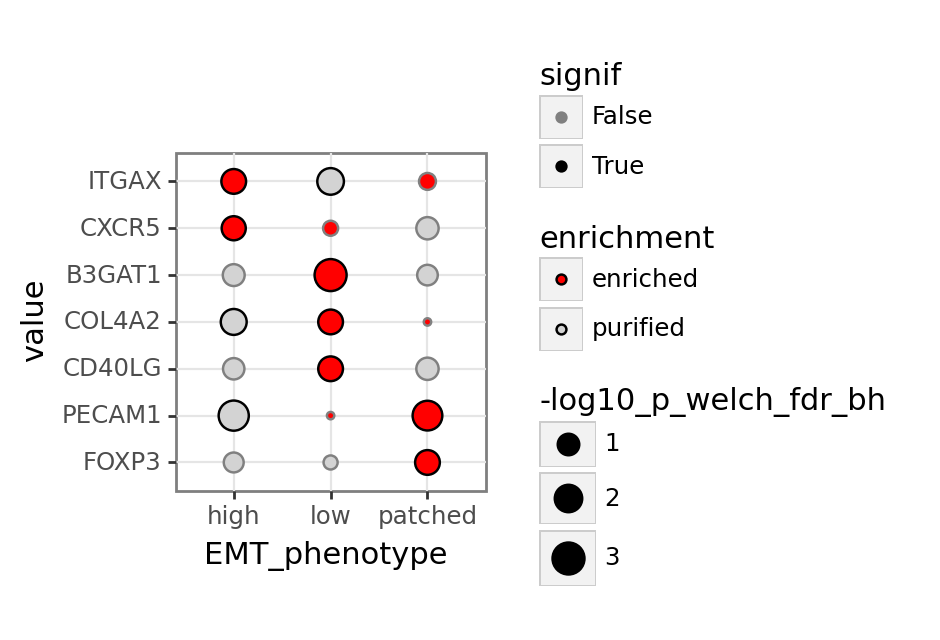

/secure/src/anaconda3/envs/TACCOv0.2.2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_text : Removed 43 rows containing missing values.


In [53]:
all_tmp=EMT_diff(adatas_combined,obs_mal_combined,"codex",["Fibroblast"])
all_res=pd.concat([all_res,all_tmp[3]])
fc_res=pd.concat([fc_res,all_tmp[4]])

### Combined analysis

In [118]:
all_res.to_csv(combined_dir+"/DE_all_EMT_pheno.tsv", sep="\t")

In [119]:
fc_res.to_csv(combined_dir+"/DE_EMT_high-patched.tsv", sep="\t")